## Submodule-2.1 : Dynamical Systems

## Table of Contents
#### 1. [PINN for Burger's Equation in TensorFlow](#PINN-for-Burger's-Equation-in-TensorFlow)
#### 2. [PINN for Burger's Equation in JAX](#PINN-for-Burger's-Equation-in-JAX)
#### 3. [PINN for a Boundary Layer Problem](#PINN-for-a-Boundary-Layer-Problem)
#### 4. [Neural Network with Hard Constraints](#Neural-Network-with-Hard-Constraints)


## PINN-for-Burger's-Equation

In [18]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

In [19]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x, t, w, b):
    u = DNN(tf.concat([x,t],1), w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,t,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x, t])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x, t])
            u=net_u(x,t, W, b)
        u_t = tape2.gradient(u, t)
        u_x = tape2.gradient(u, x)
    u_xx = tape1.gradient(u_x, x)  
    f = u_t + u*u_x - nu*u_xx
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu):
    x_u = X_u_train_tf[:,0:1]
    t_u = X_u_train_tf[:,1:2]
    x_f = X_f_train_tf[:,0:1]
    t_f = X_f_train_tf[:,1:2]
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u, t_u, W, b) 
        f_nn = net_f(x_f,t_f, W, b, nu)
        loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf)) + tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss





nu = 0.01/np.pi # Viscosity
N_u = 100 # Number of Initial and Boundary data points
N_f = 10000 # Number of residual point
Nmax= 20000

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

data = scipy.io.loadmat('./Data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)  

# Initial Condition
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

# Boundary condition -1
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

# Boundary condition 1
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)

lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

    

Iteration is: 0 and loss is: 0.2566310167312622
Iteration is: 1 and loss is: 0.23526228964328766
Iteration is: 2 and loss is: 0.22125136852264404
Iteration is: 3 and loss is: 0.2152591347694397
Iteration is: 4 and loss is: 0.21643051505088806
Iteration is: 5 and loss is: 0.22051557898521423
Iteration is: 6 and loss is: 0.22254502773284912
Iteration is: 7 and loss is: 0.22123509645462036
Iteration is: 8 and loss is: 0.2179287075996399
Iteration is: 9 and loss is: 0.21430082619190216
Iteration is: 10 and loss is: 0.21143503487110138
Iteration is: 11 and loss is: 0.2097298800945282
Iteration is: 12 and loss is: 0.20907731354236603
Iteration is: 13 and loss is: 0.20907141268253326
Iteration is: 14 and loss is: 0.20919497311115265
Iteration is: 15 and loss is: 0.2089935839176178
Iteration is: 16 and loss is: 0.20821210741996765
Iteration is: 17 and loss is: 0.2068447321653366
Iteration is: 18 and loss is: 0.20509067177772522
Iteration is: 19 and loss is: 0.2032514214515686
Iteration is: 20 

Iteration is: 166 and loss is: 0.08849170804023743
Iteration is: 167 and loss is: 0.08854237198829651
Iteration is: 168 and loss is: 0.08885208517313004
Iteration is: 169 and loss is: 0.08965422213077545
Iteration is: 170 and loss is: 0.09042058140039444
Iteration is: 171 and loss is: 0.08939284086227417
Iteration is: 172 and loss is: 0.08793023228645325
Iteration is: 173 and loss is: 0.08872589468955994
Iteration is: 174 and loss is: 0.08907507359981537
Iteration is: 175 and loss is: 0.08781430125236511
Iteration is: 176 and loss is: 0.08811157941818237
Iteration is: 177 and loss is: 0.08850400894880295
Iteration is: 178 and loss is: 0.0875641256570816
Iteration is: 179 and loss is: 0.08781102299690247
Iteration is: 180 and loss is: 0.08800071477890015
Iteration is: 181 and loss is: 0.0873023122549057
Iteration is: 182 and loss is: 0.08757937699556351
Iteration is: 183 and loss is: 0.08755649626255035
Iteration is: 184 and loss is: 0.08707951754331589
Iteration is: 185 and loss is: 0.

Iteration is: 333 and loss is: 0.07353556156158447
Iteration is: 334 and loss is: 0.07327693700790405
Iteration is: 335 and loss is: 0.07300188392400742
Iteration is: 336 and loss is: 0.07288768887519836
Iteration is: 337 and loss is: 0.07283227145671844
Iteration is: 338 and loss is: 0.0726868212223053
Iteration is: 339 and loss is: 0.07248789817094803
Iteration is: 340 and loss is: 0.07235917448997498
Iteration is: 341 and loss is: 0.07228666543960571
Iteration is: 342 and loss is: 0.07217172533273697
Iteration is: 343 and loss is: 0.07198157161474228
Iteration is: 344 and loss is: 0.07178449630737305
Iteration is: 345 and loss is: 0.0716402605175972
Iteration is: 346 and loss is: 0.07153845578432083
Iteration is: 347 and loss is: 0.07142512500286102
Iteration is: 348 and loss is: 0.07129192352294922
Iteration is: 349 and loss is: 0.07115800678730011
Iteration is: 350 and loss is: 0.07109259068965912
Iteration is: 351 and loss is: 0.07114940136671066
Iteration is: 352 and loss is: 0.

Iteration is: 498 and loss is: 0.05858601629734039
Iteration is: 499 and loss is: 0.05856701731681824
Iteration is: 500 and loss is: 0.05808525159955025
Iteration is: 501 and loss is: 0.05785463750362396
Iteration is: 502 and loss is: 0.05802217870950699
Iteration is: 503 and loss is: 0.05799572914838791
Iteration is: 504 and loss is: 0.05766826122999191
Iteration is: 505 and loss is: 0.05749168619513512
Iteration is: 506 and loss is: 0.05757303535938263
Iteration is: 507 and loss is: 0.05754704028367996
Iteration is: 508 and loss is: 0.05728299170732498
Iteration is: 509 and loss is: 0.057105787098407745
Iteration is: 510 and loss is: 0.05711670219898224
Iteration is: 511 and loss is: 0.05708037316799164
Iteration is: 512 and loss is: 0.05689644068479538
Iteration is: 513 and loss is: 0.056727953255176544
Iteration is: 514 and loss is: 0.056684527546167374
Iteration is: 515 and loss is: 0.05664270743727684
Iteration is: 516 and loss is: 0.05649663880467415
Iteration is: 517 and loss i

Iteration is: 662 and loss is: 0.036982957273721695
Iteration is: 663 and loss is: 0.03801746293902397
Iteration is: 664 and loss is: 0.039404094219207764
Iteration is: 665 and loss is: 0.03982669115066528
Iteration is: 666 and loss is: 0.039337340742349625
Iteration is: 667 and loss is: 0.03772089630365372
Iteration is: 668 and loss is: 0.03650568053126335
Iteration is: 669 and loss is: 0.03612232208251953
Iteration is: 670 and loss is: 0.03659557178616524
Iteration is: 671 and loss is: 0.03752657398581505
Iteration is: 672 and loss is: 0.03834052383899689
Iteration is: 673 and loss is: 0.03908434137701988
Iteration is: 674 and loss is: 0.039297059178352356
Iteration is: 675 and loss is: 0.03931186720728874
Iteration is: 676 and loss is: 0.03836287185549736
Iteration is: 677 and loss is: 0.03710995987057686
Iteration is: 678 and loss is: 0.035751186311244965
Iteration is: 679 and loss is: 0.03504167124629021
Iteration is: 680 and loss is: 0.03505531698465347
Iteration is: 681 and loss

Iteration is: 827 and loss is: 0.041748255491256714
Iteration is: 828 and loss is: 0.03518024459481239
Iteration is: 829 and loss is: 0.03106030449271202
Iteration is: 830 and loss is: 0.04434199631214142
Iteration is: 831 and loss is: 0.028522856533527374
Iteration is: 832 and loss is: 0.03780278563499451
Iteration is: 833 and loss is: 0.0310650747269392
Iteration is: 834 and loss is: 0.03286650404334068
Iteration is: 835 and loss is: 0.033318378031253815
Iteration is: 836 and loss is: 0.02988486923277378
Iteration is: 837 and loss is: 0.03359883278608322
Iteration is: 838 and loss is: 0.028123287484049797
Iteration is: 839 and loss is: 0.032835815101861954
Iteration is: 840 and loss is: 0.02772882580757141
Iteration is: 841 and loss is: 0.03178437799215317
Iteration is: 842 and loss is: 0.027768347412347794
Iteration is: 843 and loss is: 0.030399540439248085
Iteration is: 844 and loss is: 0.02807747572660446
Iteration is: 845 and loss is: 0.029202040284872055
Iteration is: 846 and lo

Iteration is: 986 and loss is: 0.02252628654241562
Iteration is: 987 and loss is: 0.023946400731801987
Iteration is: 988 and loss is: 0.02374759316444397
Iteration is: 989 and loss is: 0.0222806204110384
Iteration is: 990 and loss is: 0.022926412522792816
Iteration is: 991 and loss is: 0.023348184302449226
Iteration is: 992 and loss is: 0.02209397777915001
Iteration is: 993 and loss is: 0.02203996479511261
Iteration is: 994 and loss is: 0.022742226719856262
Iteration is: 995 and loss is: 0.022214971482753754
Iteration is: 996 and loss is: 0.021595831960439682
Iteration is: 997 and loss is: 0.022065164521336555
Iteration is: 998 and loss is: 0.022136345505714417
Iteration is: 999 and loss is: 0.021501289680600166
Iteration is: 1000 and loss is: 0.02147984690964222
Iteration is: 1001 and loss is: 0.021788708865642548
Iteration is: 1002 and loss is: 0.021543055772781372
Iteration is: 1003 and loss is: 0.021200956776738167
Iteration is: 1004 and loss is: 0.021349558606743813
Iteration is: 

Iteration is: 1146 and loss is: 0.028187964111566544
Iteration is: 1147 and loss is: 0.018565818667411804
Iteration is: 1148 and loss is: 0.025979310274124146
Iteration is: 1149 and loss is: 0.019147049635648727
Iteration is: 1150 and loss is: 0.02328328788280487
Iteration is: 1151 and loss is: 0.018782468512654305
Iteration is: 1152 and loss is: 0.022121354937553406
Iteration is: 1153 and loss is: 0.019085410982370377
Iteration is: 1154 and loss is: 0.020870165899395943
Iteration is: 1155 and loss is: 0.019241273403167725
Iteration is: 1156 and loss is: 0.019502690061926842
Iteration is: 1157 and loss is: 0.018955053761601448
Iteration is: 1158 and loss is: 0.018868958577513695
Iteration is: 1159 and loss is: 0.018665820360183716
Iteration is: 1160 and loss is: 0.018236543983221054
Iteration is: 1161 and loss is: 0.018496420234441757
Iteration is: 1162 and loss is: 0.017616504803299904
Iteration is: 1163 and loss is: 0.01827421970665455
Iteration is: 1164 and loss is: 0.01714319176971

Iteration is: 1305 and loss is: 0.012878114357590675
Iteration is: 1306 and loss is: 0.01285862922668457
Iteration is: 1307 and loss is: 0.012839196249842644
Iteration is: 1308 and loss is: 0.01281982846558094
Iteration is: 1309 and loss is: 0.012800516560673714
Iteration is: 1310 and loss is: 0.012781249359250069
Iteration is: 1311 and loss is: 0.012762049213051796
Iteration is: 1312 and loss is: 0.012742887251079082
Iteration is: 1313 and loss is: 0.012723797932267189
Iteration is: 1314 and loss is: 0.012704752385616302
Iteration is: 1315 and loss is: 0.012685775756835938
Iteration is: 1316 and loss is: 0.012666834518313408
Iteration is: 1317 and loss is: 0.012647971510887146
Iteration is: 1318 and loss is: 0.012629145756363869
Iteration is: 1319 and loss is: 0.012610409408807755
Iteration is: 1320 and loss is: 0.01259174756705761
Iteration is: 1321 and loss is: 0.012573201209306717
Iteration is: 1322 and loss is: 0.012554817833006382
Iteration is: 1323 and loss is: 0.012536752037703

Iteration is: 1461 and loss is: 0.010683063417673111
Iteration is: 1462 and loss is: 0.010669589042663574
Iteration is: 1463 and loss is: 0.010656170547008514
Iteration is: 1464 and loss is: 0.010642796754837036
Iteration is: 1465 and loss is: 0.010629428550601006
Iteration is: 1466 and loss is: 0.010616086423397064
Iteration is: 1467 and loss is: 0.010602733120322227
Iteration is: 1468 and loss is: 0.010589445941150188
Iteration is: 1469 and loss is: 0.010576187632977962
Iteration is: 1470 and loss is: 0.010562987998127937
Iteration is: 1471 and loss is: 0.010549809783697128
Iteration is: 1472 and loss is: 0.01053665578365326
Iteration is: 1473 and loss is: 0.010523530654609203
Iteration is: 1474 and loss is: 0.01051042415201664
Iteration is: 1475 and loss is: 0.01049734279513359
Iteration is: 1476 and loss is: 0.010484294965863228
Iteration is: 1477 and loss is: 0.010471288114786148
Iteration is: 1478 and loss is: 0.010458304546773434
Iteration is: 1479 and loss is: 0.010445360094308

Iteration is: 1617 and loss is: 0.009250389412045479
Iteration is: 1618 and loss is: 0.00924051832407713
Iteration is: 1619 and loss is: 0.00922921672463417
Iteration is: 1620 and loss is: 0.009219340980052948
Iteration is: 1621 and loss is: 0.009210318326950073
Iteration is: 1622 and loss is: 0.009199971333146095
Iteration is: 1623 and loss is: 0.009189346805214882
Iteration is: 1624 and loss is: 0.009179973974823952
Iteration is: 1625 and loss is: 0.00917057879269123
Iteration is: 1626 and loss is: 0.009160250425338745
Iteration is: 1627 and loss is: 0.009150192141532898
Iteration is: 1628 and loss is: 0.009140883572399616
Iteration is: 1629 and loss is: 0.009131306782364845
Iteration is: 1630 and loss is: 0.009121185168623924
Iteration is: 1631 and loss is: 0.009111439809203148
Iteration is: 1632 and loss is: 0.00910209584981203
Iteration is: 1633 and loss is: 0.009092489257454872
Iteration is: 1634 and loss is: 0.009082596749067307
Iteration is: 1635 and loss is: 0.0090730190277099

Iteration is: 1773 and loss is: 0.009862768463790417
Iteration is: 1774 and loss is: 0.021276148036122322
Iteration is: 1775 and loss is: 0.02931167557835579
Iteration is: 1776 and loss is: 0.012456409633159637
Iteration is: 1777 and loss is: 0.015683669596910477
Iteration is: 1778 and loss is: 0.023490427061915398
Iteration is: 1779 and loss is: 0.01151550654321909
Iteration is: 1780 and loss is: 0.013933592475950718
Iteration is: 1781 and loss is: 0.01420450396835804
Iteration is: 1782 and loss is: 0.010506853461265564
Iteration is: 1783 and loss is: 0.014135883189737797
Iteration is: 1784 and loss is: 0.009764001704752445
Iteration is: 1785 and loss is: 0.01269582286477089
Iteration is: 1786 and loss is: 0.010284125804901123
Iteration is: 1787 and loss is: 0.010455261915922165
Iteration is: 1788 and loss is: 0.01154722087085247
Iteration is: 1789 and loss is: 0.009056207723915577
Iteration is: 1790 and loss is: 0.01121934037655592
Iteration is: 1791 and loss is: 0.009081581607460976

Iteration is: 1929 and loss is: 0.0071305036544799805
Iteration is: 1930 and loss is: 0.007123067043721676
Iteration is: 1931 and loss is: 0.007115636952221394
Iteration is: 1932 and loss is: 0.007108217105269432
Iteration is: 1933 and loss is: 0.007100808434188366
Iteration is: 1934 and loss is: 0.007093420252203941
Iteration is: 1935 and loss is: 0.007086025085300207
Iteration is: 1936 and loss is: 0.007078651338815689
Iteration is: 1937 and loss is: 0.0070712873712182045
Iteration is: 1938 and loss is: 0.007063941098749638
Iteration is: 1939 and loss is: 0.007056581787765026
Iteration is: 1940 and loss is: 0.007049251347780228
Iteration is: 1941 and loss is: 0.007041924633085728
Iteration is: 1942 and loss is: 0.007034604903310537
Iteration is: 1943 and loss is: 0.007027290295809507
Iteration is: 1944 and loss is: 0.007020008750259876
Iteration is: 1945 and loss is: 0.007012710906565189
Iteration is: 1946 and loss is: 0.007005438208580017
Iteration is: 1947 and loss is: 0.0069981627

Iteration is: 2085 and loss is: 0.0060833049938082695
Iteration is: 2086 and loss is: 0.006077321711927652
Iteration is: 2087 and loss is: 0.006071347743272781
Iteration is: 2088 and loss is: 0.006065388210117817
Iteration is: 2089 and loss is: 0.006059444509446621
Iteration is: 2090 and loss is: 0.006053511518985033
Iteration is: 2091 and loss is: 0.006047625560313463
Iteration is: 2092 and loss is: 0.0060417791828513145
Iteration is: 2093 and loss is: 0.006036014296114445
Iteration is: 2094 and loss is: 0.006030404008924961
Iteration is: 2095 and loss is: 0.006025085225701332
Iteration is: 2096 and loss is: 0.00602031871676445
Iteration is: 2097 and loss is: 0.0060166665352880955
Iteration is: 2098 and loss is: 0.0060151973739266396
Iteration is: 2099 and loss is: 0.006018319632858038
Iteration is: 2100 and loss is: 0.006030532997101545
Iteration is: 2101 and loss is: 0.006062609143555164
Iteration is: 2102 and loss is: 0.006133484188467264
Iteration is: 2103 and loss is: 0.006293128

Iteration is: 2241 and loss is: 0.0053711943328380585
Iteration is: 2242 and loss is: 0.005375044420361519
Iteration is: 2243 and loss is: 0.005381456576287746
Iteration is: 2244 and loss is: 0.005390167236328125
Iteration is: 2245 and loss is: 0.005403799470514059
Iteration is: 2246 and loss is: 0.005423687398433685
Iteration is: 2247 and loss is: 0.005458025727421045
Iteration is: 2248 and loss is: 0.005509282927960157
Iteration is: 2249 and loss is: 0.005596125032752752
Iteration is: 2250 and loss is: 0.005717472638934851
Iteration is: 2251 and loss is: 0.005913028959184885
Iteration is: 2252 and loss is: 0.006147860549390316
Iteration is: 2253 and loss is: 0.0064810034818947315
Iteration is: 2254 and loss is: 0.006752222776412964
Iteration is: 2255 and loss is: 0.0070051997900009155
Iteration is: 2256 and loss is: 0.006948388181626797
Iteration is: 2257 and loss is: 0.00668759411200881
Iteration is: 2258 and loss is: 0.006181162316352129
Iteration is: 2259 and loss is: 0.0056988690

Iteration is: 2397 and loss is: 0.005270342342555523
Iteration is: 2398 and loss is: 0.005717664025723934
Iteration is: 2399 and loss is: 0.006236501038074493
Iteration is: 2400 and loss is: 0.006489149294793606
Iteration is: 2401 and loss is: 0.006477175280451775
Iteration is: 2402 and loss is: 0.005984190851449966
Iteration is: 2403 and loss is: 0.005337595008313656
Iteration is: 2404 and loss is: 0.0048843733966350555
Iteration is: 2405 and loss is: 0.004878103733062744
Iteration is: 2406 and loss is: 0.005192268639802933
Iteration is: 2407 and loss is: 0.005478973500430584
Iteration is: 2408 and loss is: 0.005514242686331272
Iteration is: 2409 and loss is: 0.005296303424984217
Iteration is: 2410 and loss is: 0.005032727960497141
Iteration is: 2411 and loss is: 0.004862140864133835
Iteration is: 2412 and loss is: 0.004832080565392971
Iteration is: 2413 and loss is: 0.00488888518884778
Iteration is: 2414 and loss is: 0.004968285094946623
Iteration is: 2415 and loss is: 0.005044534802

Iteration is: 2553 and loss is: 0.006265588104724884
Iteration is: 2554 and loss is: 0.006114101968705654
Iteration is: 2555 and loss is: 0.005219817161560059
Iteration is: 2556 and loss is: 0.004522986710071564
Iteration is: 2557 and loss is: 0.004627893678843975
Iteration is: 2558 and loss is: 0.005202042870223522
Iteration is: 2559 and loss is: 0.00551803782582283
Iteration is: 2560 and loss is: 0.005250077694654465
Iteration is: 2561 and loss is: 0.004795405548065901
Iteration is: 2562 and loss is: 0.00459181796759367
Iteration is: 2563 and loss is: 0.0047141630202531815
Iteration is: 2564 and loss is: 0.0048747314140200615
Iteration is: 2565 and loss is: 0.004869965836405754
Iteration is: 2566 and loss is: 0.004784977063536644
Iteration is: 2567 and loss is: 0.0047078561037778854
Iteration is: 2568 and loss is: 0.004624510183930397
Iteration is: 2569 and loss is: 0.004484315402805805
Iteration is: 2570 and loss is: 0.004413506481796503
Iteration is: 2571 and loss is: 0.00449641654

Iteration is: 2709 and loss is: 0.004625062458217144
Iteration is: 2710 and loss is: 0.004829733166843653
Iteration is: 2711 and loss is: 0.004971977323293686
Iteration is: 2712 and loss is: 0.005075796972960234
Iteration is: 2713 and loss is: 0.005026784725487232
Iteration is: 2714 and loss is: 0.004906231537461281
Iteration is: 2715 and loss is: 0.004680754616856575
Iteration is: 2716 and loss is: 0.004458234645426273
Iteration is: 2717 and loss is: 0.004259956069290638
Iteration is: 2718 and loss is: 0.004127786494791508
Iteration is: 2719 and loss is: 0.00405875314027071
Iteration is: 2720 and loss is: 0.004042265936732292
Iteration is: 2721 and loss is: 0.004066172521561384
Iteration is: 2722 and loss is: 0.004123700316995382
Iteration is: 2723 and loss is: 0.004217530135065317
Iteration is: 2724 and loss is: 0.004343447275459766
Iteration is: 2725 and loss is: 0.004516516346484423
Iteration is: 2726 and loss is: 0.004698026925325394
Iteration is: 2727 and loss is: 0.0049113980494

Iteration is: 2869 and loss is: 0.003930442035198212
Iteration is: 2870 and loss is: 0.003872523084282875
Iteration is: 2871 and loss is: 0.0038278321735560894
Iteration is: 2872 and loss is: 0.003796965815126896
Iteration is: 2873 and loss is: 0.0037757025565952063
Iteration is: 2874 and loss is: 0.003762112697586417
Iteration is: 2875 and loss is: 0.0037536732852458954
Iteration is: 2876 and loss is: 0.0037486357614398003
Iteration is: 2877 and loss is: 0.003745295573025942
Iteration is: 2878 and loss is: 0.003742517437785864
Iteration is: 2879 and loss is: 0.0037396815605461597
Iteration is: 2880 and loss is: 0.0037366803735494614
Iteration is: 2881 and loss is: 0.003733731573447585
Iteration is: 2882 and loss is: 0.0037310714833438396
Iteration is: 2883 and loss is: 0.00372878834605217
Iteration is: 2884 and loss is: 0.0037268614396452904
Iteration is: 2885 and loss is: 0.0037251506000757217
Iteration is: 2886 and loss is: 0.003723530098795891
Iteration is: 2887 and loss is: 0.0037

Iteration is: 3024 and loss is: 0.004992798436433077
Iteration is: 3025 and loss is: 0.004119149874895811
Iteration is: 3026 and loss is: 0.003745156340301037
Iteration is: 3027 and loss is: 0.003988170996308327
Iteration is: 3028 and loss is: 0.0047617340460419655
Iteration is: 3029 and loss is: 0.005801530554890633
Iteration is: 3030 and loss is: 0.006296950858086348
Iteration is: 3031 and loss is: 0.006090833805501461
Iteration is: 3032 and loss is: 0.005029876716434956
Iteration is: 3033 and loss is: 0.003939650021493435
Iteration is: 3034 and loss is: 0.0035841474309563637
Iteration is: 3035 and loss is: 0.004031605087220669
Iteration is: 3036 and loss is: 0.004702639766037464
Iteration is: 3037 and loss is: 0.00495231943204999
Iteration is: 3038 and loss is: 0.0047264788299798965
Iteration is: 3039 and loss is: 0.004135253839194775
Iteration is: 3040 and loss is: 0.0036576332058757544
Iteration is: 3041 and loss is: 0.003520757192745805
Iteration is: 3042 and loss is: 0.003721528

Iteration is: 3180 and loss is: 0.0036226268857717514
Iteration is: 3181 and loss is: 0.0034821052104234695
Iteration is: 3182 and loss is: 0.003355355467647314
Iteration is: 3183 and loss is: 0.003288386855274439
Iteration is: 3184 and loss is: 0.003292909823358059
Iteration is: 3185 and loss is: 0.0033499698620289564
Iteration is: 3186 and loss is: 0.003428533673286438
Iteration is: 3187 and loss is: 0.003501919098198414
Iteration is: 3188 and loss is: 0.003569282591342926
Iteration is: 3189 and loss is: 0.003611921798437834
Iteration is: 3190 and loss is: 0.0036459160037338734
Iteration is: 3191 and loss is: 0.003632213920354843
Iteration is: 3192 and loss is: 0.0035813061986118555
Iteration is: 3193 and loss is: 0.003480072133243084
Iteration is: 3194 and loss is: 0.003372643142938614
Iteration is: 3195 and loss is: 0.0032904886174947023
Iteration is: 3196 and loss is: 0.0032573300413787365
Iteration is: 3197 and loss is: 0.0032706749625504017
Iteration is: 3198 and loss is: 0.0033

Iteration is: 3336 and loss is: 0.0036622758489102125
Iteration is: 3337 and loss is: 0.0036593882832676172
Iteration is: 3338 and loss is: 0.003622001502662897
Iteration is: 3339 and loss is: 0.003529318142682314
Iteration is: 3340 and loss is: 0.0034324522130191326
Iteration is: 3341 and loss is: 0.00333552248775959
Iteration is: 3342 and loss is: 0.0032547065056860447
Iteration is: 3343 and loss is: 0.0031828992068767548
Iteration is: 3344 and loss is: 0.003123179078102112
Iteration is: 3345 and loss is: 0.0030795910861343145
Iteration is: 3346 and loss is: 0.0030603278428316116
Iteration is: 3347 and loss is: 0.0030686515383422375
Iteration is: 3348 and loss is: 0.003100304864346981
Iteration is: 3349 and loss is: 0.00314676808193326
Iteration is: 3350 and loss is: 0.0031969621777534485
Iteration is: 3351 and loss is: 0.0032489062286913395
Iteration is: 3352 and loss is: 0.00329934642650187
Iteration is: 3353 and loss is: 0.003366537857800722
Iteration is: 3354 and loss is: 0.00345

Iteration is: 3492 and loss is: 0.0030328796710819006
Iteration is: 3493 and loss is: 0.0030491759534925222
Iteration is: 3494 and loss is: 0.0030746974516659975
Iteration is: 3495 and loss is: 0.003111906349658966
Iteration is: 3496 and loss is: 0.003182332729920745
Iteration is: 3497 and loss is: 0.0032721045427024364
Iteration is: 3498 and loss is: 0.003408296499401331
Iteration is: 3499 and loss is: 0.0035308287478983402
Iteration is: 3500 and loss is: 0.00366064696572721
Iteration is: 3501 and loss is: 0.0036949184723198414
Iteration is: 3502 and loss is: 0.0036779295187443495
Iteration is: 3503 and loss is: 0.0035787455271929502
Iteration is: 3504 and loss is: 0.0034734003711491823
Iteration is: 3505 and loss is: 0.003373953280970454
Iteration is: 3506 and loss is: 0.0032942011021077633
Iteration is: 3507 and loss is: 0.0032015994656831026
Iteration is: 3508 and loss is: 0.003093261504545808
Iteration is: 3509 and loss is: 0.0029747358057647943
Iteration is: 3510 and loss is: 0.0

Iteration is: 3648 and loss is: 0.0031042112968862057
Iteration is: 3649 and loss is: 0.003217788878828287
Iteration is: 3650 and loss is: 0.0033570746891200542
Iteration is: 3651 and loss is: 0.0034647793509066105
Iteration is: 3652 and loss is: 0.0035781031474471092
Iteration is: 3653 and loss is: 0.003638552501797676
Iteration is: 3654 and loss is: 0.003691457211971283
Iteration is: 3655 and loss is: 0.003697681240737438
Iteration is: 3656 and loss is: 0.0036893822252750397
Iteration is: 3657 and loss is: 0.003627186641097069
Iteration is: 3658 and loss is: 0.0035302345640957355
Iteration is: 3659 and loss is: 0.0033679455518722534
Iteration is: 3660 and loss is: 0.0031827047932893038
Iteration is: 3661 and loss is: 0.0029892809689044952
Iteration is: 3662 and loss is: 0.002837474923580885
Iteration is: 3663 and loss is: 0.00274362089112401
Iteration is: 3664 and loss is: 0.002711195033043623
Iteration is: 3665 and loss is: 0.0027194726280868053
Iteration is: 3666 and loss is: 0.002

Iteration is: 3804 and loss is: 0.0027929237112402916
Iteration is: 3805 and loss is: 0.0027533266693353653
Iteration is: 3806 and loss is: 0.00262448750436306
Iteration is: 3807 and loss is: 0.0025269105099141598
Iteration is: 3808 and loss is: 0.002528982236981392
Iteration is: 3809 and loss is: 0.0025939950719475746
Iteration is: 3810 and loss is: 0.002639384474605322
Iteration is: 3811 and loss is: 0.0026209417264908552
Iteration is: 3812 and loss is: 0.002566725481301546
Iteration is: 3813 and loss is: 0.002532115438953042
Iteration is: 3814 and loss is: 0.002539583947509527
Iteration is: 3815 and loss is: 0.0025649764575064182
Iteration is: 3816 and loss is: 0.002569496165961027
Iteration is: 3817 and loss is: 0.002544086193665862
Iteration is: 3818 and loss is: 0.002510783728212118
Iteration is: 3819 and loss is: 0.002497671637684107
Iteration is: 3820 and loss is: 0.002510288031771779
Iteration is: 3821 and loss is: 0.0025308013428002596
Iteration is: 3822 and loss is: 0.002538

Iteration is: 3960 and loss is: 0.002536305459216237
Iteration is: 3961 and loss is: 0.002739986404776573
Iteration is: 3962 and loss is: 0.002820519730448723
Iteration is: 3963 and loss is: 0.0027361558750271797
Iteration is: 3964 and loss is: 0.0025540252681821585
Iteration is: 3965 and loss is: 0.002411074936389923
Iteration is: 3966 and loss is: 0.002379856538027525
Iteration is: 3967 and loss is: 0.0024451788049191236
Iteration is: 3968 and loss is: 0.002528248354792595
Iteration is: 3969 and loss is: 0.002553537953644991
Iteration is: 3970 and loss is: 0.0025064428336918354
Iteration is: 3971 and loss is: 0.002424485282972455
Iteration is: 3972 and loss is: 0.0023659714497625828
Iteration is: 3973 and loss is: 0.0023597748950123787
Iteration is: 3974 and loss is: 0.0023942883126437664
Iteration is: 3975 and loss is: 0.002432742156088352
Iteration is: 3976 and loss is: 0.0024418968241661787
Iteration is: 3977 and loss is: 0.0024162502959370613
Iteration is: 3978 and loss is: 0.002

Iteration is: 4116 and loss is: 0.0022037888411432505
Iteration is: 4117 and loss is: 0.002199323382228613
Iteration is: 4118 and loss is: 0.002195125911384821
Iteration is: 4119 and loss is: 0.0021940898150205612
Iteration is: 4120 and loss is: 0.0021945436019450426
Iteration is: 4121 and loss is: 0.0021941654849797487
Iteration is: 4122 and loss is: 0.0021914001554250717
Iteration is: 4123 and loss is: 0.002188042737543583
Iteration is: 4124 and loss is: 0.0021855966188013554
Iteration is: 4125 and loss is: 0.0021848129108548164
Iteration is: 4126 and loss is: 0.0021842613350600004
Iteration is: 4127 and loss is: 0.0021829530596733093
Iteration is: 4128 and loss is: 0.002180529059842229
Iteration is: 4129 and loss is: 0.00217795348726213
Iteration is: 4130 and loss is: 0.0021759795490652323
Iteration is: 4131 and loss is: 0.0021747464779764414
Iteration is: 4132 and loss is: 0.0021737082861363888
Iteration is: 4133 and loss is: 0.0021723017562180758
Iteration is: 4134 and loss is: 0.

Iteration is: 4271 and loss is: 0.0020431019365787506
Iteration is: 4272 and loss is: 0.002053767442703247
Iteration is: 4273 and loss is: 0.0020710607059299946
Iteration is: 4274 and loss is: 0.002072087721899152
Iteration is: 4275 and loss is: 0.00205554673448205
Iteration is: 4276 and loss is: 0.0020377179607748985
Iteration is: 4277 and loss is: 0.002033933764323592
Iteration is: 4278 and loss is: 0.002042352920398116
Iteration is: 4279 and loss is: 0.0020501911640167236
Iteration is: 4280 and loss is: 0.002048058435320854
Iteration is: 4281 and loss is: 0.002037833444774151
Iteration is: 4282 and loss is: 0.002028619172051549
Iteration is: 4283 and loss is: 0.0020267919171601534
Iteration is: 4284 and loss is: 0.0020306336227804422
Iteration is: 4285 and loss is: 0.0020338031463325024
Iteration is: 4286 and loss is: 0.0020319647155702114
Iteration is: 4287 and loss is: 0.0020264489576220512
Iteration is: 4288 and loss is: 0.002021307125687599
Iteration is: 4289 and loss is: 0.0020

Iteration is: 4427 and loss is: 0.0019760727882385254
Iteration is: 4428 and loss is: 0.0019503145013004541
Iteration is: 4429 and loss is: 0.0019227697048336267
Iteration is: 4430 and loss is: 0.0019142527598887682
Iteration is: 4431 and loss is: 0.0019180008675903082
Iteration is: 4432 and loss is: 0.0019186334684491158
Iteration is: 4433 and loss is: 0.0019134895410388708
Iteration is: 4434 and loss is: 0.0019116781186312437
Iteration is: 4435 and loss is: 0.0019182339310646057
Iteration is: 4436 and loss is: 0.001925719203427434
Iteration is: 4437 and loss is: 0.001922967960126698
Iteration is: 4438 and loss is: 0.0019094517920166254
Iteration is: 4439 and loss is: 0.0018953795079141855
Iteration is: 4440 and loss is: 0.0018899907590821385
Iteration is: 4441 and loss is: 0.001892841188237071
Iteration is: 4442 and loss is: 0.0018968357471749187
Iteration is: 4443 and loss is: 0.0018970307428389788
Iteration is: 4444 and loss is: 0.001894848421216011
Iteration is: 4445 and loss is: 

Iteration is: 4580 and loss is: 0.0017824845854192972
Iteration is: 4581 and loss is: 0.0017809029668569565
Iteration is: 4582 and loss is: 0.0017793625593185425
Iteration is: 4583 and loss is: 0.0017780730267986655
Iteration is: 4584 and loss is: 0.0017770032864063978
Iteration is: 4585 and loss is: 0.0017760619521141052
Iteration is: 4586 and loss is: 0.0017751624109223485
Iteration is: 4587 and loss is: 0.0017742789350450039
Iteration is: 4588 and loss is: 0.0017734644934535027
Iteration is: 4589 and loss is: 0.0017727655358612537
Iteration is: 4590 and loss is: 0.0017721509793773293
Iteration is: 4591 and loss is: 0.001771552488207817
Iteration is: 4592 and loss is: 0.0017708921805024147
Iteration is: 4593 and loss is: 0.0017701321048662066
Iteration is: 4594 and loss is: 0.0017692798282951117
Iteration is: 4595 and loss is: 0.001768380869179964
Iteration is: 4596 and loss is: 0.0017674848204478621
Iteration is: 4597 and loss is: 0.001766617875546217
Iteration is: 4598 and loss is:

Iteration is: 4734 and loss is: 0.0016838848823681474
Iteration is: 4735 and loss is: 0.0016907064709812403
Iteration is: 4736 and loss is: 0.0017017845530062914
Iteration is: 4737 and loss is: 0.001719354884698987
Iteration is: 4738 and loss is: 0.0017477949149906635
Iteration is: 4739 and loss is: 0.0017923940904438496
Iteration is: 4740 and loss is: 0.0018646300304681063
Iteration is: 4741 and loss is: 0.0019755433313548565
Iteration is: 4742 and loss is: 0.0021534168627113104
Iteration is: 4743 and loss is: 0.0024118332657963037
Iteration is: 4744 and loss is: 0.0028038553427904844
Iteration is: 4745 and loss is: 0.0032952730543911457
Iteration is: 4746 and loss is: 0.003904925659298897
Iteration is: 4747 and loss is: 0.004419752396643162
Iteration is: 4748 and loss is: 0.004699560347944498
Iteration is: 4749 and loss is: 0.004551894962787628
Iteration is: 4750 and loss is: 0.00400702515617013
Iteration is: 4751 and loss is: 0.003261981066316366
Iteration is: 4752 and loss is: 0.00

Iteration is: 4891 and loss is: 0.001974334940314293
Iteration is: 4892 and loss is: 0.0017494068015366793
Iteration is: 4893 and loss is: 0.0016004799399524927
Iteration is: 4894 and loss is: 0.0015827654860913754
Iteration is: 4895 and loss is: 0.0016748594352975488
Iteration is: 4896 and loss is: 0.0018261224031448364
Iteration is: 4897 and loss is: 0.0019825466442853212
Iteration is: 4898 and loss is: 0.0021236382890492678
Iteration is: 4899 and loss is: 0.002166101709008217
Iteration is: 4900 and loss is: 0.0020839867647737265
Iteration is: 4901 and loss is: 0.0018924556206911802
Iteration is: 4902 and loss is: 0.0016963672824203968
Iteration is: 4903 and loss is: 0.0015967232175171375
Iteration is: 4904 and loss is: 0.0016186618013307452
Iteration is: 4905 and loss is: 0.0017224731855094433
Iteration is: 4906 and loss is: 0.0018566057551652193
Iteration is: 4907 and loss is: 0.0020067233126610518
Iteration is: 4908 and loss is: 0.0021188389509916306
Iteration is: 4909 and loss is

Iteration is: 5046 and loss is: 0.005177405197173357
Iteration is: 5047 and loss is: 0.003231479786336422
Iteration is: 5048 and loss is: 0.0017930271569639444
Iteration is: 5049 and loss is: 0.0016394936246797442
Iteration is: 5050 and loss is: 0.002539797220379114
Iteration is: 5051 and loss is: 0.0033820420503616333
Iteration is: 5052 and loss is: 0.0033317480701953173
Iteration is: 5053 and loss is: 0.0024146074429154396
Iteration is: 5054 and loss is: 0.0016077226027846336
Iteration is: 5055 and loss is: 0.0016402985202148557
Iteration is: 5056 and loss is: 0.002236141823232174
Iteration is: 5057 and loss is: 0.0025561493821442127
Iteration is: 5058 and loss is: 0.002242241520434618
Iteration is: 5059 and loss is: 0.0017354638548567891
Iteration is: 5060 and loss is: 0.0015742480754852295
Iteration is: 5061 and loss is: 0.0018272544257342815
Iteration is: 5062 and loss is: 0.002057203557342291
Iteration is: 5063 and loss is: 0.00195423630066216
Iteration is: 5064 and loss is: 0.00

Iteration is: 5200 and loss is: 0.0016358279390260577
Iteration is: 5201 and loss is: 0.001965352799743414
Iteration is: 5202 and loss is: 0.002309519564732909
Iteration is: 5203 and loss is: 0.001984284957870841
Iteration is: 5204 and loss is: 0.0015631287824362516
Iteration is: 5205 and loss is: 0.0016894509317353368
Iteration is: 5206 and loss is: 0.001905657583847642
Iteration is: 5207 and loss is: 0.0017474174965173006
Iteration is: 5208 and loss is: 0.001536511816084385
Iteration is: 5209 and loss is: 0.001590609084814787
Iteration is: 5210 and loss is: 0.0017223521135747433
Iteration is: 5211 and loss is: 0.0016585927223786712
Iteration is: 5212 and loss is: 0.0015554344281554222
Iteration is: 5213 and loss is: 0.0015341721009463072
Iteration is: 5214 and loss is: 0.0015806565061211586
Iteration is: 5215 and loss is: 0.00155540625564754
Iteration is: 5216 and loss is: 0.001509023830294609
Iteration is: 5217 and loss is: 0.0015225228853523731
Iteration is: 5218 and loss is: 0.001

Iteration is: 5355 and loss is: 0.0013256538659334183
Iteration is: 5356 and loss is: 0.001325142220593989
Iteration is: 5357 and loss is: 0.0013246280141174793
Iteration is: 5358 and loss is: 0.0013241188134998083
Iteration is: 5359 and loss is: 0.0013236049562692642
Iteration is: 5360 and loss is: 0.0013230914482846856
Iteration is: 5361 and loss is: 0.0013225796865299344
Iteration is: 5362 and loss is: 0.001322070136666298
Iteration is: 5363 and loss is: 0.0013215576764196157
Iteration is: 5364 and loss is: 0.0013210487086325884
Iteration is: 5365 and loss is: 0.0013205402065068483
Iteration is: 5366 and loss is: 0.0013200279790908098
Iteration is: 5367 and loss is: 0.0013195181963965297
Iteration is: 5368 and loss is: 0.0013190116733312607
Iteration is: 5369 and loss is: 0.0013185010757297277
Iteration is: 5370 and loss is: 0.0013179901288822293
Iteration is: 5371 and loss is: 0.0013174836058169603
Iteration is: 5372 and loss is: 0.0013169758021831512
Iteration is: 5373 and loss is

Iteration is: 5514 and loss is: 0.0015583774074912071
Iteration is: 5515 and loss is: 0.0015476341359317303
Iteration is: 5516 and loss is: 0.001538625918328762
Iteration is: 5517 and loss is: 0.0015203515067696571
Iteration is: 5518 and loss is: 0.0015119051095098257
Iteration is: 5519 and loss is: 0.0014972416684031487
Iteration is: 5520 and loss is: 0.0014973600627854466
Iteration is: 5521 and loss is: 0.0014853713801130652
Iteration is: 5522 and loss is: 0.001488230424001813
Iteration is: 5523 and loss is: 0.0014757746830582619
Iteration is: 5524 and loss is: 0.0014725348446518183
Iteration is: 5525 and loss is: 0.0014594623353332281
Iteration is: 5526 and loss is: 0.001457597827538848
Iteration is: 5527 and loss is: 0.0014471074100583792
Iteration is: 5528 and loss is: 0.001447067828848958
Iteration is: 5529 and loss is: 0.0014402607921510935
Iteration is: 5530 and loss is: 0.0014347496908158064
Iteration is: 5531 and loss is: 0.0014286022633314133
Iteration is: 5532 and loss is: 

Iteration is: 5667 and loss is: 0.0012574458960443735
Iteration is: 5668 and loss is: 0.0012569573009386659
Iteration is: 5669 and loss is: 0.0012564663775265217
Iteration is: 5670 and loss is: 0.001255979761481285
Iteration is: 5671 and loss is: 0.0012554943095892668
Iteration is: 5672 and loss is: 0.0012550106039270759
Iteration is: 5673 and loss is: 0.0012545327190309763
Iteration is: 5674 and loss is: 0.001254052622243762
Iteration is: 5675 and loss is: 0.001253575086593628
Iteration is: 5676 and loss is: 0.0012530999956652522
Iteration is: 5677 and loss is: 0.001252627931535244
Iteration is: 5678 and loss is: 0.001252155052497983
Iteration is: 5679 and loss is: 0.0012516891583800316
Iteration is: 5680 and loss is: 0.0012512183748185635
Iteration is: 5681 and loss is: 0.0012507550418376923
Iteration is: 5682 and loss is: 0.0012502891477197409
Iteration is: 5683 and loss is: 0.0012498260475695133
Iteration is: 5684 and loss is: 0.0012493657413870096
Iteration is: 5685 and loss is: 0

Iteration is: 5823 and loss is: 0.0011931448243558407
Iteration is: 5824 and loss is: 0.0011927695013582706
Iteration is: 5825 and loss is: 0.0011923935962840915
Iteration is: 5826 and loss is: 0.0011920166434720159
Iteration is: 5827 and loss is: 0.0011916406219825149
Iteration is: 5828 and loss is: 0.0011912633199244738
Iteration is: 5829 and loss is: 0.0011908914893865585
Iteration is: 5830 and loss is: 0.0011905166320502758
Iteration is: 5831 and loss is: 0.001190139795653522
Iteration is: 5832 and loss is: 0.0011897663353011012
Iteration is: 5833 and loss is: 0.0011893890332430601
Iteration is: 5834 and loss is: 0.0011890148743987083
Iteration is: 5835 and loss is: 0.0011886407155543566
Iteration is: 5836 and loss is: 0.0011882674880325794
Iteration is: 5837 and loss is: 0.0011878965888172388
Iteration is: 5838 and loss is: 0.001187520450912416
Iteration is: 5839 and loss is: 0.0011871455935761333
Iteration is: 5840 and loss is: 0.0011867702705785632
Iteration is: 5841 and loss is

Iteration is: 5977 and loss is: 0.0011367229744791985
Iteration is: 5978 and loss is: 0.0011363608064129949
Iteration is: 5979 and loss is: 0.0011360063217580318
Iteration is: 5980 and loss is: 0.001135644968599081
Iteration is: 5981 and loss is: 0.0011352838482707739
Iteration is: 5982 and loss is: 0.0011349234264343977
Iteration is: 5983 and loss is: 0.0011345668463036418
Iteration is: 5984 and loss is: 0.0011342029320076108
Iteration is: 5985 and loss is: 0.0011338472831994295
Iteration is: 5986 and loss is: 0.0011334866285324097
Iteration is: 5987 and loss is: 0.0011331287678331137
Iteration is: 5988 and loss is: 0.001132768695242703
Iteration is: 5989 and loss is: 0.001132409437559545
Iteration is: 5990 and loss is: 0.0011320523917675018
Iteration is: 5991 and loss is: 0.0011316912714391947
Iteration is: 5992 and loss is: 0.001131330500356853
Iteration is: 5993 and loss is: 0.0011309749679639935
Iteration is: 5994 and loss is: 0.0011306137312203646
Iteration is: 5995 and loss is: 

Iteration is: 6132 and loss is: 0.001081493915989995
Iteration is: 6133 and loss is: 0.0010811388492584229
Iteration is: 6134 and loss is: 0.0010807907674461603
Iteration is: 6135 and loss is: 0.001080437796190381
Iteration is: 6136 and loss is: 0.0010800885502249002
Iteration is: 6137 and loss is: 0.0010797413997352123
Iteration is: 6138 and loss is: 0.0010794011177495122
Iteration is: 6139 and loss is: 0.001079061534255743
Iteration is: 6140 and loss is: 0.0010787388309836388
Iteration is: 6141 and loss is: 0.0010784289333969355
Iteration is: 6142 and loss is: 0.001078154775314033
Iteration is: 6143 and loss is: 0.0010779335862025619
Iteration is: 6144 and loss is: 0.0010778103023767471
Iteration is: 6145 and loss is: 0.0010778524447232485
Iteration is: 6146 and loss is: 0.001078178989700973
Iteration is: 6147 and loss is: 0.0010790113592520356
Iteration is: 6148 and loss is: 0.0010807424550876021
Iteration is: 6149 and loss is: 0.0010840508621186018
Iteration is: 6150 and loss is: 0

Iteration is: 6288 and loss is: 0.0010302728042006493
Iteration is: 6289 and loss is: 0.0010299369459971786
Iteration is: 6290 and loss is: 0.0010296038817614317
Iteration is: 6291 and loss is: 0.0010292635997757316
Iteration is: 6292 and loss is: 0.0010289243655279279
Iteration is: 6293 and loss is: 0.0010285836178809404
Iteration is: 6294 and loss is: 0.0010282470611855388
Iteration is: 6295 and loss is: 0.001027909223921597
Iteration is: 6296 and loss is: 0.0010275759268552065
Iteration is: 6297 and loss is: 0.0010272415820509195
Iteration is: 6298 and loss is: 0.0010269024642184377
Iteration is: 6299 and loss is: 0.0010265656746923923
Iteration is: 6300 and loss is: 0.0010262280702590942
Iteration is: 6301 and loss is: 0.0010258908150717616
Iteration is: 6302 and loss is: 0.001025551464408636
Iteration is: 6303 and loss is: 0.0010252187494188547
Iteration is: 6304 and loss is: 0.001024880213662982
Iteration is: 6305 and loss is: 0.0010245477315038443
Iteration is: 6306 and loss is:

Iteration is: 6444 and loss is: 0.0011756347957998514
Iteration is: 6445 and loss is: 0.001093868282623589
Iteration is: 6446 and loss is: 0.0011264695785939693
Iteration is: 6447 and loss is: 0.0012472285889089108
Iteration is: 6448 and loss is: 0.0013447421370074153
Iteration is: 6449 and loss is: 0.0013200081884860992
Iteration is: 6450 and loss is: 0.0011839964427053928
Iteration is: 6451 and loss is: 0.0010465104132890701
Iteration is: 6452 and loss is: 0.0009966323850676417
Iteration is: 6453 and loss is: 0.0010335028637200594
Iteration is: 6454 and loss is: 0.0010957173071801662
Iteration is: 6455 and loss is: 0.0011227407958358526
Iteration is: 6456 and loss is: 0.0011069657048210502
Iteration is: 6457 and loss is: 0.0010757455602288246
Iteration is: 6458 and loss is: 0.0010578206274658442
Iteration is: 6459 and loss is: 0.0010520359501242638
Iteration is: 6460 and loss is: 0.0010393294505774975
Iteration is: 6461 and loss is: 0.0010143903782591224
Iteration is: 6462 and loss i

Iteration is: 6600 and loss is: 0.0013701198622584343
Iteration is: 6601 and loss is: 0.0013516416074708104
Iteration is: 6602 and loss is: 0.0012550150277093053
Iteration is: 6603 and loss is: 0.001113763079047203
Iteration is: 6604 and loss is: 0.0009927530772984028
Iteration is: 6605 and loss is: 0.0009428102057427168
Iteration is: 6606 and loss is: 0.0009684637188911438
Iteration is: 6607 and loss is: 0.0010433667339384556
Iteration is: 6608 and loss is: 0.0011438574874773622
Iteration is: 6609 and loss is: 0.0012518910225480795
Iteration is: 6610 and loss is: 0.001368977827951312
Iteration is: 6611 and loss is: 0.0014448098372668028
Iteration is: 6612 and loss is: 0.0014766142703592777
Iteration is: 6613 and loss is: 0.001400180859491229
Iteration is: 6614 and loss is: 0.0012353920610621572
Iteration is: 6615 and loss is: 0.0010578678920865059
Iteration is: 6616 and loss is: 0.000951579655520618
Iteration is: 6617 and loss is: 0.0009506852366030216
Iteration is: 6618 and loss is: 

Iteration is: 6756 and loss is: 0.000984985614195466
Iteration is: 6757 and loss is: 0.0009828041074797511
Iteration is: 6758 and loss is: 0.0009859860874712467
Iteration is: 6759 and loss is: 0.0009946830105036497
Iteration is: 6760 and loss is: 0.00100324850063771
Iteration is: 6761 and loss is: 0.0010140349622815847
Iteration is: 6762 and loss is: 0.001022492884658277
Iteration is: 6763 and loss is: 0.0010340465232729912
Iteration is: 6764 and loss is: 0.0010451548732817173
Iteration is: 6765 and loss is: 0.0010633011115714908
Iteration is: 6766 and loss is: 0.0010841934708878398
Iteration is: 6767 and loss is: 0.0011161735747009516
Iteration is: 6768 and loss is: 0.0011524164583534002
Iteration is: 6769 and loss is: 0.001200736267492175
Iteration is: 6770 and loss is: 0.0012502175522968173
Iteration is: 6771 and loss is: 0.0013064004015177488
Iteration is: 6772 and loss is: 0.0013526688562706113
Iteration is: 6773 and loss is: 0.0013927662512287498
Iteration is: 6774 and loss is: 0

Iteration is: 6910 and loss is: 0.0036738375201821327
Iteration is: 6911 and loss is: 0.0038669828791171312
Iteration is: 6912 and loss is: 0.003709982382133603
Iteration is: 6913 and loss is: 0.003854508977383375
Iteration is: 6914 and loss is: 0.00334886834025383
Iteration is: 6915 and loss is: 0.003436970990151167
Iteration is: 6916 and loss is: 0.0033349446021020412
Iteration is: 6917 and loss is: 0.003179781138896942
Iteration is: 6918 and loss is: 0.003034194465726614
Iteration is: 6919 and loss is: 0.002929799258708954
Iteration is: 6920 and loss is: 0.002837624866515398
Iteration is: 6921 and loss is: 0.0026971253100782633
Iteration is: 6922 and loss is: 0.0026327031664550304
Iteration is: 6923 and loss is: 0.002466360805556178
Iteration is: 6924 and loss is: 0.002398543292656541
Iteration is: 6925 and loss is: 0.0022893694695085287
Iteration is: 6926 and loss is: 0.0022156292106956244
Iteration is: 6927 and loss is: 0.0021477569825947285
Iteration is: 6928 and loss is: 0.00206

Iteration is: 7064 and loss is: 0.0009305946296080947
Iteration is: 7065 and loss is: 0.000929619709495455
Iteration is: 7066 and loss is: 0.0009286505519412458
Iteration is: 7067 and loss is: 0.000927695888094604
Iteration is: 7068 and loss is: 0.0009267491404898465
Iteration is: 7069 and loss is: 0.000925810425542295
Iteration is: 7070 and loss is: 0.0009248900460079312
Iteration is: 7071 and loss is: 0.000923974032048136
Iteration is: 7072 and loss is: 0.0009230745490640402
Iteration is: 7073 and loss is: 0.0009221805958077312
Iteration is: 7074 and loss is: 0.0009212943259626627
Iteration is: 7075 and loss is: 0.000920423655770719
Iteration is: 7076 and loss is: 0.0009195569436997175
Iteration is: 7077 and loss is: 0.0009187044342979789
Iteration is: 7078 and loss is: 0.0009178570471704006
Iteration is: 7079 and loss is: 0.000917015306185931
Iteration is: 7080 and loss is: 0.0009161884663626552
Iteration is: 7081 and loss is: 0.000915366574190557
Iteration is: 7082 and loss is: 0.0

Iteration is: 7219 and loss is: 0.0008435919298790395
Iteration is: 7220 and loss is: 0.000843226327560842
Iteration is: 7221 and loss is: 0.0008428567089140415
Iteration is: 7222 and loss is: 0.0008424879051744938
Iteration is: 7223 and loss is: 0.0008421210804954171
Iteration is: 7224 and loss is: 0.0008417575154453516
Iteration is: 7225 and loss is: 0.0008413924369961023
Iteration is: 7226 and loss is: 0.0008410298032686114
Iteration is: 7227 and loss is: 0.0008406683919019997
Iteration is: 7228 and loss is: 0.0008403061656281352
Iteration is: 7229 and loss is: 0.0008399439975619316
Iteration is: 7230 and loss is: 0.0008395871846005321
Iteration is: 7231 and loss is: 0.0008392268791794777
Iteration is: 7232 and loss is: 0.0008388706482946873
Iteration is: 7233 and loss is: 0.0008385126711800694
Iteration is: 7234 and loss is: 0.0008381551597267389
Iteration is: 7235 and loss is: 0.0008378021302632987
Iteration is: 7236 and loss is: 0.0008374480530619621
Iteration is: 7237 and loss i

Iteration is: 7375 and loss is: 0.0007939626229926944
Iteration is: 7376 and loss is: 0.0007936762413010001
Iteration is: 7377 and loss is: 0.0007933910237625241
Iteration is: 7378 and loss is: 0.0007931062136776745
Iteration is: 7379 and loss is: 0.0007928221602924168
Iteration is: 7380 and loss is: 0.0007925395620986819
Iteration is: 7381 and loss is: 0.0007922546355985105
Iteration is: 7382 and loss is: 0.0007919692434370518
Iteration is: 7383 and loss is: 0.0007916863542050123
Iteration is: 7384 and loss is: 0.0007914023008197546
Iteration is: 7385 and loss is: 0.0007911223219707608
Iteration is: 7386 and loss is: 0.0007908328552730381
Iteration is: 7387 and loss is: 0.000790556485299021
Iteration is: 7388 and loss is: 0.0007902749348431826
Iteration is: 7389 and loss is: 0.0007899912307038903
Iteration is: 7390 and loss is: 0.0007897099712863564
Iteration is: 7391 and loss is: 0.0007894300506450236
Iteration is: 7392 and loss is: 0.0007891493150964379
Iteration is: 7393 and loss i

Iteration is: 7531 and loss is: 0.0007518361089751124
Iteration is: 7532 and loss is: 0.0007515795296058059
Iteration is: 7533 and loss is: 0.000751321786083281
Iteration is: 7534 and loss is: 0.0007510615396313369
Iteration is: 7535 and loss is: 0.0007508022245019674
Iteration is: 7536 and loss is: 0.0007505454705096781
Iteration is: 7537 and loss is: 0.0007502913940697908
Iteration is: 7538 and loss is: 0.0007500273641198874
Iteration is: 7539 and loss is: 0.0007497709011659026
Iteration is: 7540 and loss is: 0.0007495104800909758
Iteration is: 7541 and loss is: 0.0007492511067539454
Iteration is: 7542 and loss is: 0.0007489956915378571
Iteration is: 7543 and loss is: 0.0007487377151846886
Iteration is: 7544 and loss is: 0.000748481834307313
Iteration is: 7545 and loss is: 0.0007482219953089952
Iteration is: 7546 and loss is: 0.0007479699561372399
Iteration is: 7547 and loss is: 0.000747711630538106
Iteration is: 7548 and loss is: 0.0007474494050256908
Iteration is: 7549 and loss is:

Iteration is: 7686 and loss is: 0.0016083908267319202
Iteration is: 7687 and loss is: 0.0023727272637188435
Iteration is: 7688 and loss is: 0.0034781056456267834
Iteration is: 7689 and loss is: 0.005544171668589115
Iteration is: 7690 and loss is: 0.00743460888043046
Iteration is: 7691 and loss is: 0.01005876250565052
Iteration is: 7692 and loss is: 0.009390119463205338
Iteration is: 7693 and loss is: 0.00721227191388607
Iteration is: 7694 and loss is: 0.0030987621285021305
Iteration is: 7695 and loss is: 0.0008182157762348652
Iteration is: 7696 and loss is: 0.0017936999211087823
Iteration is: 7697 and loss is: 0.003965807147324085
Iteration is: 7698 and loss is: 0.004342535976320505
Iteration is: 7699 and loss is: 0.002279733307659626
Iteration is: 7700 and loss is: 0.0009110178798437119
Iteration is: 7701 and loss is: 0.001561818178743124
Iteration is: 7702 and loss is: 0.002629233291372657
Iteration is: 7703 and loss is: 0.0025000479072332382
Iteration is: 7704 and loss is: 0.0012613

Iteration is: 7842 and loss is: 0.0006804961012676358
Iteration is: 7843 and loss is: 0.0006802594871260226
Iteration is: 7844 and loss is: 0.0006800235132686794
Iteration is: 7845 and loss is: 0.0006797880050726235
Iteration is: 7846 and loss is: 0.0006795543013140559
Iteration is: 7847 and loss is: 0.0006793151842430234
Iteration is: 7848 and loss is: 0.0006790815386921167
Iteration is: 7849 and loss is: 0.0006788412574678659
Iteration is: 7850 and loss is: 0.0006786094745621085
Iteration is: 7851 and loss is: 0.0006783773424103856
Iteration is: 7852 and loss is: 0.0006781392730772495
Iteration is: 7853 and loss is: 0.0006779043469578028
Iteration is: 7854 and loss is: 0.0006776684895157814
Iteration is: 7855 and loss is: 0.0006774347857572138
Iteration is: 7856 and loss is: 0.0006772039923816919
Iteration is: 7857 and loss is: 0.0006769702304154634
Iteration is: 7858 and loss is: 0.000676737108733505
Iteration is: 7859 and loss is: 0.0006765036378055811
Iteration is: 7860 and loss i

Iteration is: 7998 and loss is: 0.0006672190502285957
Iteration is: 7999 and loss is: 0.0006669374415650964
Iteration is: 8000 and loss is: 0.000666684762109071
Iteration is: 8001 and loss is: 0.0006664562970399857
Iteration is: 8002 and loss is: 0.0006662232335656881
Iteration is: 8003 and loss is: 0.0006659767823293805
Iteration is: 8004 and loss is: 0.0006657065823674202
Iteration is: 8005 and loss is: 0.0006654405733570457
Iteration is: 8006 and loss is: 0.000665188068524003
Iteration is: 8007 and loss is: 0.0006649513961747289
Iteration is: 8008 and loss is: 0.0006647170521318913
Iteration is: 8009 and loss is: 0.0006644770037382841
Iteration is: 8010 and loss is: 0.0006642297375947237
Iteration is: 8011 and loss is: 0.000663973274640739
Iteration is: 8012 and loss is: 0.0006637239130213857
Iteration is: 8013 and loss is: 0.0006634824676439166
Iteration is: 8014 and loss is: 0.0006632483564317226
Iteration is: 8015 and loss is: 0.0006630127318203449
Iteration is: 8016 and loss is:

Iteration is: 8153 and loss is: 0.0006333307246677577
Iteration is: 8154 and loss is: 0.0006335240323096514
Iteration is: 8155 and loss is: 0.0006340107065625489
Iteration is: 8156 and loss is: 0.0006350149633362889
Iteration is: 8157 and loss is: 0.0006369564216583967
Iteration is: 8158 and loss is: 0.0006405219901353121
Iteration is: 8159 and loss is: 0.0006471268134191632
Iteration is: 8160 and loss is: 0.0006589573458768427
Iteration is: 8161 and loss is: 0.0006809361511841416
Iteration is: 8162 and loss is: 0.000719832198228687
Iteration is: 8163 and loss is: 0.0007932204171083868
Iteration is: 8164 and loss is: 0.0009198958287015557
Iteration is: 8165 and loss is: 0.0011625828919932246
Iteration is: 8166 and loss is: 0.0015509662916883826
Iteration is: 8167 and loss is: 0.002284260466694832
Iteration is: 8168 and loss is: 0.003204141277819872
Iteration is: 8169 and loss is: 0.004684929270297289
Iteration is: 8170 and loss is: 0.00518425740301609
Iteration is: 8171 and loss is: 0.

Iteration is: 8308 and loss is: 0.0015803864225745201
Iteration is: 8309 and loss is: 0.00139111396856606
Iteration is: 8310 and loss is: 0.0010468014515936375
Iteration is: 8311 and loss is: 0.0007509096758440137
Iteration is: 8312 and loss is: 0.0006391412462107837
Iteration is: 8313 and loss is: 0.0007318987045437098
Iteration is: 8314 and loss is: 0.0008976860553957522
Iteration is: 8315 and loss is: 0.0009477109415456653
Iteration is: 8316 and loss is: 0.0008610209915786982
Iteration is: 8317 and loss is: 0.0006901157903485
Iteration is: 8318 and loss is: 0.0006259260699152946
Iteration is: 8319 and loss is: 0.000690265791490674
Iteration is: 8320 and loss is: 0.0007746038027107716
Iteration is: 8321 and loss is: 0.0008056173101067543
Iteration is: 8322 and loss is: 0.000755688757635653
Iteration is: 8323 and loss is: 0.0006782773416489363
Iteration is: 8324 and loss is: 0.0006247570272535086
Iteration is: 8325 and loss is: 0.0006289026932790875
Iteration is: 8326 and loss is: 0.0

Iteration is: 8462 and loss is: 0.0005894617061130702
Iteration is: 8463 and loss is: 0.0005891083856113255
Iteration is: 8464 and loss is: 0.0005887736333534122
Iteration is: 8465 and loss is: 0.0005884724669158459
Iteration is: 8466 and loss is: 0.0005882066325284541
Iteration is: 8467 and loss is: 0.0005879787495359778
Iteration is: 8468 and loss is: 0.0005877816583961248
Iteration is: 8469 and loss is: 0.0005876083741895854
Iteration is: 8470 and loss is: 0.0005874458001926541
Iteration is: 8471 and loss is: 0.0005872867768630385
Iteration is: 8472 and loss is: 0.0005871179164387286
Iteration is: 8473 and loss is: 0.0005869463202543557
Iteration is: 8474 and loss is: 0.0005867625586688519
Iteration is: 8475 and loss is: 0.0005865677958354354
Iteration is: 8476 and loss is: 0.0005863599944859743
Iteration is: 8477 and loss is: 0.000586150970775634
Iteration is: 8478 and loss is: 0.0005859354278072715
Iteration is: 8479 and loss is: 0.0005857161013409495
Iteration is: 8480 and loss i

Iteration is: 8618 and loss is: 0.000820028712041676
Iteration is: 8619 and loss is: 0.000901528459507972
Iteration is: 8620 and loss is: 0.0010014238068833947
Iteration is: 8621 and loss is: 0.001108925323933363
Iteration is: 8622 and loss is: 0.0012208650587126613
Iteration is: 8623 and loss is: 0.0012939535081386566
Iteration is: 8624 and loss is: 0.0013345690676942468
Iteration is: 8625 and loss is: 0.0012713694013655186
Iteration is: 8626 and loss is: 0.0011646938510239124
Iteration is: 8627 and loss is: 0.0009775893995538354
Iteration is: 8628 and loss is: 0.0008059610263444483
Iteration is: 8629 and loss is: 0.0006623064400628209
Iteration is: 8630 and loss is: 0.0005847045686095953
Iteration is: 8631 and loss is: 0.0005701366462744772
Iteration is: 8632 and loss is: 0.0006044398178346455
Iteration is: 8633 and loss is: 0.0006731398170813918
Iteration is: 8634 and loss is: 0.0007674149819649756
Iteration is: 8635 and loss is: 0.0008941917913034558
Iteration is: 8636 and loss is:

Iteration is: 8773 and loss is: 0.002157881623134017
Iteration is: 8774 and loss is: 0.007255326956510544
Iteration is: 8775 and loss is: 0.016278276219964027
Iteration is: 8776 and loss is: 0.027724791318178177
Iteration is: 8777 and loss is: 0.04122146964073181
Iteration is: 8778 and loss is: 0.07272066175937653
Iteration is: 8779 and loss is: 0.016544712707400322
Iteration is: 8780 and loss is: 0.024165287613868713
Iteration is: 8781 and loss is: 0.07332051545381546
Iteration is: 8782 and loss is: 0.014295272529125214
Iteration is: 8783 and loss is: 0.0493130087852478
Iteration is: 8784 and loss is: 0.023563358932733536
Iteration is: 8785 and loss is: 0.04611840844154358
Iteration is: 8786 and loss is: 0.02127678692340851
Iteration is: 8787 and loss is: 0.043480806052684784
Iteration is: 8788 and loss is: 0.02554922364652157
Iteration is: 8789 and loss is: 0.0371464341878891
Iteration is: 8790 and loss is: 0.03151969239115715
Iteration is: 8791 and loss is: 0.02803170308470726
Itera

Iteration is: 8928 and loss is: 0.0006014610407873988
Iteration is: 8929 and loss is: 0.0006005731411278248
Iteration is: 8930 and loss is: 0.0005996188847348094
Iteration is: 8931 and loss is: 0.0005987748736515641
Iteration is: 8932 and loss is: 0.0005978975677862763
Iteration is: 8933 and loss is: 0.000597034755628556
Iteration is: 8934 and loss is: 0.0005962309660390019
Iteration is: 8935 and loss is: 0.000595384044572711
Iteration is: 8936 and loss is: 0.0005946088349446654
Iteration is: 8937 and loss is: 0.0005938226240687072
Iteration is: 8938 and loss is: 0.00059303711168468
Iteration is: 8939 and loss is: 0.0005923081771470606
Iteration is: 8940 and loss is: 0.000591545831412077
Iteration is: 8941 and loss is: 0.0005908275488764048
Iteration is: 8942 and loss is: 0.0005901141557842493
Iteration is: 8943 and loss is: 0.0005893965717405081
Iteration is: 8944 and loss is: 0.0005887197330594063
Iteration is: 8945 and loss is: 0.000588029739446938
Iteration is: 8946 and loss is: 0.

Iteration is: 9082 and loss is: 0.0005396458436734974
Iteration is: 9083 and loss is: 0.0005394280888140202
Iteration is: 9084 and loss is: 0.0005392124294303358
Iteration is: 9085 and loss is: 0.0005389968864619732
Iteration is: 9086 and loss is: 0.0005387823330238461
Iteration is: 9087 and loss is: 0.0005385685944929719
Iteration is: 9088 and loss is: 0.0005383563693612814
Iteration is: 9089 and loss is: 0.000538146123290062
Iteration is: 9090 and loss is: 0.0005379326175898314
Iteration is: 9091 and loss is: 0.0005377224879339337
Iteration is: 9092 and loss is: 0.0005375129985623062
Iteration is: 9093 and loss is: 0.0005373036256060004
Iteration is: 9094 and loss is: 0.000537096755579114
Iteration is: 9095 and loss is: 0.0005368892452679574
Iteration is: 9096 and loss is: 0.0005366806290112436
Iteration is: 9097 and loss is: 0.0005364759126678109
Iteration is: 9098 and loss is: 0.0005362704396247864
Iteration is: 9099 and loss is: 0.0005360660725273192
Iteration is: 9100 and loss is

Iteration is: 9239 and loss is: 0.0005119743291288614
Iteration is: 9240 and loss is: 0.0005118229892104864
Iteration is: 9241 and loss is: 0.000511673919390887
Iteration is: 9242 and loss is: 0.0005115233943797648
Iteration is: 9243 and loss is: 0.0005113737424835563
Iteration is: 9244 and loss is: 0.0005112250801175833
Iteration is: 9245 and loss is: 0.0005110768834128976
Iteration is: 9246 and loss is: 0.0005109241465106606
Iteration is: 9247 and loss is: 0.0005107765318825841
Iteration is: 9248 and loss is: 0.0005106257740408182
Iteration is: 9249 and loss is: 0.0005104778101667762
Iteration is: 9250 and loss is: 0.0005103298462927341
Iteration is: 9251 and loss is: 0.0005101808346807957
Iteration is: 9252 and loss is: 0.000510034675244242
Iteration is: 9253 and loss is: 0.0005098850233480334
Iteration is: 9254 and loss is: 0.0005097389803268015
Iteration is: 9255 and loss is: 0.0005095907836221159
Iteration is: 9256 and loss is: 0.0005094438674859703
Iteration is: 9257 and loss is

Iteration is: 9392 and loss is: 0.0004906647372990847
Iteration is: 9393 and loss is: 0.0004905357491225004
Iteration is: 9394 and loss is: 0.0004904041416011751
Iteration is: 9395 and loss is: 0.0004902741638943553
Iteration is: 9396 and loss is: 0.0004901417996734381
Iteration is: 9397 and loss is: 0.0004900122294202447
Iteration is: 9398 and loss is: 0.0004898795741610229
Iteration is: 9399 and loss is: 0.0004897487815469503
Iteration is: 9400 and loss is: 0.0004896190948784351
Iteration is: 9401 and loss is: 0.0004894867888651788
Iteration is: 9402 and loss is: 0.0004893572768196464
Iteration is: 9403 and loss is: 0.000489225669298321
Iteration is: 9404 and loss is: 0.0004890955751761794
Iteration is: 9405 and loss is: 0.0004889657720923424
Iteration is: 9406 and loss is: 0.0004888344556093216
Iteration is: 9407 and loss is: 0.00048870372120291
Iteration is: 9408 and loss is: 0.0004885731032118201
Iteration is: 9409 and loss is: 0.0004884438822045922
Iteration is: 9410 and loss is:

Iteration is: 9548 and loss is: 0.00046954298159107566
Iteration is: 9549 and loss is: 0.00046935174032114446
Iteration is: 9550 and loss is: 0.0004691547073889524
Iteration is: 9551 and loss is: 0.000468958867713809
Iteration is: 9552 and loss is: 0.00046876072883605957
Iteration is: 9553 and loss is: 0.0004685603198595345
Iteration is: 9554 and loss is: 0.00046835956163704395
Iteration is: 9555 and loss is: 0.0004681585414800793
Iteration is: 9556 and loss is: 0.0004679570556618273
Iteration is: 9557 and loss is: 0.00046775868395343423
Iteration is: 9558 and loss is: 0.0004675578966271132
Iteration is: 9559 and loss is: 0.0004673610383179039
Iteration is: 9560 and loss is: 0.0004671643837355077
Iteration is: 9561 and loss is: 0.00046697008656337857
Iteration is: 9562 and loss is: 0.00046677872887812555
Iteration is: 9563 and loss is: 0.00046658830251544714
Iteration is: 9564 and loss is: 0.0004663997679017484
Iteration is: 9565 and loss is: 0.00046621597721241415
Iteration is: 9566 a

Iteration is: 9703 and loss is: 0.00045288424007594585
Iteration is: 9704 and loss is: 0.0004527201526798308
Iteration is: 9705 and loss is: 0.00045256305020302534
Iteration is: 9706 and loss is: 0.00045241197221912444
Iteration is: 9707 and loss is: 0.00045225885696709156
Iteration is: 9708 and loss is: 0.0004521160153672099
Iteration is: 9709 and loss is: 0.0004519734065979719
Iteration is: 9710 and loss is: 0.0004518320201896131
Iteration is: 9711 and loss is: 0.0004516866756603122
Iteration is: 9712 and loss is: 0.00045153143582865596
Iteration is: 9713 and loss is: 0.00045137066626921296
Iteration is: 9714 and loss is: 0.00045119825517758727
Iteration is: 9715 and loss is: 0.00045102860894985497
Iteration is: 9716 and loss is: 0.00045085063902661204
Iteration is: 9717 and loss is: 0.00045067135943099856
Iteration is: 9718 and loss is: 0.0004504826501943171
Iteration is: 9719 and loss is: 0.000450292369350791
Iteration is: 9720 and loss is: 0.00045009588939137757
Iteration is: 9721

Iteration is: 9859 and loss is: 0.0005627849604934454
Iteration is: 9860 and loss is: 0.0005604000180028379
Iteration is: 9861 and loss is: 0.0005567250773310661
Iteration is: 9862 and loss is: 0.0005509174079634249
Iteration is: 9863 and loss is: 0.0005497282254509628
Iteration is: 9864 and loss is: 0.0005445358110591769
Iteration is: 9865 and loss is: 0.0005416416097432375
Iteration is: 9866 and loss is: 0.0005391797749325633
Iteration is: 9867 and loss is: 0.0005353911546990275
Iteration is: 9868 and loss is: 0.0005332015571184456
Iteration is: 9869 and loss is: 0.0005299634649418294
Iteration is: 9870 and loss is: 0.000527696858625859
Iteration is: 9871 and loss is: 0.0005246393266133964
Iteration is: 9872 and loss is: 0.0005226500215940177
Iteration is: 9873 and loss is: 0.0005201437743380666
Iteration is: 9874 and loss is: 0.0005179313011467457
Iteration is: 9875 and loss is: 0.0005156153929419816
Iteration is: 9876 and loss is: 0.0005138120613992214
Iteration is: 9877 and loss i

Iteration is: 10014 and loss is: 0.0004289440985303372
Iteration is: 10015 and loss is: 0.00042871912592090666
Iteration is: 10016 and loss is: 0.00042849284363910556
Iteration is: 10017 and loss is: 0.0004282707523088902
Iteration is: 10018 and loss is: 0.00042805192060768604
Iteration is: 10019 and loss is: 0.0004278331180103123
Iteration is: 10020 and loss is: 0.0004276090767234564
Iteration is: 10021 and loss is: 0.00042739714263007045
Iteration is: 10022 and loss is: 0.0004271774960216135
Iteration is: 10023 and loss is: 0.000426962913479656
Iteration is: 10024 and loss is: 0.0004267486510798335
Iteration is: 10025 and loss is: 0.00042653927812352777
Iteration is: 10026 and loss is: 0.00042632699478417635
Iteration is: 10027 and loss is: 0.00042611476965248585
Iteration is: 10028 and loss is: 0.0004259073466528207
Iteration is: 10029 and loss is: 0.00042569811921566725
Iteration is: 10030 and loss is: 0.0004254917148500681
Iteration is: 10031 and loss is: 0.0004252864746376872
Ite

Iteration is: 10167 and loss is: 0.0004032515862490982
Iteration is: 10168 and loss is: 0.0004031181742902845
Iteration is: 10169 and loss is: 0.00040297990199178457
Iteration is: 10170 and loss is: 0.0004028455005027354
Iteration is: 10171 and loss is: 0.0004027095274068415
Iteration is: 10172 and loss is: 0.00040257605724036694
Iteration is: 10173 and loss is: 0.00040243961848318577
Iteration is: 10174 and loss is: 0.0004023039946332574
Iteration is: 10175 and loss is: 0.0004021689237561077
Iteration is: 10176 and loss is: 0.00040203501703217626
Iteration is: 10177 and loss is: 0.0004019000334665179
Iteration is: 10178 and loss is: 0.0004017661849502474
Iteration is: 10179 and loss is: 0.00040163181256502867
Iteration is: 10180 and loss is: 0.0004014970036223531
Iteration is: 10181 and loss is: 0.0004013647558167577
Iteration is: 10182 and loss is: 0.0004012325662188232
Iteration is: 10183 and loss is: 0.0004011007258668542
Iteration is: 10184 and loss is: 0.0004009678668808192
Itera

Iteration is: 10319 and loss is: 0.0003844881721306592
Iteration is: 10320 and loss is: 0.0003843730373773724
Iteration is: 10321 and loss is: 0.0003842609585262835
Iteration is: 10322 and loss is: 0.00038414739537984133
Iteration is: 10323 and loss is: 0.0003840315039269626
Iteration is: 10324 and loss is: 0.00038391846464946866
Iteration is: 10325 and loss is: 0.0003838060365524143
Iteration is: 10326 and loss is: 0.00038369273534044623
Iteration is: 10327 and loss is: 0.00038357952143996954
Iteration is: 10328 and loss is: 0.0003834661329165101
Iteration is: 10329 and loss is: 0.00038335309363901615
Iteration is: 10330 and loss is: 0.0003832421498373151
Iteration is: 10331 and loss is: 0.0003831288777291775
Iteration is: 10332 and loss is: 0.0003830165369436145
Iteration is: 10333 and loss is: 0.0003829069319181144
Iteration is: 10334 and loss is: 0.00038279625005088747
Iteration is: 10335 and loss is: 0.00038268661592155695
Iteration is: 10336 and loss is: 0.0003825783496722579
Ite

Iteration is: 10469 and loss is: 0.00039616195135749876
Iteration is: 10470 and loss is: 0.0003960466419812292
Iteration is: 10471 and loss is: 0.00039592100074514747
Iteration is: 10472 and loss is: 0.0003957847657147795
Iteration is: 10473 and loss is: 0.0003956556611228734
Iteration is: 10474 and loss is: 0.0003955361316911876
Iteration is: 10475 and loss is: 0.0003954149433411658
Iteration is: 10476 and loss is: 0.0003952884580940008
Iteration is: 10477 and loss is: 0.00039516075048595667
Iteration is: 10478 and loss is: 0.00039503700099885464
Iteration is: 10479 and loss is: 0.0003949191013816744
Iteration is: 10480 and loss is: 0.0003948005323763937
Iteration is: 10481 and loss is: 0.00039467253373004496
Iteration is: 10482 and loss is: 0.0003945491916965693
Iteration is: 10483 and loss is: 0.00039443137939088047
Iteration is: 10484 and loss is: 0.00039431144250556827
Iteration is: 10485 and loss is: 0.0003941938339266926
Iteration is: 10486 and loss is: 0.00039406941505149007
It

Iteration is: 10620 and loss is: 0.0003797733224928379
Iteration is: 10621 and loss is: 0.00037967186653986573
Iteration is: 10622 and loss is: 0.00037957291351631284
Iteration is: 10623 and loss is: 0.00037947308737784624
Iteration is: 10624 and loss is: 0.0003793736104853451
Iteration is: 10625 and loss is: 0.0003792734642047435
Iteration is: 10626 and loss is: 0.0003791729686781764
Iteration is: 10627 and loss is: 0.00037907512160018086
Iteration is: 10628 and loss is: 0.0003789719194173813
Iteration is: 10629 and loss is: 0.0003788729663938284
Iteration is: 10630 and loss is: 0.0003787730820477009
Iteration is: 10631 and loss is: 0.00037867692299187183
Iteration is: 10632 and loss is: 0.00037857628194615245
Iteration is: 10633 and loss is: 0.00037847424391657114
Iteration is: 10634 and loss is: 0.00037837581476196647
Iteration is: 10635 and loss is: 0.00037827587220817804
Iteration is: 10636 and loss is: 0.00037817886914126575
Iteration is: 10637 and loss is: 0.0003780791303142905


Iteration is: 10770 and loss is: 0.0004658034013118595
Iteration is: 10771 and loss is: 0.0006064175395295024
Iteration is: 10772 and loss is: 0.0006983245257288218
Iteration is: 10773 and loss is: 0.0007243663421832025
Iteration is: 10774 and loss is: 0.0006718235672451556
Iteration is: 10775 and loss is: 0.0005864726263098419
Iteration is: 10776 and loss is: 0.0004814717685803771
Iteration is: 10777 and loss is: 0.0004036752216052264
Iteration is: 10778 and loss is: 0.00037496761069633067
Iteration is: 10779 and loss is: 0.0003960503963753581
Iteration is: 10780 and loss is: 0.0004401477053761482
Iteration is: 10781 and loss is: 0.00046804628800600767
Iteration is: 10782 and loss is: 0.00046263361582532525
Iteration is: 10783 and loss is: 0.0004285565228201449
Iteration is: 10784 and loss is: 0.00039159267907962203
Iteration is: 10785 and loss is: 0.00037246046122163534
Iteration is: 10786 and loss is: 0.0003775527002289891
Iteration is: 10787 and loss is: 0.0003971003752667457
Itera

Iteration is: 10920 and loss is: 0.0003671037848107517
Iteration is: 10921 and loss is: 0.0003765872388612479
Iteration is: 10922 and loss is: 0.0004104188992641866
Iteration is: 10923 and loss is: 0.00044851345592178404
Iteration is: 10924 and loss is: 0.00047853472642600536
Iteration is: 10925 and loss is: 0.0005062182899564505
Iteration is: 10926 and loss is: 0.0005298969335854053
Iteration is: 10927 and loss is: 0.0005627576028928161
Iteration is: 10928 and loss is: 0.0005960649577900767
Iteration is: 10929 and loss is: 0.0006387335597537458
Iteration is: 10930 and loss is: 0.000659313693176955
Iteration is: 10931 and loss is: 0.0006590645643882453
Iteration is: 10932 and loss is: 0.0005991413490846753
Iteration is: 10933 and loss is: 0.0005074483924545348
Iteration is: 10934 and loss is: 0.00041214912198483944
Iteration is: 10935 and loss is: 0.0003676902852021158
Iteration is: 10936 and loss is: 0.00038750606472603977
Iteration is: 10937 and loss is: 0.00043833954259753227
Iterat

Iteration is: 11070 and loss is: 0.000899511156603694
Iteration is: 11071 and loss is: 0.0007671887869946659
Iteration is: 11072 and loss is: 0.0005615716800093651
Iteration is: 11073 and loss is: 0.0003968093660660088
Iteration is: 11074 and loss is: 0.0003947168297600001
Iteration is: 11075 and loss is: 0.0005040100077167153
Iteration is: 11076 and loss is: 0.0005655169952660799
Iteration is: 11077 and loss is: 0.0005088192410767078
Iteration is: 11078 and loss is: 0.00040117703611031175
Iteration is: 11079 and loss is: 0.00036269164411351085
Iteration is: 11080 and loss is: 0.0004146010032854974
Iteration is: 11081 and loss is: 0.0004814726416952908
Iteration is: 11082 and loss is: 0.0005054349894635379
Iteration is: 11083 and loss is: 0.0004837412270717323
Iteration is: 11084 and loss is: 0.0004455698071978986
Iteration is: 11085 and loss is: 0.0004002662608399987
Iteration is: 11086 and loss is: 0.0003662852686829865
Iteration is: 11087 and loss is: 0.0003525775973685086
Iteration

Iteration is: 11223 and loss is: 0.0009911389788612723
Iteration is: 11224 and loss is: 0.0009645420359447598
Iteration is: 11225 and loss is: 0.0008050656761042774
Iteration is: 11226 and loss is: 0.0006023382302373648
Iteration is: 11227 and loss is: 0.0004473357112146914
Iteration is: 11228 and loss is: 0.0004005312221124768
Iteration is: 11229 and loss is: 0.0004726026672869921
Iteration is: 11230 and loss is: 0.0005637279828079045
Iteration is: 11231 and loss is: 0.0005291893612593412
Iteration is: 11232 and loss is: 0.0004198212700430304
Iteration is: 11233 and loss is: 0.00036095044924877584
Iteration is: 11234 and loss is: 0.0004073522868566215
Iteration is: 11235 and loss is: 0.0004846386145800352
Iteration is: 11236 and loss is: 0.0004871294950135052
Iteration is: 11237 and loss is: 0.0004401375772431493
Iteration is: 11238 and loss is: 0.0004112006863579154
Iteration is: 11239 and loss is: 0.0003907809150405228
Iteration is: 11240 and loss is: 0.00036327732959762216
Iteratio

Iteration is: 11373 and loss is: 0.004375948570668697
Iteration is: 11374 and loss is: 0.001363999443128705
Iteration is: 11375 and loss is: 0.0011687639635056257
Iteration is: 11376 and loss is: 0.005128282587975264
Iteration is: 11377 and loss is: 0.014089050702750683
Iteration is: 11378 and loss is: 0.018521182239055634
Iteration is: 11379 and loss is: 0.006580531131476164
Iteration is: 11380 and loss is: 0.007230869960039854
Iteration is: 11381 and loss is: 0.01889622211456299
Iteration is: 11382 and loss is: 0.04144672304391861
Iteration is: 11383 and loss is: 0.027890194207429886
Iteration is: 11384 and loss is: 0.008043221198022366
Iteration is: 11385 and loss is: 0.03156684711575508
Iteration is: 11386 and loss is: 0.021303843706846237
Iteration is: 11387 and loss is: 0.019566282629966736
Iteration is: 11388 and loss is: 0.013221841305494308
Iteration is: 11389 and loss is: 0.012297851964831352
Iteration is: 11390 and loss is: 0.008722027763724327
Iteration is: 11391 and loss i

Iteration is: 11523 and loss is: 0.0003391108475625515
Iteration is: 11524 and loss is: 0.0003387517645023763
Iteration is: 11525 and loss is: 0.0003384053707122803
Iteration is: 11526 and loss is: 0.00033807108411565423
Iteration is: 11527 and loss is: 0.00033773790346458554
Iteration is: 11528 and loss is: 0.00033740565413609147
Iteration is: 11529 and loss is: 0.00033708184491842985
Iteration is: 11530 and loss is: 0.00033677241299301386
Iteration is: 11531 and loss is: 0.00033645378425717354
Iteration is: 11532 and loss is: 0.00033614938729442656
Iteration is: 11533 and loss is: 0.00033584877382963896
Iteration is: 11534 and loss is: 0.0003355533699505031
Iteration is: 11535 and loss is: 0.0003352567146066576
Iteration is: 11536 and loss is: 0.0003349699836689979
Iteration is: 11537 and loss is: 0.000334685028064996
Iteration is: 11538 and loss is: 0.0003344088909216225
Iteration is: 11539 and loss is: 0.00033413164783269167
Iteration is: 11540 and loss is: 0.000333861680701375
Ite

Iteration is: 11673 and loss is: 0.0003135627193842083
Iteration is: 11674 and loss is: 0.00031346053583547473
Iteration is: 11675 and loss is: 0.00031335753737948835
Iteration is: 11676 and loss is: 0.0003132568672299385
Iteration is: 11677 and loss is: 0.0003131526173092425
Iteration is: 11678 and loss is: 0.00031305127777159214
Iteration is: 11679 and loss is: 0.0003129482502117753
Iteration is: 11680 and loss is: 0.00031284536817111075
Iteration is: 11681 and loss is: 0.00031274621142074466
Iteration is: 11682 and loss is: 0.0003126448718830943
Iteration is: 11683 and loss is: 0.0003125432413071394
Iteration is: 11684 and loss is: 0.00031244251294992864
Iteration is: 11685 and loss is: 0.00031234329799190164
Iteration is: 11686 and loss is: 0.0003122434136457741
Iteration is: 11687 and loss is: 0.0003121434710919857
Iteration is: 11688 and loss is: 0.0003120439941994846
Iteration is: 11689 and loss is: 0.0003119425382465124
Iteration is: 11690 and loss is: 0.0003118454769719392
Ite

Iteration is: 11823 and loss is: 0.0003001814766321331
Iteration is: 11824 and loss is: 0.0003001013246830553
Iteration is: 11825 and loss is: 0.000300021463772282
Iteration is: 11826 and loss is: 0.0002999411663040519
Iteration is: 11827 and loss is: 0.000299860694212839
Iteration is: 11828 and loss is: 0.00029978103702887893
Iteration is: 11829 and loss is: 0.00029970071045681834
Iteration is: 11830 and loss is: 0.0002996200928464532
Iteration is: 11831 and loss is: 0.00029954151250422
Iteration is: 11832 and loss is: 0.00029946150607429445
Iteration is: 11833 and loss is: 0.00029938307125121355
Iteration is: 11834 and loss is: 0.0002993029193021357
Iteration is: 11835 and loss is: 0.00029922372777946293
Iteration is: 11836 and loss is: 0.0002991432265844196
Iteration is: 11837 and loss is: 0.00029906287090852857
Iteration is: 11838 and loss is: 0.00029898423235863447
Iteration is: 11839 and loss is: 0.00029890425503253937
Iteration is: 11840 and loss is: 0.0002988255873788148
Iterat

Iteration is: 11976 and loss is: 0.0003064756456296891
Iteration is: 11977 and loss is: 0.00034922160557471216
Iteration is: 11978 and loss is: 0.0004053573065903038
Iteration is: 11979 and loss is: 0.00044026703108102083
Iteration is: 11980 and loss is: 0.0004533097380772233
Iteration is: 11981 and loss is: 0.0004442272474989295
Iteration is: 11982 and loss is: 0.00043240468949079514
Iteration is: 11983 and loss is: 0.00041729662916623056
Iteration is: 11984 and loss is: 0.0004083482490386814
Iteration is: 11985 and loss is: 0.00040000019362196326
Iteration is: 11986 and loss is: 0.00039591858512721956
Iteration is: 11987 and loss is: 0.00038918614154681563
Iteration is: 11988 and loss is: 0.00038217907422222197
Iteration is: 11989 and loss is: 0.00036947435000911355
Iteration is: 11990 and loss is: 0.0003547650121618062
Iteration is: 11991 and loss is: 0.0003371749189682305
Iteration is: 11992 and loss is: 0.000321116327540949
Iteration is: 11993 and loss is: 0.0003076516150031239
It

Iteration is: 12126 and loss is: 0.0003973531420342624
Iteration is: 12127 and loss is: 0.0004341108724474907
Iteration is: 12128 and loss is: 0.00044134745257906616
Iteration is: 12129 and loss is: 0.00043949703103862703
Iteration is: 12130 and loss is: 0.00043252704199403524
Iteration is: 12131 and loss is: 0.0004374232667032629
Iteration is: 12132 and loss is: 0.0004515462787821889
Iteration is: 12133 and loss is: 0.00048558914568275213
Iteration is: 12134 and loss is: 0.0005282219499349594
Iteration is: 12135 and loss is: 0.0005872930632904172
Iteration is: 12136 and loss is: 0.0006224954267963767
Iteration is: 12137 and loss is: 0.0006301497342064977
Iteration is: 12138 and loss is: 0.0005608053179457784
Iteration is: 12139 and loss is: 0.00045306998072192073
Iteration is: 12140 and loss is: 0.00034411795786581933
Iteration is: 12141 and loss is: 0.00029910128796473145
Iteration is: 12142 and loss is: 0.0003290523309260607
Iteration is: 12143 and loss is: 0.00039113560342229903
It

Iteration is: 12276 and loss is: 0.0003206706023775041
Iteration is: 12277 and loss is: 0.00045205032802186906
Iteration is: 12278 and loss is: 0.0005960942944511771
Iteration is: 12279 and loss is: 0.000535801867954433
Iteration is: 12280 and loss is: 0.00038281542947515845
Iteration is: 12281 and loss is: 0.0003100568428635597
Iteration is: 12282 and loss is: 0.00036214382271282375
Iteration is: 12283 and loss is: 0.00047301437007263303
Iteration is: 12284 and loss is: 0.0005430968012660742
Iteration is: 12285 and loss is: 0.0005441148532554507
Iteration is: 12286 and loss is: 0.0005031049367971718
Iteration is: 12287 and loss is: 0.0004766342754010111
Iteration is: 12288 and loss is: 0.0004548300348687917
Iteration is: 12289 and loss is: 0.00043612337321974337
Iteration is: 12290 and loss is: 0.00041385143413208425
Iteration is: 12291 and loss is: 0.0004056243342347443
Iteration is: 12292 and loss is: 0.00039785238914191723
Iteration is: 12293 and loss is: 0.00037984506343491375
Ite

Iteration is: 12426 and loss is: 0.0007170652970671654
Iteration is: 12427 and loss is: 0.0005040263058617711
Iteration is: 12428 and loss is: 0.00034313672222197056
Iteration is: 12429 and loss is: 0.00038432920700870454
Iteration is: 12430 and loss is: 0.0005339380586519837
Iteration is: 12431 and loss is: 0.0006589427357539535
Iteration is: 12432 and loss is: 0.0007097837515175343
Iteration is: 12433 and loss is: 0.0006680718506686389
Iteration is: 12434 and loss is: 0.0006400658749043941
Iteration is: 12435 and loss is: 0.00065285072196275
Iteration is: 12436 and loss is: 0.0006809592014178634
Iteration is: 12437 and loss is: 0.0006306344293989241
Iteration is: 12438 and loss is: 0.0005157527048140764
Iteration is: 12439 and loss is: 0.000391499197576195
Iteration is: 12440 and loss is: 0.00033355288906022906
Iteration is: 12441 and loss is: 0.0003322986885905266
Iteration is: 12442 and loss is: 0.0003511761606205255
Iteration is: 12443 and loss is: 0.000379563047317788
Iteration i

Iteration is: 12576 and loss is: 0.0003643759700935334
Iteration is: 12577 and loss is: 0.00044103909749537706
Iteration is: 12578 and loss is: 0.000593427219428122
Iteration is: 12579 and loss is: 0.0008570011705160141
Iteration is: 12580 and loss is: 0.001376965781673789
Iteration is: 12581 and loss is: 0.002026206348091364
Iteration is: 12582 and loss is: 0.0027570228558033705
Iteration is: 12583 and loss is: 0.0022430564276874065
Iteration is: 12584 and loss is: 0.0010489656124264002
Iteration is: 12585 and loss is: 0.0006488013314083219
Iteration is: 12586 and loss is: 0.0013236186932772398
Iteration is: 12587 and loss is: 0.0021911663934588432
Iteration is: 12588 and loss is: 0.002464026678353548
Iteration is: 12589 and loss is: 0.0011920821852982044
Iteration is: 12590 and loss is: 0.0003832185175269842
Iteration is: 12591 and loss is: 0.0010297740809619427
Iteration is: 12592 and loss is: 0.002093244343996048
Iteration is: 12593 and loss is: 0.003245323896408081
Iteration is: 1

Iteration is: 12726 and loss is: 0.00024456059327349067
Iteration is: 12727 and loss is: 0.00024406651209574193
Iteration is: 12728 and loss is: 0.0002438075898680836
Iteration is: 12729 and loss is: 0.0002434487541904673
Iteration is: 12730 and loss is: 0.00024299151846207678
Iteration is: 12731 and loss is: 0.0002427232830086723
Iteration is: 12732 and loss is: 0.00024246292014140636
Iteration is: 12733 and loss is: 0.00024208718969020993
Iteration is: 12734 and loss is: 0.0002417810173938051
Iteration is: 12735 and loss is: 0.0002415160124655813
Iteration is: 12736 and loss is: 0.00024118155124597251
Iteration is: 12737 and loss is: 0.0002408985747024417
Iteration is: 12738 and loss is: 0.00024067916092462838
Iteration is: 12739 and loss is: 0.0002403892285656184
Iteration is: 12740 and loss is: 0.00024010104243643582
Iteration is: 12741 and loss is: 0.0002398602373432368
Iteration is: 12742 and loss is: 0.00023961263650562614
Iteration is: 12743 and loss is: 0.00023934915952850133


Iteration is: 12876 and loss is: 0.00022336264373734593
Iteration is: 12877 and loss is: 0.00022328237537294626
Iteration is: 12878 and loss is: 0.00022320417338050902
Iteration is: 12879 and loss is: 0.0002231258840765804
Iteration is: 12880 and loss is: 0.00022304798767436296
Iteration is: 12881 and loss is: 0.0002229708043159917
Iteration is: 12882 and loss is: 0.0002228926750831306
Iteration is: 12883 and loss is: 0.00022281687415670604
Iteration is: 12884 and loss is: 0.0002227399090770632
Iteration is: 12885 and loss is: 0.00022266281303018332
Iteration is: 12886 and loss is: 0.00022258675016928464
Iteration is: 12887 and loss is: 0.00022250990150496364
Iteration is: 12888 and loss is: 0.00022243481362238526
Iteration is: 12889 and loss is: 0.00022235990036278963
Iteration is: 12890 and loss is: 0.0002222888870164752
Iteration is: 12891 and loss is: 0.0002222177863586694
Iteration is: 12892 and loss is: 0.00022215010540094227
Iteration is: 12893 and loss is: 0.0002220882161054760

Iteration is: 13025 and loss is: 0.00023869991127867252
Iteration is: 13026 and loss is: 0.0002386197738815099
Iteration is: 13027 and loss is: 0.0002385443076491356
Iteration is: 13028 and loss is: 0.00023847197007853538
Iteration is: 13029 and loss is: 0.00023840280482545495
Iteration is: 13030 and loss is: 0.0002383344544796273
Iteration is: 13031 and loss is: 0.00023826726828701794
Iteration is: 13032 and loss is: 0.00023820000933483243
Iteration is: 13033 and loss is: 0.00023813215375412256
Iteration is: 13034 and loss is: 0.00023806135868653655
Iteration is: 13035 and loss is: 0.0002379908983130008
Iteration is: 13036 and loss is: 0.00023792099091224372
Iteration is: 13037 and loss is: 0.000237850850680843
Iteration is: 13038 and loss is: 0.00023778260219842196
Iteration is: 13039 and loss is: 0.00023771589621901512
Iteration is: 13040 and loss is: 0.00023765169316902757
Iteration is: 13041 and loss is: 0.00023758417228236794
Iteration is: 13042 and loss is: 0.0002375213225604966

Iteration is: 13173 and loss is: 0.00024933728855103254
Iteration is: 13174 and loss is: 0.00023916608188301325
Iteration is: 13175 and loss is: 0.00023940848768688738
Iteration is: 13176 and loss is: 0.00024388296878896654
Iteration is: 13177 and loss is: 0.00023976282682269812
Iteration is: 13178 and loss is: 0.00023404840612784028
Iteration is: 13179 and loss is: 0.00023654465621802956
Iteration is: 13180 and loss is: 0.00024060215218923986
Iteration is: 13181 and loss is: 0.00023810735729057342
Iteration is: 13182 and loss is: 0.00023451782180927694
Iteration is: 13183 and loss is: 0.000235855724895373
Iteration is: 13184 and loss is: 0.00023731404507998377
Iteration is: 13185 and loss is: 0.0002345009706914425
Iteration is: 13186 and loss is: 0.0002321629144717008
Iteration is: 13187 and loss is: 0.00023357407189905643
Iteration is: 13188 and loss is: 0.00023478377261199057
Iteration is: 13189 and loss is: 0.0002333502343390137
Iteration is: 13190 and loss is: 0.000232310892897658

Iteration is: 13323 and loss is: 0.0002853377955034375
Iteration is: 13324 and loss is: 0.00028227269649505615
Iteration is: 13325 and loss is: 0.000276519131148234
Iteration is: 13326 and loss is: 0.0002714319562073797
Iteration is: 13327 and loss is: 0.00026247603818774223
Iteration is: 13328 and loss is: 0.00024757266510277987
Iteration is: 13329 and loss is: 0.0002360495418542996
Iteration is: 13330 and loss is: 0.00023190845968201756
Iteration is: 13331 and loss is: 0.00023063950357027352
Iteration is: 13332 and loss is: 0.00022973259910941124
Iteration is: 13333 and loss is: 0.00023192849766928703
Iteration is: 13334 and loss is: 0.00023814909218344837
Iteration is: 13335 and loss is: 0.000245009723585099
Iteration is: 13336 and loss is: 0.0002500787959434092
Iteration is: 13337 and loss is: 0.00025578989880159497
Iteration is: 13338 and loss is: 0.00026473746402189136
Iteration is: 13339 and loss is: 0.0002751261636149138
Iteration is: 13340 and loss is: 0.00028594114701263607
I

Iteration is: 13473 and loss is: 0.0012504562037065625
Iteration is: 13474 and loss is: 0.0005666542565450072
Iteration is: 13475 and loss is: 0.0008699578465893865
Iteration is: 13476 and loss is: 0.0008619807194918394
Iteration is: 13477 and loss is: 0.0003713988116942346
Iteration is: 13478 and loss is: 0.0006934538250789046
Iteration is: 13479 and loss is: 0.0008309982949867845
Iteration is: 13480 and loss is: 0.001049934420734644
Iteration is: 13481 and loss is: 0.002150261076167226
Iteration is: 13482 and loss is: 0.0038025386165827513
Iteration is: 13483 and loss is: 0.00592705886811018
Iteration is: 13484 and loss is: 0.0051236581057310104
Iteration is: 13485 and loss is: 0.0011479309760034084
Iteration is: 13486 and loss is: 0.004164387937635183
Iteration is: 13487 and loss is: 0.006888282485306263
Iteration is: 13488 and loss is: 0.003898420138284564
Iteration is: 13489 and loss is: 0.0009336700895801187
Iteration is: 13490 and loss is: 0.0033234937582165003
Iteration is: 134

Iteration is: 13623 and loss is: 0.00021620342158712447
Iteration is: 13624 and loss is: 0.00021613991702906787
Iteration is: 13625 and loss is: 0.00021607412782032043
Iteration is: 13626 and loss is: 0.0002160079311579466
Iteration is: 13627 and loss is: 0.0002159416617359966
Iteration is: 13628 and loss is: 0.0002158796414732933
Iteration is: 13629 and loss is: 0.00021581625333055854
Iteration is: 13630 and loss is: 0.00021575199207291007
Iteration is: 13631 and loss is: 0.00021568778902292252
Iteration is: 13632 and loss is: 0.00021562469191849232
Iteration is: 13633 and loss is: 0.00021556144929490983
Iteration is: 13634 and loss is: 0.00021549902157858014
Iteration is: 13635 and loss is: 0.00021543737966567278
Iteration is: 13636 and loss is: 0.0002153769601136446
Iteration is: 13637 and loss is: 0.0002153141249436885
Iteration is: 13638 and loss is: 0.00021525457850657403
Iteration is: 13639 and loss is: 0.00021519292204175144
Iteration is: 13640 and loss is: 0.000215133026358671

Iteration is: 13773 and loss is: 0.00020836532348766923
Iteration is: 13774 and loss is: 0.00020843930542469025
Iteration is: 13775 and loss is: 0.00020859987125732005
Iteration is: 13776 and loss is: 0.00020890511223115027
Iteration is: 13777 and loss is: 0.00020946191216353327
Iteration is: 13778 and loss is: 0.00021046356414444745
Iteration is: 13779 and loss is: 0.00021222805662546307
Iteration is: 13780 and loss is: 0.00021536790882237256
Iteration is: 13781 and loss is: 0.0002208807854913175
Iteration is: 13782 and loss is: 0.00023075516219250858
Iteration is: 13783 and loss is: 0.00024808786110952497
Iteration is: 13784 and loss is: 0.00027944735484197736
Iteration is: 13785 and loss is: 0.00033382352557964623
Iteration is: 13786 and loss is: 0.00043222022941336036
Iteration is: 13787 and loss is: 0.0005941891577094793
Iteration is: 13788 and loss is: 0.000875158584676683
Iteration is: 13789 and loss is: 0.001260044053196907
Iteration is: 13790 and loss is: 0.0017992113716900349

Iteration is: 13926 and loss is: 0.0003547167289070785
Iteration is: 13927 and loss is: 0.00034996651811525226
Iteration is: 13928 and loss is: 0.00034578790655359626
Iteration is: 13929 and loss is: 0.00034169561695307493
Iteration is: 13930 and loss is: 0.0003379469853825867
Iteration is: 13931 and loss is: 0.0003341083647683263
Iteration is: 13932 and loss is: 0.0003308047307655215
Iteration is: 13933 and loss is: 0.00032718159491196275
Iteration is: 13934 and loss is: 0.0003242243838030845
Iteration is: 13935 and loss is: 0.00032067589927464724
Iteration is: 13936 and loss is: 0.00031798132113181055
Iteration is: 13937 and loss is: 0.0003147886600345373
Iteration is: 13938 and loss is: 0.0003122230409644544
Iteration is: 13939 and loss is: 0.00030932718073017895
Iteration is: 13940 and loss is: 0.00030671790591441095
Iteration is: 13941 and loss is: 0.0003040814190171659
Iteration is: 13942 and loss is: 0.0003015950496774167
Iteration is: 13943 and loss is: 0.00029919337248429656
I

Iteration is: 14077 and loss is: 0.00021628919057548046
Iteration is: 14078 and loss is: 0.00021617099991999567
Iteration is: 14079 and loss is: 0.00021605254733003676
Iteration is: 14080 and loss is: 0.00021593864948954433
Iteration is: 14081 and loss is: 0.0002158227434847504
Iteration is: 14082 and loss is: 0.00021570829267147928
Iteration is: 14083 and loss is: 0.00021559643209911883
Iteration is: 14084 and loss is: 0.00021548510994762182
Iteration is: 14085 and loss is: 0.00021537358406931162
Iteration is: 14086 and loss is: 0.00021526566706597805
Iteration is: 14087 and loss is: 0.0002151554508600384
Iteration is: 14088 and loss is: 0.0002150481886928901
Iteration is: 14089 and loss is: 0.00021493950043804944
Iteration is: 14090 and loss is: 0.00021483487216755748
Iteration is: 14091 and loss is: 0.00021472881780937314
Iteration is: 14092 and loss is: 0.00021462520817294717
Iteration is: 14093 and loss is: 0.00021452069631777704
Iteration is: 14094 and loss is: 0.0002144191530533

Iteration is: 14228 and loss is: 0.00020471311290748417
Iteration is: 14229 and loss is: 0.00020465691341087222
Iteration is: 14230 and loss is: 0.00020460138330236077
Iteration is: 14231 and loss is: 0.00020454688637983054
Iteration is: 14232 and loss is: 0.00020449020667001605
Iteration is: 14233 and loss is: 0.00020443678658921272
Iteration is: 14234 and loss is: 0.00020438354113139212
Iteration is: 14235 and loss is: 0.00020432578457985073
Iteration is: 14236 and loss is: 0.0002042707201326266
Iteration is: 14237 and loss is: 0.00020421569934114814
Iteration is: 14238 and loss is: 0.0002041624247794971
Iteration is: 14239 and loss is: 0.00020410664728842676
Iteration is: 14240 and loss is: 0.00020405212126206607
Iteration is: 14241 and loss is: 0.00020399747882038355
Iteration is: 14242 and loss is: 0.00020394488819874823
Iteration is: 14243 and loss is: 0.00020389130804687738
Iteration is: 14244 and loss is: 0.0002038362144958228
Iteration is: 14245 and loss is: 0.0002037826925516

Iteration is: 14378 and loss is: 0.00019738043192774057
Iteration is: 14379 and loss is: 0.00019733492808882147
Iteration is: 14380 and loss is: 0.0001972915924852714
Iteration is: 14381 and loss is: 0.00019724600133486092
Iteration is: 14382 and loss is: 0.00019720286945812404
Iteration is: 14383 and loss is: 0.00019715758389793336
Iteration is: 14384 and loss is: 0.00019711221102625132
Iteration is: 14385 and loss is: 0.00019706771126948297
Iteration is: 14386 and loss is: 0.00019702303688973188
Iteration is: 14387 and loss is: 0.00019697804236784577
Iteration is: 14388 and loss is: 0.00019693498325068504
Iteration is: 14389 and loss is: 0.00019689067266881466
Iteration is: 14390 and loss is: 0.00019684561993926764
Iteration is: 14391 and loss is: 0.00019680242985486984
Iteration is: 14392 and loss is: 0.0001967595744645223
Iteration is: 14393 and loss is: 0.00019671233894769102
Iteration is: 14394 and loss is: 0.00019666840671561658
Iteration is: 14395 and loss is: 0.000196623237570

Iteration is: 14528 and loss is: 0.00018053254461847246
Iteration is: 14529 and loss is: 0.0001798723969841376
Iteration is: 14530 and loss is: 0.00017917409422807395
Iteration is: 14531 and loss is: 0.00017883311375044286
Iteration is: 14532 and loss is: 0.0001793261617422104
Iteration is: 14533 and loss is: 0.00018166558584198356
Iteration is: 14534 and loss is: 0.00018877160619013011
Iteration is: 14535 and loss is: 0.00020910633611492813
Iteration is: 14536 and loss is: 0.00026570900809019804
Iteration is: 14537 and loss is: 0.00042675939039327204
Iteration is: 14538 and loss is: 0.0008607762865722179
Iteration is: 14539 and loss is: 0.0020450230222195387
Iteration is: 14540 and loss is: 0.004500523675233126
Iteration is: 14541 and loss is: 0.008130929432809353
Iteration is: 14542 and loss is: 0.008541948162019253
Iteration is: 14543 and loss is: 0.004111229907721281
Iteration is: 14544 and loss is: 0.0024122390896081924
Iteration is: 14545 and loss is: 0.006740855053067207
Iterati

Iteration is: 14681 and loss is: 0.0002121785655617714
Iteration is: 14682 and loss is: 0.0002116246469086036
Iteration is: 14683 and loss is: 0.00021214773005340248
Iteration is: 14684 and loss is: 0.00021256072795949876
Iteration is: 14685 and loss is: 0.0002144966128980741
Iteration is: 14686 and loss is: 0.00021733906760346144
Iteration is: 14687 and loss is: 0.00022366837947629392
Iteration is: 14688 and loss is: 0.00023314780264627188
Iteration is: 14689 and loss is: 0.00025013211416080594
Iteration is: 14690 and loss is: 0.00027447755564935505
Iteration is: 14691 and loss is: 0.00031460291938856244
Iteration is: 14692 and loss is: 0.0003669864381663501
Iteration is: 14693 and loss is: 0.00044378850725479424
Iteration is: 14694 and loss is: 0.0005191730451770127
Iteration is: 14695 and loss is: 0.0005914150387980044
Iteration is: 14696 and loss is: 0.0005886146682314575
Iteration is: 14697 and loss is: 0.0004987596184946597
Iteration is: 14698 and loss is: 0.00034131339634768665


Iteration is: 14832 and loss is: 0.00048012309707701206
Iteration is: 14833 and loss is: 0.0006929794326424599
Iteration is: 14834 and loss is: 0.0009341757977381349
Iteration is: 14835 and loss is: 0.0011435096384957433
Iteration is: 14836 and loss is: 0.0010462866630405188
Iteration is: 14837 and loss is: 0.0006298348889686167
Iteration is: 14838 and loss is: 0.0002451771288178861
Iteration is: 14839 and loss is: 0.000295498437481001
Iteration is: 14840 and loss is: 0.0005503874854184687
Iteration is: 14841 and loss is: 0.0005080717382952571
Iteration is: 14842 and loss is: 0.000273885321803391
Iteration is: 14843 and loss is: 0.00026699621230363846
Iteration is: 14844 and loss is: 0.00042674358701333404
Iteration is: 14845 and loss is: 0.00039921706775203347
Iteration is: 14846 and loss is: 0.00023416159092448652
Iteration is: 14847 and loss is: 0.00022675099899061024
Iteration is: 14848 and loss is: 0.0003408348129596561
Iteration is: 14849 and loss is: 0.0003526411601342261
Iterat

Iteration is: 14985 and loss is: 0.0007119076326489449
Iteration is: 14986 and loss is: 0.0011320625199005008
Iteration is: 14987 and loss is: 0.0010443513747304678
Iteration is: 14988 and loss is: 0.000813374063000083
Iteration is: 14989 and loss is: 0.0009614081354811788
Iteration is: 14990 and loss is: 0.0011173372622579336
Iteration is: 14991 and loss is: 0.0006228009006008506
Iteration is: 14992 and loss is: 0.00064936961280182
Iteration is: 14993 and loss is: 0.000823166745249182
Iteration is: 14994 and loss is: 0.0005080963019281626
Iteration is: 14995 and loss is: 0.00048226999933831394
Iteration is: 14996 and loss is: 0.0004917140468023717
Iteration is: 14997 and loss is: 0.0005642378819175065
Iteration is: 14998 and loss is: 0.00035626254975795746
Iteration is: 14999 and loss is: 0.0003011757507920265
Iteration is: 15000 and loss is: 0.000538448803126812
Iteration is: 15001 and loss is: 0.0005343948723748326
Iteration is: 15002 and loss is: 0.0004519790527410805
Iteration is:

Iteration is: 15135 and loss is: 0.0002365543768974021
Iteration is: 15136 and loss is: 0.00031346286414191127
Iteration is: 15137 and loss is: 0.0004978039069101214
Iteration is: 15138 and loss is: 0.0008472460322082043
Iteration is: 15139 and loss is: 0.0015154159627854824
Iteration is: 15140 and loss is: 0.00210072030313313
Iteration is: 15141 and loss is: 0.0018912861123681068
Iteration is: 15142 and loss is: 0.000732570537365973
Iteration is: 15143 and loss is: 0.00033188454108312726
Iteration is: 15144 and loss is: 0.0008685016073286533
Iteration is: 15145 and loss is: 0.0008203682955354452
Iteration is: 15146 and loss is: 0.00046522615593858063
Iteration is: 15147 and loss is: 0.000619405007455498
Iteration is: 15148 and loss is: 0.0006821525748819113
Iteration is: 15149 and loss is: 0.0004353821277618408
Iteration is: 15150 and loss is: 0.0004312167293392122
Iteration is: 15151 and loss is: 0.0004929769784212112
Iteration is: 15152 and loss is: 0.00040433593676425517
Iteration 

Iteration is: 15285 and loss is: 0.0010979619110003114
Iteration is: 15286 and loss is: 0.0006121468031778932
Iteration is: 15287 and loss is: 0.0004322896129451692
Iteration is: 15288 and loss is: 0.00045331422006711364
Iteration is: 15289 and loss is: 0.0006582103669643402
Iteration is: 15290 and loss is: 0.0005966172320768237
Iteration is: 15291 and loss is: 0.00034142870572395623
Iteration is: 15292 and loss is: 0.000505759846419096
Iteration is: 15293 and loss is: 0.0006170031847432256
Iteration is: 15294 and loss is: 0.0003189426497556269
Iteration is: 15295 and loss is: 0.0003485397610347718
Iteration is: 15296 and loss is: 0.0004929045680910349
Iteration is: 15297 and loss is: 0.0003719761734828353
Iteration is: 15298 and loss is: 0.00022491763229481876
Iteration is: 15299 and loss is: 0.0003384549345355481
Iteration is: 15300 and loss is: 0.00035425295936875045
Iteration is: 15301 and loss is: 0.0002975936804432422
Iteration is: 15302 and loss is: 0.0003456936974544078
Iterati

Iteration is: 15435 and loss is: 0.00048514886293560266
Iteration is: 15436 and loss is: 0.0003698255750350654
Iteration is: 15437 and loss is: 0.0005732554709538817
Iteration is: 15438 and loss is: 0.00037753250217065215
Iteration is: 15439 and loss is: 0.00024864455917850137
Iteration is: 15440 and loss is: 0.00042064074659720063
Iteration is: 15441 and loss is: 0.00047741722664795816
Iteration is: 15442 and loss is: 0.0003537096781656146
Iteration is: 15443 and loss is: 0.00023722379410173744
Iteration is: 15444 and loss is: 0.00022336751862894744
Iteration is: 15445 and loss is: 0.00032333313720300794
Iteration is: 15446 and loss is: 0.0004916767938993871
Iteration is: 15447 and loss is: 0.0008348986157216132
Iteration is: 15448 and loss is: 0.0014342982321977615
Iteration is: 15449 and loss is: 0.0019121732329949737
Iteration is: 15450 and loss is: 0.0017201920272782445
Iteration is: 15451 and loss is: 0.0005960991256870329
Iteration is: 15452 and loss is: 0.00046914233826100826
I

Iteration is: 15585 and loss is: 0.00023114454234018922
Iteration is: 15586 and loss is: 0.00032982247648760676
Iteration is: 15587 and loss is: 0.0002876406069844961
Iteration is: 15588 and loss is: 0.0003322429838590324
Iteration is: 15589 and loss is: 0.0005483751301653683
Iteration is: 15590 and loss is: 0.0008829854778014123
Iteration is: 15591 and loss is: 0.0014139980776235461
Iteration is: 15592 and loss is: 0.0022110857535153627
Iteration is: 15593 and loss is: 0.0019221565453335643
Iteration is: 15594 and loss is: 0.000650244124699384
Iteration is: 15595 and loss is: 0.0006214817985892296
Iteration is: 15596 and loss is: 0.0010528645943850279
Iteration is: 15597 and loss is: 0.0006970748072490096
Iteration is: 15598 and loss is: 0.0007404440548270941
Iteration is: 15599 and loss is: 0.0007536234334111214
Iteration is: 15600 and loss is: 0.0008048145100474358
Iteration is: 15601 and loss is: 0.0004886622191406786
Iteration is: 15602 and loss is: 0.0005034104106016457
Iteration

Iteration is: 15735 and loss is: 0.00019728156621567905
Iteration is: 15736 and loss is: 0.00024292254238389432
Iteration is: 15737 and loss is: 0.0003732172481250018
Iteration is: 15738 and loss is: 0.0006082885665819049
Iteration is: 15739 and loss is: 0.0010564271360635757
Iteration is: 15740 and loss is: 0.0014943404821678996
Iteration is: 15741 and loss is: 0.0014952939236536622
Iteration is: 15742 and loss is: 0.0007555776974186301
Iteration is: 15743 and loss is: 0.0002949531772173941
Iteration is: 15744 and loss is: 0.0005513489595614374
Iteration is: 15745 and loss is: 0.0006137753953225911
Iteration is: 15746 and loss is: 0.0004505047691054642
Iteration is: 15747 and loss is: 0.0004823551280423999
Iteration is: 15748 and loss is: 0.00042994707473553717
Iteration is: 15749 and loss is: 0.0004139712546020746
Iteration is: 15750 and loss is: 0.0003920343588106334
Iteration is: 15751 and loss is: 0.0003034283290617168
Iteration is: 15752 and loss is: 0.00029567224555648863
Iterat

Iteration is: 15889 and loss is: 0.0004197423695586622
Iteration is: 15890 and loss is: 0.0003826989559456706
Iteration is: 15891 and loss is: 0.0004262510919943452
Iteration is: 15892 and loss is: 0.0003908530925400555
Iteration is: 15893 and loss is: 0.00027402525302022696
Iteration is: 15894 and loss is: 0.00028162827948108315
Iteration is: 15895 and loss is: 0.0003625283425208181
Iteration is: 15896 and loss is: 0.00027527642669156194
Iteration is: 15897 and loss is: 0.0001838856260292232
Iteration is: 15898 and loss is: 0.0002930684422608465
Iteration is: 15899 and loss is: 0.0002923054271377623
Iteration is: 15900 and loss is: 0.0001811851980164647
Iteration is: 15901 and loss is: 0.00021038297563791275
Iteration is: 15902 and loss is: 0.00028111081337556243
Iteration is: 15903 and loss is: 0.000258584797848016
Iteration is: 15904 and loss is: 0.0002988397900480777
Iteration is: 15905 and loss is: 0.0004944503889419138
Iteration is: 15906 and loss is: 0.0008272508857771754
Iterat

Iteration is: 16043 and loss is: 0.01496681198477745
Iteration is: 16044 and loss is: 0.007509995251893997
Iteration is: 16045 and loss is: 0.003429824486374855
Iteration is: 16046 and loss is: 0.008990742266178131
Iteration is: 16047 and loss is: 0.0010610343888401985
Iteration is: 16048 and loss is: 0.007296451833099127
Iteration is: 16049 and loss is: 0.011105994693934917
Iteration is: 16050 and loss is: 0.0035227476619184017
Iteration is: 16051 and loss is: 0.002909304341301322
Iteration is: 16052 and loss is: 0.006557516288012266
Iteration is: 16053 and loss is: 0.0009889760985970497
Iteration is: 16054 and loss is: 0.004850066266953945
Iteration is: 16055 and loss is: 0.001155856647528708
Iteration is: 16056 and loss is: 0.0039714789018034935
Iteration is: 16057 and loss is: 0.0021354358177632093
Iteration is: 16058 and loss is: 0.00223524053581059
Iteration is: 16059 and loss is: 0.0016795231495052576
Iteration is: 16060 and loss is: 0.0020378166809678078
Iteration is: 16061 and

Iteration is: 16193 and loss is: 0.00014401850057765841
Iteration is: 16194 and loss is: 0.00014389447460416704
Iteration is: 16195 and loss is: 0.00014377418847288936
Iteration is: 16196 and loss is: 0.0001436443708371371
Iteration is: 16197 and loss is: 0.00014350321725942194
Iteration is: 16198 and loss is: 0.00014336753520183265
Iteration is: 16199 and loss is: 0.00014324451331049204
Iteration is: 16200 and loss is: 0.0001431280397810042
Iteration is: 16201 and loss is: 0.0001430255506420508
Iteration is: 16202 and loss is: 0.0001429232652299106
Iteration is: 16203 and loss is: 0.00014281441690400243
Iteration is: 16204 and loss is: 0.00014269936946220696
Iteration is: 16205 and loss is: 0.00014258318697102368
Iteration is: 16206 and loss is: 0.00014247713261283934
Iteration is: 16207 and loss is: 0.00014237879076972604
Iteration is: 16208 and loss is: 0.00014229270163923502
Iteration is: 16209 and loss is: 0.00014220669982023537
Iteration is: 16210 and loss is: 0.00014211842790246

Iteration is: 16342 and loss is: 0.00013521357323043048
Iteration is: 16343 and loss is: 0.00013517610204871744
Iteration is: 16344 and loss is: 0.00013513979502022266
Iteration is: 16345 and loss is: 0.00013510439021047205
Iteration is: 16346 and loss is: 0.00013506910181604326
Iteration is: 16347 and loss is: 0.0001350322854705155
Iteration is: 16348 and loss is: 0.00013499445049092174
Iteration is: 16349 and loss is: 0.00013496025349013507
Iteration is: 16350 and loss is: 0.0001349233789369464
Iteration is: 16351 and loss is: 0.00013488851254805923
Iteration is: 16352 and loss is: 0.0001348536607110873
Iteration is: 16353 and loss is: 0.00013481872156262398
Iteration is: 16354 and loss is: 0.00013478413166012615
Iteration is: 16355 and loss is: 0.00013474776642397046
Iteration is: 16356 and loss is: 0.00013471374404616654
Iteration is: 16357 and loss is: 0.00013467831013258547
Iteration is: 16358 and loss is: 0.00013464372023008764
Iteration is: 16359 and loss is: 0.0001346080389339

Iteration is: 16491 and loss is: 0.0005131990765221417
Iteration is: 16492 and loss is: 0.000414303969591856
Iteration is: 16493 and loss is: 0.00042756303446367383
Iteration is: 16494 and loss is: 0.0004389630048535764
Iteration is: 16495 and loss is: 0.00029167914181016386
Iteration is: 16496 and loss is: 0.0002970497589558363
Iteration is: 16497 and loss is: 0.0003690466983243823
Iteration is: 16498 and loss is: 0.0002533776278141886
Iteration is: 16499 and loss is: 0.00020525035506580025
Iteration is: 16500 and loss is: 0.00033276344765909016
Iteration is: 16501 and loss is: 0.00022828078363090754
Iteration is: 16502 and loss is: 0.00017567072063684464
Iteration is: 16503 and loss is: 0.00026652426458895206
Iteration is: 16504 and loss is: 0.0002451990148983896
Iteration is: 16505 and loss is: 0.0002476273220963776
Iteration is: 16506 and loss is: 0.00033763929968699813
Iteration is: 16507 and loss is: 0.000476990855531767
Iteration is: 16508 and loss is: 0.0006354430806823075
Iter

Iteration is: 16640 and loss is: 0.0005416812491603196
Iteration is: 16641 and loss is: 0.0005157320993021131
Iteration is: 16642 and loss is: 0.0003618622140493244
Iteration is: 16643 and loss is: 0.0003745199355762452
Iteration is: 16644 and loss is: 0.0003869769861921668
Iteration is: 16645 and loss is: 0.00040559234912507236
Iteration is: 16646 and loss is: 0.0003400240675546229
Iteration is: 16647 and loss is: 0.00026751053519546986
Iteration is: 16648 and loss is: 0.00031484710052609444
Iteration is: 16649 and loss is: 0.0003325632424093783
Iteration is: 16650 and loss is: 0.00020394910825416446
Iteration is: 16651 and loss is: 0.00020936100918333977
Iteration is: 16652 and loss is: 0.0003109288227278739
Iteration is: 16653 and loss is: 0.00022090398124419153
Iteration is: 16654 and loss is: 0.00018451575306244195
Iteration is: 16655 and loss is: 0.0002462148549966514
Iteration is: 16656 and loss is: 0.00021209688566159457
Iteration is: 16657 and loss is: 0.00016842741752043366
I

Iteration is: 16790 and loss is: 0.0003038758004549891
Iteration is: 16791 and loss is: 0.00029937364161014557
Iteration is: 16792 and loss is: 0.0001915003958856687
Iteration is: 16793 and loss is: 0.0001902304938994348
Iteration is: 16794 and loss is: 0.00023062783293426037
Iteration is: 16795 and loss is: 0.00020947237499058247
Iteration is: 16796 and loss is: 0.00022820806771051139
Iteration is: 16797 and loss is: 0.0002942332939710468
Iteration is: 16798 and loss is: 0.00033135322155430913
Iteration is: 16799 and loss is: 0.00038631746429018676
Iteration is: 16800 and loss is: 0.0005475169746205211
Iteration is: 16801 and loss is: 0.0007294358219951391
Iteration is: 16802 and loss is: 0.0009334783535450697
Iteration is: 16803 and loss is: 0.0009206925169564784
Iteration is: 16804 and loss is: 0.00059436698211357
Iteration is: 16805 and loss is: 0.0002223076589871198
Iteration is: 16806 and loss is: 0.00024812703486531973
Iteration is: 16807 and loss is: 0.00043610387365333736
Iter

Iteration is: 16940 and loss is: 0.00030256551690399647
Iteration is: 16941 and loss is: 0.0002873586490750313
Iteration is: 16942 and loss is: 0.00020114355720579624
Iteration is: 16943 and loss is: 0.00017108733300119638
Iteration is: 16944 and loss is: 0.00024933204986155033
Iteration is: 16945 and loss is: 0.000269063632003963
Iteration is: 16946 and loss is: 0.00019571298616938293
Iteration is: 16947 and loss is: 0.00018311079475097358
Iteration is: 16948 and loss is: 0.0001891670690383762
Iteration is: 16949 and loss is: 0.00015597455785609782
Iteration is: 16950 and loss is: 0.00014716423174832016
Iteration is: 16951 and loss is: 0.0002020488027483225
Iteration is: 16952 and loss is: 0.0002744730736594647
Iteration is: 16953 and loss is: 0.0004302759189158678
Iteration is: 16954 and loss is: 0.0008057305822148919
Iteration is: 16955 and loss is: 0.0015910824295133352
Iteration is: 16956 and loss is: 0.002341778948903084
Iteration is: 16957 and loss is: 0.002117778407409787
Itera

Iteration is: 17090 and loss is: 0.0007423884235322475
Iteration is: 17091 and loss is: 0.0007167884614318609
Iteration is: 17092 and loss is: 0.0004018467734567821
Iteration is: 17093 and loss is: 0.00023382662038784474
Iteration is: 17094 and loss is: 0.0005697907181456685
Iteration is: 17095 and loss is: 0.0008486831793561578
Iteration is: 17096 and loss is: 0.0011479699751362205
Iteration is: 17097 and loss is: 0.0015317591605708003
Iteration is: 17098 and loss is: 0.0017948822351172566
Iteration is: 17099 and loss is: 0.0010546788107603788
Iteration is: 17100 and loss is: 0.00034920338657684624
Iteration is: 17101 and loss is: 0.0008114536176435649
Iteration is: 17102 and loss is: 0.0005727612297050655
Iteration is: 17103 and loss is: 0.0005492921336553991
Iteration is: 17104 and loss is: 0.0007836745353415608
Iteration is: 17105 and loss is: 0.00040741951670497656
Iteration is: 17106 and loss is: 0.0005821683444082737
Iteration is: 17107 and loss is: 0.000503916060552001
Iteratio

Iteration is: 17240 and loss is: 0.0006657691556029022
Iteration is: 17241 and loss is: 0.00036065521999262273
Iteration is: 17242 and loss is: 0.00019759942370001227
Iteration is: 17243 and loss is: 0.00026180967688560486
Iteration is: 17244 and loss is: 0.0004732699890155345
Iteration is: 17245 and loss is: 0.0006893554236739874
Iteration is: 17246 and loss is: 0.0008549498161301017
Iteration is: 17247 and loss is: 0.0006733910413458943
Iteration is: 17248 and loss is: 0.0003310318570584059
Iteration is: 17249 and loss is: 0.0002185517078032717
Iteration is: 17250 and loss is: 0.0003625025856308639
Iteration is: 17251 and loss is: 0.0003892499953508377
Iteration is: 17252 and loss is: 0.0002702860510908067
Iteration is: 17253 and loss is: 0.0002457575756125152
Iteration is: 17254 and loss is: 0.0002941525890491903
Iteration is: 17255 and loss is: 0.0002958769036922604
Iteration is: 17256 and loss is: 0.0002389030414633453
Iteration is: 17257 and loss is: 0.00021121783356647938
Iterat

Iteration is: 17393 and loss is: 0.00021689769346266985
Iteration is: 17394 and loss is: 0.00017540217959322035
Iteration is: 17395 and loss is: 0.0001450087147532031
Iteration is: 17396 and loss is: 0.00015311270544771105
Iteration is: 17397 and loss is: 0.0001606685691513121
Iteration is: 17398 and loss is: 0.00016347444034181535
Iteration is: 17399 and loss is: 0.00019997236086055636
Iteration is: 17400 and loss is: 0.0002714183065108955
Iteration is: 17401 and loss is: 0.00038934964686632156
Iteration is: 17402 and loss is: 0.0006699537043459713
Iteration is: 17403 and loss is: 0.0011349847773090005
Iteration is: 17404 and loss is: 0.0017454505432397127
Iteration is: 17405 and loss is: 0.001671002828516066
Iteration is: 17406 and loss is: 0.0007789715309627354
Iteration is: 17407 and loss is: 0.0003893073298968375
Iteration is: 17408 and loss is: 0.000827567302621901
Iteration is: 17409 and loss is: 0.00073294120375067
Iteration is: 17410 and loss is: 0.0006168548716232181
Iteratio

Iteration is: 17542 and loss is: 0.0004589055897668004
Iteration is: 17543 and loss is: 0.000581228407099843
Iteration is: 17544 and loss is: 0.0005899213720113039
Iteration is: 17545 and loss is: 0.00047050163266249
Iteration is: 17546 and loss is: 0.00033369328593835235
Iteration is: 17547 and loss is: 0.0006069189985282719
Iteration is: 17548 and loss is: 0.00036028260365128517
Iteration is: 17549 and loss is: 0.0003000044380314648
Iteration is: 17550 and loss is: 0.0004885070957243443
Iteration is: 17551 and loss is: 0.00039669708348810673
Iteration is: 17552 and loss is: 0.00024412291531916708
Iteration is: 17553 and loss is: 0.00032852977165021
Iteration is: 17554 and loss is: 0.00042710802517831326
Iteration is: 17555 and loss is: 0.00024476993712596595
Iteration is: 17556 and loss is: 0.00022375822300091386
Iteration is: 17557 and loss is: 0.0003356300003360957
Iteration is: 17558 and loss is: 0.00030481902649626136
Iteration is: 17559 and loss is: 0.00021796944201923907
Iterat

Iteration is: 17695 and loss is: 0.0002226779906777665
Iteration is: 17696 and loss is: 0.00032226915936917067
Iteration is: 17697 and loss is: 0.00032478454522788525
Iteration is: 17698 and loss is: 0.00022322378936223686
Iteration is: 17699 and loss is: 0.00014074398495722562
Iteration is: 17700 and loss is: 0.00014749642286915332
Iteration is: 17701 and loss is: 0.00020263472106307745
Iteration is: 17702 and loss is: 0.0002599171129986644
Iteration is: 17703 and loss is: 0.0003135128354188055
Iteration is: 17704 and loss is: 0.00037185358814895153
Iteration is: 17705 and loss is: 0.00045636467984877527
Iteration is: 17706 and loss is: 0.0005055010551586747
Iteration is: 17707 and loss is: 0.0005275504663586617
Iteration is: 17708 and loss is: 0.0004491718136705458
Iteration is: 17709 and loss is: 0.0002885015564970672
Iteration is: 17710 and loss is: 0.00016222088015638292
Iteration is: 17711 and loss is: 0.00016041746130213141
Iteration is: 17712 and loss is: 0.0002561895817052573


Iteration is: 17847 and loss is: 0.00029544634162448347
Iteration is: 17848 and loss is: 0.00026614771923050284
Iteration is: 17849 and loss is: 0.00018389888282399625
Iteration is: 17850 and loss is: 0.00013483708607964218
Iteration is: 17851 and loss is: 0.00015115682617761195
Iteration is: 17852 and loss is: 0.00020017425413243473
Iteration is: 17853 and loss is: 0.00023780064657330513
Iteration is: 17854 and loss is: 0.0002513569488655776
Iteration is: 17855 and loss is: 0.00025462114717811346
Iteration is: 17856 and loss is: 0.0002643441839609295
Iteration is: 17857 and loss is: 0.0002677009324543178
Iteration is: 17858 and loss is: 0.00027703793602995574
Iteration is: 17859 and loss is: 0.0002760792849585414
Iteration is: 17860 and loss is: 0.0002706685627344996
Iteration is: 17861 and loss is: 0.00024740968365222216
Iteration is: 17862 and loss is: 0.0002147249469999224
Iteration is: 17863 and loss is: 0.00017696915892884135
Iteration is: 17864 and loss is: 0.0001462624786654487

Iteration is: 17996 and loss is: 0.00020206997578497976
Iteration is: 17997 and loss is: 0.0003466206544544548
Iteration is: 17998 and loss is: 0.00043527514208108187
Iteration is: 17999 and loss is: 0.0003387646866030991
Iteration is: 18000 and loss is: 0.00019351494847796857
Iteration is: 18001 and loss is: 0.0001628937607165426
Iteration is: 18002 and loss is: 0.0002550236531533301
Iteration is: 18003 and loss is: 0.0003302490513306111
Iteration is: 18004 and loss is: 0.0002782308147288859
Iteration is: 18005 and loss is: 0.00018953454855363816
Iteration is: 18006 and loss is: 0.00015386650920845568
Iteration is: 18007 and loss is: 0.0001554526388645172
Iteration is: 18008 and loss is: 0.00016578026406932622
Iteration is: 18009 and loss is: 0.00021254875173326582
Iteration is: 18010 and loss is: 0.00034511066041886806
Iteration is: 18011 and loss is: 0.0006404264131560922
Iteration is: 18012 and loss is: 0.00114183290861547
Iteration is: 18013 and loss is: 0.001969059929251671
Itera

Iteration is: 18148 and loss is: 0.00013982231030240655
Iteration is: 18149 and loss is: 0.0001293093664571643
Iteration is: 18150 and loss is: 0.00015024287858977914
Iteration is: 18151 and loss is: 0.00020831577421631664
Iteration is: 18152 and loss is: 0.000307524052914232
Iteration is: 18153 and loss is: 0.0005015217466279864
Iteration is: 18154 and loss is: 0.0008160399738699198
Iteration is: 18155 and loss is: 0.0013101693475618958
Iteration is: 18156 and loss is: 0.0014792407164350152
Iteration is: 18157 and loss is: 0.0009395134402438998
Iteration is: 18158 and loss is: 0.00030682486249133945
Iteration is: 18159 and loss is: 0.00042315933387726545
Iteration is: 18160 and loss is: 0.0007084257085807621
Iteration is: 18161 and loss is: 0.0005583933088928461
Iteration is: 18162 and loss is: 0.0003633963642641902
Iteration is: 18163 and loss is: 0.0004286363546270877
Iteration is: 18164 and loss is: 0.0005016418872401118
Iteration is: 18165 and loss is: 0.0003604427329264581
Iterat

Iteration is: 18300 and loss is: 0.00019285790040157735
Iteration is: 18301 and loss is: 0.0003215311444364488
Iteration is: 18302 and loss is: 0.0003282350953668356
Iteration is: 18303 and loss is: 0.00018925238691736013
Iteration is: 18304 and loss is: 0.00015767385775689036
Iteration is: 18305 and loss is: 0.0002449117600917816
Iteration is: 18306 and loss is: 0.00028656094218604267
Iteration is: 18307 and loss is: 0.0002209920930908993
Iteration is: 18308 and loss is: 0.0001609760947758332
Iteration is: 18309 and loss is: 0.00015096882998477668
Iteration is: 18310 and loss is: 0.00016112685261759907
Iteration is: 18311 and loss is: 0.00020967049931641668
Iteration is: 18312 and loss is: 0.0003087044751737267
Iteration is: 18313 and loss is: 0.0004517274210229516
Iteration is: 18314 and loss is: 0.0006941432366147637
Iteration is: 18315 and loss is: 0.0009458600543439388
Iteration is: 18316 and loss is: 0.001085273688659072
Iteration is: 18317 and loss is: 0.0007599998498335481
Iter

Iteration is: 18450 and loss is: 0.00048594409599900246
Iteration is: 18451 and loss is: 0.0007310553919523954
Iteration is: 18452 and loss is: 0.0008486704318784177
Iteration is: 18453 and loss is: 0.0006684524705633521
Iteration is: 18454 and loss is: 0.0002879435196518898
Iteration is: 18455 and loss is: 0.00016318853886332363
Iteration is: 18456 and loss is: 0.0003608377301134169
Iteration is: 18457 and loss is: 0.0004144866543356329
Iteration is: 18458 and loss is: 0.000236125459196046
Iteration is: 18459 and loss is: 0.0001950010482687503
Iteration is: 18460 and loss is: 0.0003103325725533068
Iteration is: 18461 and loss is: 0.0002978513075504452
Iteration is: 18462 and loss is: 0.0001877275644801557
Iteration is: 18463 and loss is: 0.0001671816862653941
Iteration is: 18464 and loss is: 0.00023833531304262578
Iteration is: 18465 and loss is: 0.00028031558031216264
Iteration is: 18466 and loss is: 0.00022160049411468208
Iteration is: 18467 and loss is: 0.00014238803123589605
Itera

Iteration is: 18600 and loss is: 0.0003102205810137093
Iteration is: 18601 and loss is: 0.00019967136904597282
Iteration is: 18602 and loss is: 0.0004999116063117981
Iteration is: 18603 and loss is: 0.0005628942744806409
Iteration is: 18604 and loss is: 0.0010208828607574105
Iteration is: 18605 and loss is: 0.0019943728111684322
Iteration is: 18606 and loss is: 0.0034771475475281477
Iteration is: 18607 and loss is: 0.002957633463665843
Iteration is: 18608 and loss is: 0.0006384272710420191
Iteration is: 18609 and loss is: 0.002424676436930895
Iteration is: 18610 and loss is: 0.0029962172266095877
Iteration is: 18611 and loss is: 0.0018507830100134015
Iteration is: 18612 and loss is: 0.0007509596180170774
Iteration is: 18613 and loss is: 0.001384470029734075
Iteration is: 18614 and loss is: 0.0016269651241600513
Iteration is: 18615 and loss is: 0.0005062370910309255
Iteration is: 18616 and loss is: 0.000886210473254323
Iteration is: 18617 and loss is: 0.0011450336314737797
Iteration is:

Iteration is: 18749 and loss is: 0.00019077032629866153
Iteration is: 18750 and loss is: 0.00016742644947953522
Iteration is: 18751 and loss is: 0.00014680212188977748
Iteration is: 18752 and loss is: 0.00013064367522019893
Iteration is: 18753 and loss is: 0.00011783235095208511
Iteration is: 18754 and loss is: 0.00011016080679837614
Iteration is: 18755 and loss is: 0.00010759499855339527
Iteration is: 18756 and loss is: 0.0001079909925465472
Iteration is: 18757 and loss is: 0.00011054343485739082
Iteration is: 18758 and loss is: 0.00011678898590616882
Iteration is: 18759 and loss is: 0.00012875131506007165
Iteration is: 18760 and loss is: 0.0001504395913798362
Iteration is: 18761 and loss is: 0.0001948333519976586
Iteration is: 18762 and loss is: 0.00027705999673344195
Iteration is: 18763 and loss is: 0.00043589790584519506
Iteration is: 18764 and loss is: 0.0006509547820314765
Iteration is: 18765 and loss is: 0.0008958938415162265
Iteration is: 18766 and loss is: 0.000912401301320642

Iteration is: 18899 and loss is: 0.0011188037460669875
Iteration is: 18900 and loss is: 0.0015639421762898564
Iteration is: 18901 and loss is: 0.0014273810666054487
Iteration is: 18902 and loss is: 0.0006982077029533684
Iteration is: 18903 and loss is: 0.0006180947530083358
Iteration is: 18904 and loss is: 0.0006885991897433996
Iteration is: 18905 and loss is: 0.0008550052880309522
Iteration is: 18906 and loss is: 0.0005954927182756364
Iteration is: 18907 and loss is: 0.0006033056997694075
Iteration is: 18908 and loss is: 0.0006245474796742201
Iteration is: 18909 and loss is: 0.0004469925770536065
Iteration is: 18910 and loss is: 0.0004580134991556406
Iteration is: 18911 and loss is: 0.0003387838078197092
Iteration is: 18912 and loss is: 0.0004068752168677747
Iteration is: 18913 and loss is: 0.00034250254975631833
Iteration is: 18914 and loss is: 0.00019146029080729932
Iteration is: 18915 and loss is: 0.00034865306224673986
Iteration is: 18916 and loss is: 0.00039942492730915546
Iterat

Iteration is: 19049 and loss is: 0.0002177347196266055
Iteration is: 19050 and loss is: 0.00025104719679802656
Iteration is: 19051 and loss is: 0.0001633909996598959
Iteration is: 19052 and loss is: 0.0001641901326365769
Iteration is: 19053 and loss is: 0.00023570058692712337
Iteration is: 19054 and loss is: 0.00019418603915255517
Iteration is: 19055 and loss is: 0.00015430049097631127
Iteration is: 19056 and loss is: 0.00015111718676052988
Iteration is: 19057 and loss is: 0.0001518754434073344
Iteration is: 19058 and loss is: 0.0001440499909222126
Iteration is: 19059 and loss is: 0.00015385085134766996
Iteration is: 19060 and loss is: 0.00020598959235940129
Iteration is: 19061 and loss is: 0.00023829683777876198
Iteration is: 19062 and loss is: 0.0002972848014906049
Iteration is: 19063 and loss is: 0.0004045580280944705
Iteration is: 19064 and loss is: 0.000496890745125711
Iteration is: 19065 and loss is: 0.0004963989485986531
Iteration is: 19066 and loss is: 0.0003786466259043664
Ite

Iteration is: 19199 and loss is: 0.0018197355093434453
Iteration is: 19200 and loss is: 0.0025913920253515244
Iteration is: 19201 and loss is: 0.0013971514999866486
Iteration is: 19202 and loss is: 0.0008308958495035768
Iteration is: 19203 and loss is: 0.0022240488324314356
Iteration is: 19204 and loss is: 0.0024014930240809917
Iteration is: 19205 and loss is: 0.0012220166390761733
Iteration is: 19206 and loss is: 0.0006701984093524516
Iteration is: 19207 and loss is: 0.0016402800101786852
Iteration is: 19208 and loss is: 0.0015208139084279537
Iteration is: 19209 and loss is: 0.0005766265094280243
Iteration is: 19210 and loss is: 0.0006527372170239687
Iteration is: 19211 and loss is: 0.0007715618121437728
Iteration is: 19212 and loss is: 0.0002666656509973109
Iteration is: 19213 and loss is: 0.0005440261447802186
Iteration is: 19214 and loss is: 0.0011732386192306876
Iteration is: 19215 and loss is: 0.0017844348913058639
Iteration is: 19216 and loss is: 0.002689154352992773
Iteration i

Iteration is: 19353 and loss is: 0.00010214878420811146
Iteration is: 19354 and loss is: 0.00010208948515355587
Iteration is: 19355 and loss is: 0.00010202986595686525
Iteration is: 19356 and loss is: 0.00010195464710704982
Iteration is: 19357 and loss is: 0.00010190297325607389
Iteration is: 19358 and loss is: 0.0001018312614178285
Iteration is: 19359 and loss is: 0.00010177505464525893
Iteration is: 19360 and loss is: 0.00010171395842917264
Iteration is: 19361 and loss is: 0.00010165059211431071
Iteration is: 19362 and loss is: 0.00010160329838981852
Iteration is: 19363 and loss is: 0.00010153934272238985
Iteration is: 19364 and loss is: 0.0001014907902572304
Iteration is: 19365 and loss is: 0.0001014383087749593
Iteration is: 19366 and loss is: 0.00010137847129954025
Iteration is: 19367 and loss is: 0.0001013337605400011
Iteration is: 19368 and loss is: 0.000101275640190579
Iteration is: 19369 and loss is: 0.00010122844105353579
Iteration is: 19370 and loss is: 0.0001011786371236667

Iteration is: 19503 and loss is: 0.00011398597416700795
Iteration is: 19504 and loss is: 0.00012587467790581286
Iteration is: 19505 and loss is: 0.0001469730632379651
Iteration is: 19506 and loss is: 0.0001816921285353601
Iteration is: 19507 and loss is: 0.000242721289396286
Iteration is: 19508 and loss is: 0.0003336268709972501
Iteration is: 19509 and loss is: 0.00047893397277221084
Iteration is: 19510 and loss is: 0.0006262502865865827
Iteration is: 19511 and loss is: 0.0007421503541991115
Iteration is: 19512 and loss is: 0.0006702175014652312
Iteration is: 19513 and loss is: 0.00040765153244137764
Iteration is: 19514 and loss is: 0.00018098113650921732
Iteration is: 19515 and loss is: 0.00015991437248885632
Iteration is: 19516 and loss is: 0.0003038504801224917
Iteration is: 19517 and loss is: 0.0004065374087076634
Iteration is: 19518 and loss is: 0.00033274799352511764
Iteration is: 19519 and loss is: 0.00018423277651891112
Iteration is: 19520 and loss is: 0.00013007411325816065
It

Iteration is: 19651 and loss is: 0.00010520424984861165
Iteration is: 19652 and loss is: 0.0001100737790693529
Iteration is: 19653 and loss is: 0.00011368713603587821
Iteration is: 19654 and loss is: 0.00012516639253590256
Iteration is: 19655 and loss is: 0.0001454593293601647
Iteration is: 19656 and loss is: 0.00017704942729324102
Iteration is: 19657 and loss is: 0.00022275444644037634
Iteration is: 19658 and loss is: 0.0002977682161144912
Iteration is: 19659 and loss is: 0.0003812649520114064
Iteration is: 19660 and loss is: 0.0004616905644070357
Iteration is: 19661 and loss is: 0.00047526886919513345
Iteration is: 19662 and loss is: 0.0004102990496903658
Iteration is: 19663 and loss is: 0.00027013951330445707
Iteration is: 19664 and loss is: 0.00014627428026869893
Iteration is: 19665 and loss is: 0.00012030052312184125
Iteration is: 19666 and loss is: 0.00018289605213794857
Iteration is: 19667 and loss is: 0.00025730193010531366
Iteration is: 19668 and loss is: 0.0002801327500492334

Iteration is: 19804 and loss is: 0.00026913295732811093
Iteration is: 19805 and loss is: 0.00018753542099148035
Iteration is: 19806 and loss is: 0.00012127595255151391
Iteration is: 19807 and loss is: 0.00011238009756198153
Iteration is: 19808 and loss is: 0.00014782504877075553
Iteration is: 19809 and loss is: 0.00020451025920920074
Iteration is: 19810 and loss is: 0.00029084415291436017
Iteration is: 19811 and loss is: 0.0004504747921600938
Iteration is: 19812 and loss is: 0.0006569334072992206
Iteration is: 19813 and loss is: 0.0009252277668565512
Iteration is: 19814 and loss is: 0.000987617066130042
Iteration is: 19815 and loss is: 0.0006989687099121511
Iteration is: 19816 and loss is: 0.0003208157140761614
Iteration is: 19817 and loss is: 0.0002098183031193912
Iteration is: 19818 and loss is: 0.000358592311386019
Iteration is: 19819 and loss is: 0.00048224988859146833
Iteration is: 19820 and loss is: 0.0003902129246853292
Iteration is: 19821 and loss is: 0.0002173667016904801
Iter

Iteration is: 19954 and loss is: 0.0002256099396618083
Iteration is: 19955 and loss is: 0.0002653587725944817
Iteration is: 19956 and loss is: 0.00028517169994302094
Iteration is: 19957 and loss is: 0.00028174216276966035
Iteration is: 19958 and loss is: 0.0002762435469776392
Iteration is: 19959 and loss is: 0.00024804045096971095
Iteration is: 19960 and loss is: 0.00020923827833030373
Iteration is: 19961 and loss is: 0.00016030349070206285
Iteration is: 19962 and loss is: 0.00012037565466016531
Iteration is: 19963 and loss is: 0.0001007857354125008
Iteration is: 19964 and loss is: 0.00010443988867336884
Iteration is: 19965 and loss is: 0.00012528870138339698
Iteration is: 19966 and loss is: 0.0001552672329125926
Iteration is: 19967 and loss is: 0.0001943942770594731
Iteration is: 19968 and loss is: 0.0002464664285071194
Iteration is: 19969 and loss is: 0.00033517275005578995
Iteration is: 19970 and loss is: 0.0004400230827741325
Iteration is: 19971 and loss is: 0.0005668495432473719
I

In [25]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf[:,0:1]
    t_star = X_star_tf[:,1:2]
    u_pred = net_u(x_star, t_star, w, b)
    return u_pred
    
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))                     
U_pred = griddata(X_star, u_pred.numpy().flatten(), (X, T), method='cubic')
Error = 100* np.linalg.norm(Exact - U_pred) / np.linalg.norm(U_pred)


fig, ax = newfig(1.0, 1.1)
ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)
#ax.plot(X_f_train[0:100,1], X_f_train[0:100,0], 'bx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

TypeError: net_u() takes 3 positional arguments but 4 were given

In [ ]:
it = np.arange(0,20001, 1)
loss_list = [loss[i].numpy() for i in range(0,20001)]
plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Exact')       
plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')    
plt.show()

## PINN-for-Burger's-Equation-in-JAX

In [20]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import scipy.io
from pyDOE import lhs
from jax.nn import tanh, relu
import sys
from jax.example_libraries import optimizers
from tqdm import trange
sys.path.insert(0, 'Utilities/')
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
def random_layer_params(m, n, key, scale):
    w_key, b_key = random.split(key)
    return scale*random.normal(w_key, (m, n)), jnp.zeros(n)

def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, 2.0/(jnp.sqrt(m+n))) \
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


@jit
def predict(params, X, lb, ub):
    H =  2.0*(X - lb)/(ub - lb) - 1.0
    for w, b in params[:-1]:
        H = tanh(jnp.dot(H, w) + b)
        final_w, final_b = params[-1]
    H = jnp.dot(H, final_w) + final_b
    return H


@jit
def net_u(params, x, t, lb, ub):
    x_con =jnp.array([x, t])
    y_pred = predict(params, x_con, lb, ub)
    return y_pred

@jit
def net_u_grad(params, x, t, lb, ub):
    x_con =jnp.array([x, t])
    y_pred = predict(params, x_con, lb, ub)
    return y_pred[0]

def net_f(params, lb, ub):
    def u_t(x, t):
        ut = grad(net_u_grad, argnums=2)(params, x, t, lb, ub) 
        return ut

    def u_x(x, t):
        ux = grad(net_u_grad, argnums=1)(params, x, t, lb, ub) 
        return ux   
    return jit(u_t), jit(u_x)


def net_fxx(params, lb, ub):
    def u_xx(x, t):
        _, u_x = net_f(params, lb, ub) 
        ux = grad(u_x, argnums=0)(x, t) 
        return ux   
    return jit(u_xx)


@jit
def loss_data(params,x,t, lb, ub, u_train):
    u_pred = vmap(net_u, (None, 0, 0, None, None))(params, x, t, lb, ub)
    loss = jnp.mean((u_pred - u_train)**2 )
    return loss

@jit
def loss_f(params, x, t, lb, ub, nu):
    u = vmap(net_u, (None, 0, 0, None, None))(params, x, t, lb, ub)
    u_tf, u_xf = net_f(params, lb, ub)
    u_xxf = net_fxx(params, lb, ub)
    u_t = vmap(u_tf, (0, 0))(x, t)
    u_x = vmap(u_xf, (0, 0))(x, t)
    u_xx = vmap(u_xxf, (0, 0))(x, t)
    res = u_t + u.flatten() * u_x - nu * u_xx 
    loss_f = jnp.mean((res.flatten())**2)
    return loss_f

@jit
def predict_u(params, x_star, t_star, lb, ub):
    u_pred = vmap(net_u, (None, 0, 0, None, None))\
    (params, x_star, t_star, lb, ub)
    return u_pred

def loss_fn(params, x_f, t_f,x_d, t_d, lb, ub, nu, y_d):
    loss_res = loss_f(params, x_f, t_f, lb, ub, nu)
    data_loss = loss_data(params, x_d, t_d, lb, ub, y_d) 
    return loss_res + data_loss

@jit
def step(istep, opt_state, t_d, x_d, y_d, t_f, x_f, lb, ub):
    param = get_params(opt_state) 
    g = grad(loss_fn, argnums=0)(param, x_f, t_f,x_d, t_d, lb, ub, nu, y_d)
    return opt_update(istep, g, opt_state)

if __name__ == "__main__":
    nu = 0.01/np.pi
    N_u = 100
    N_f = 10000
    layers = [2, 20, 20, 20, 20, 20, 20, 20,20, 20, 1]
    data = scipy.io.loadmat('Data/burgers_shock.mat')
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = np.real(data['usol']).T    
    X, T = np.meshgrid(x,t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.flatten()[:,None]              
    lb = X_star.min(0)
    ub = X_star.max(0)
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    uu1 = Exact[0:1,:].T
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    uu2 = Exact[:,0:1]
    xx3 = np.hstack((X[:,-1:], T[:,-1:]))
    uu3 = Exact[:,-1:]
    X_u_train = np.vstack([xx1, xx2, xx3])
    X_f_train = lb + (ub-lb)*lhs(2, N_f)
    X_f_train = np.vstack((X_f_train, X_u_train))
    u_train = np.vstack([uu1, uu2, uu3])
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    X_u_train = X_u_train[idx, :]
    u_train = u_train[idx,:]
    x_d = X_u_train[:, 0]
    t_d = X_u_train[:, 1]
    x_f = X_f_train[:, 0]
    t_f = X_f_train[:, 1]
    x_star = X_star[:, 0]
    t_star = X_star[:, 1]
    params = init_network_params(layers, random.PRNGKey(1234))
    opt_init, opt_update, get_params = optimizers.adam(5e-4)
    opt_state = opt_init(params)
    nIter = 20000 + 1
    ld_list = []
    lf_list = []
    pbar = trange(nIter)
    
    for it in pbar:
        opt_state = step(it, opt_state, t_d, x_d, u_train, t_f, x_f, lb, ub)
        if it % 1 == 0:
            params = get_params(opt_state)
            l_d = loss_data(params, x_d, t_d, lb, ub, u_train)
            l_f = loss_f(params, x_f, t_f, lb, ub, nu)
            pbar.set_postfix({'Loss': l_d, 'loss_physics': l_f})
            ld_list.append(l_d)
            lf_list.append(l_f)


    u_pred = predict_u(params, x_star, t_star, lb, ub)
            
    error_u = jnp.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    print('Error u: %e' % (error_u))
    np.save("ld_list.npy", np.array(ld_list), allow_pickle=True) 
    np.save("lf_list.npy", np.array(lf_list), allow_pickle=True)  
 
    
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    Error = np.abs(Exact - U_pred)
    
    fig, ax = newfig(1.0, 1.1)
    ax.axis('off')
    
    ####### Row 0: u(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)
    
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(t,x)$', fontsize = 10)
    
    ####### Row 1: u(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = 0.25$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75$', fontsize = 10)

    savefig("Burgers")
    


## PINN-for-a-Boundary-Layer-Problem

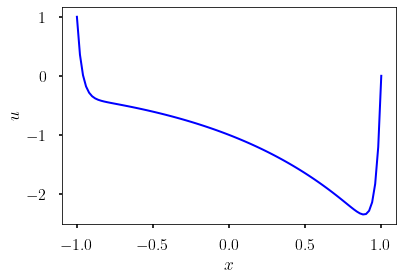

In [21]:
### Solution of Equation using Central Finite Difference Equation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
%matplotlib inline
matplotlib.rc('font', family='serif', serif='cm10')

matplotlib.rc('text', usetex=True)
### Number of Gridpoints
nu =1.0/10**-3
n = 100
h = (1+1) / n
x = np.linspace(-1,1,n+1)
# Difference Operator
A = np.zeros((n+1, n+1))

## Coefficient For Boundary Condition
A[0, 0] = 1
A[n, n] = 1

### Maric for Interior Point
for i in range(1, n):
    A[i, i-1] = 1
    A[i, i] = -(2 + (nu)*h**2)
    A[i, i+1] = 1

# Get b
b = np.zeros(n+1)
b = (np.exp(x))*h*h*(nu)

#### Imposition Boundary Condition 
b[0] = 1
b[-1] = 0
# solve the linear equations
y_act = np.linalg.solve(A, b)
### Plot of Equation
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
ax.plot(x, y_act, "-", lw=2.0, color="b")
ax.set_xlabel('$x$')
ax.set_ylabel("$u$")
plt.show()

In [22]:
#Using Vanilla PINN

import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu):
    x_u = X_u_train_tf
    x_f = X_f_train_tf
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u, W, b) 
        f_nn = net_f(x_f,W, b, nu)
        loss =  100.0*tf.reduce_mean(tf.square(u_nn - u_train_tf)) + tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss

def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**3
noise = 0.0        
N_f = 300
Nmax=3000

layers = [1, 4,4,4,4,4,4, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)


lr = 5e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0 and loss is: 36.536865234375
Iteration is: 1 and loss is: 32.31436538696289
Iteration is: 2 and loss is: 28.28046226501465
Iteration is: 3 and loss is: 24.432859420776367
Iteration is: 4 and loss is: 20.79062843322754
Iteration is: 5 and loss is: 17.39005470275879
Iteration is: 6 and loss is: 14.26872730255127
Iteration is: 7 and loss is: 11.459373474121094
Iteration is: 8 and loss is: 8.98551082611084
Iteration is: 9 and loss is: 6.85828161239624
Iteration is: 10 and loss is: 5.0749030113220215
Iteration is: 11 and loss is: 3.6195666790008545
Iteration is: 12 and loss is: 2.4678053855895996
Iteration is: 13 and loss is: 1.5934545993804932
Iteration is: 14 and loss is: 0.9745383262634277
Iteration is: 15 and loss is: 0.5949716567993164
Iteration is: 16 and loss is: 0.4408942461013794
Iteration is: 17 and loss is: 0.49178215861320496
Iteration is: 18 and loss is: 0.7089072465896606
Iteration is: 19 and loss is: 1.0280756950378418
Iteration is: 20 and loss is: 1.367208838

Iteration is: 208 and loss is: 0.05699741095304489
Iteration is: 209 and loss is: 0.05612797290086746
Iteration is: 210 and loss is: 0.055270805954933167
Iteration is: 211 and loss is: 0.054425839334726334
Iteration is: 212 and loss is: 0.05359288677573204
Iteration is: 213 and loss is: 0.05277203023433685
Iteration is: 214 and loss is: 0.05196288228034973
Iteration is: 215 and loss is: 0.051165640354156494
Iteration is: 216 and loss is: 0.050379909574985504
Iteration is: 217 and loss is: 0.049605775624513626
Iteration is: 218 and loss is: 0.04884302243590355
Iteration is: 219 and loss is: 0.04809174686670303
Iteration is: 220 and loss is: 0.047351621091365814
Iteration is: 221 and loss is: 0.04662265628576279
Iteration is: 222 and loss is: 0.04590480774641037
Iteration is: 223 and loss is: 0.04519791901111603
Iteration is: 224 and loss is: 0.044501982629299164
Iteration is: 225 and loss is: 0.04381677135825157
Iteration is: 226 and loss is: 0.04314219951629639
Iteration is: 227 and lo

Iteration is: 392 and loss is: 0.00943894311785698
Iteration is: 393 and loss is: 0.009401625953614712
Iteration is: 394 and loss is: 0.009364627301692963
Iteration is: 395 and loss is: 0.00932791456580162
Iteration is: 396 and loss is: 0.009291480295360088
Iteration is: 397 and loss is: 0.009255343116819859
Iteration is: 398 and loss is: 0.009219483472406864
Iteration is: 399 and loss is: 0.009183919988572598
Iteration is: 400 and loss is: 0.009148613549768925
Iteration is: 401 and loss is: 0.009113563224673271
Iteration is: 402 and loss is: 0.009078794158995152
Iteration is: 403 and loss is: 0.009044284000992775
Iteration is: 404 and loss is: 0.00901002250611782
Iteration is: 405 and loss is: 0.008976016193628311
Iteration is: 406 and loss is: 0.008942252025008202
Iteration is: 407 and loss is: 0.008908727206289768
Iteration is: 408 and loss is: 0.008875477127730846
Iteration is: 409 and loss is: 0.008842415176331997
Iteration is: 410 and loss is: 0.008809629827737808
Iteration is: 4

Iteration is: 575 and loss is: 0.005316153634339571
Iteration is: 576 and loss is: 0.005302362609654665
Iteration is: 577 and loss is: 0.005288653075695038
Iteration is: 578 and loss is: 0.005274982191622257
Iteration is: 579 and loss is: 0.005261377431452274
Iteration is: 580 and loss is: 0.005247823428362608
Iteration is: 581 and loss is: 0.0052343374118208885
Iteration is: 582 and loss is: 0.005220897030085325
Iteration is: 583 and loss is: 0.005207512527704239
Iteration is: 584 and loss is: 0.005194184836000204
Iteration is: 585 and loss is: 0.005180913023650646
Iteration is: 586 and loss is: 0.005167696624994278
Iteration is: 587 and loss is: 0.005154538433998823
Iteration is: 588 and loss is: 0.005141428206115961
Iteration is: 589 and loss is: 0.005128375254571438
Iteration is: 590 and loss is: 0.005115382838994265
Iteration is: 591 and loss is: 0.005102428607642651
Iteration is: 592 and loss is: 0.00508953956887126
Iteration is: 593 and loss is: 0.005076690576970577
Iteration is

Iteration is: 773 and loss is: 0.003390655620023608
Iteration is: 774 and loss is: 0.0033838392700999975
Iteration is: 775 and loss is: 0.003377031534910202
Iteration is: 776 and loss is: 0.0033702568616718054
Iteration is: 777 and loss is: 0.0033634991850703955
Iteration is: 778 and loss is: 0.0033567636273801327
Iteration is: 779 and loss is: 0.0033500511199235916
Iteration is: 780 and loss is: 0.003343353047966957
Iteration is: 781 and loss is: 0.003336676163598895
Iteration is: 782 and loss is: 0.0033300211653113365
Iteration is: 783 and loss is: 0.0033233824651688337
Iteration is: 784 and loss is: 0.003316770540550351
Iteration is: 785 and loss is: 0.00331016443669796
Iteration is: 786 and loss is: 0.0033035981468856335
Iteration is: 787 and loss is: 0.0032970367465168238
Iteration is: 788 and loss is: 0.00329050631262362
Iteration is: 789 and loss is: 0.0032839796040207148
Iteration is: 790 and loss is: 0.003277481533586979
Iteration is: 791 and loss is: 0.0032710032537579536
Ite

Iteration is: 965 and loss is: 0.0023795810993760824
Iteration is: 966 and loss is: 0.0023755475413054228
Iteration is: 967 and loss is: 0.0023715237621217966
Iteration is: 968 and loss is: 0.0023675053380429745
Iteration is: 969 and loss is: 0.0023635001853108406
Iteration is: 970 and loss is: 0.0023595052771270275
Iteration is: 971 and loss is: 0.0023555192165076733
Iteration is: 972 and loss is: 0.002351542469114065
Iteration is: 973 and loss is: 0.0023475773632526398
Iteration is: 974 and loss is: 0.0023436229676008224
Iteration is: 975 and loss is: 0.0023396757896989584
Iteration is: 976 and loss is: 0.0023357386235147715
Iteration is: 977 and loss is: 0.0023318100720643997
Iteration is: 978 and loss is: 0.002327891532331705
Iteration is: 979 and loss is: 0.0023239862639456987
Iteration is: 980 and loss is: 0.002320085186511278
Iteration is: 981 and loss is: 0.0023162022698670626
Iteration is: 982 and loss is: 0.0023123202845454216
Iteration is: 983 and loss is: 0.0023084513377398

Iteration is: 1149 and loss is: 0.0017905031563714147
Iteration is: 1150 and loss is: 0.001791414339095354
Iteration is: 1151 and loss is: 0.0017899756785482168
Iteration is: 1152 and loss is: 0.0017857140628620982
Iteration is: 1153 and loss is: 0.0017798958579078317
Iteration is: 1154 and loss is: 0.0017743908101692796
Iteration is: 1155 and loss is: 0.001770503236912191
Iteration is: 1156 and loss is: 0.0017684327904134989
Iteration is: 1157 and loss is: 0.0017674226546660066
Iteration is: 1158 and loss is: 0.0017663714243099093
Iteration is: 1159 and loss is: 0.0017644520848989487
Iteration is: 1160 and loss is: 0.0017614526441320777
Iteration is: 1161 and loss is: 0.0017577136168256402
Iteration is: 1162 and loss is: 0.0017538157990202308
Iteration is: 1163 and loss is: 0.0017503001727163792
Iteration is: 1164 and loss is: 0.0017474230844527483
Iteration is: 1165 and loss is: 0.0017451416933909059
Iteration is: 1166 and loss is: 0.0017431927844882011
Iteration is: 1167 and loss is

Iteration is: 1343 and loss is: 0.0013848571106791496
Iteration is: 1344 and loss is: 0.0013831069227308035
Iteration is: 1345 and loss is: 0.0013813514960929751
Iteration is: 1346 and loss is: 0.0013795942068099976
Iteration is: 1347 and loss is: 0.0013778266729786992
Iteration is: 1348 and loss is: 0.001376057625748217
Iteration is: 1349 and loss is: 0.001374292653053999
Iteration is: 1350 and loss is: 0.0013725294265896082
Iteration is: 1351 and loss is: 0.0013707715552300215
Iteration is: 1352 and loss is: 0.0013690198538824916
Iteration is: 1353 and loss is: 0.0013672756031155586
Iteration is: 1354 and loss is: 0.0013655386865139008
Iteration is: 1355 and loss is: 0.0013638049131259322
Iteration is: 1356 and loss is: 0.0013620788231492043
Iteration is: 1357 and loss is: 0.0013603559928014874
Iteration is: 1358 and loss is: 0.0013586393324658275
Iteration is: 1359 and loss is: 0.001356922322884202
Iteration is: 1360 and loss is: 0.0013552086893469095
Iteration is: 1361 and loss is:

Iteration is: 1534 and loss is: 0.0011187110794708133
Iteration is: 1535 and loss is: 0.0011174340033903718
Iteration is: 1536 and loss is: 0.0011161596048623323
Iteration is: 1537 and loss is: 0.0011148902121931314
Iteration is: 1538 and loss is: 0.0011136200046166778
Iteration is: 1539 and loss is: 0.0011123535223305225
Iteration is: 1540 and loss is: 0.0011110901832580566
Iteration is: 1541 and loss is: 0.001109828008338809
Iteration is: 1542 and loss is: 0.0011085697915405035
Iteration is: 1543 and loss is: 0.0011073099449276924
Iteration is: 1544 and loss is: 0.0011060547549277544
Iteration is: 1545 and loss is: 0.0011048036394640803
Iteration is: 1546 and loss is: 0.00110355275683105
Iteration is: 1547 and loss is: 0.0011023051338270307
Iteration is: 1548 and loss is: 0.001101059140637517
Iteration is: 1549 and loss is: 0.0010998162906616926
Iteration is: 1550 and loss is: 0.0010985761182382703
Iteration is: 1551 and loss is: 0.00109733990393579
Iteration is: 1552 and loss is: 0.

Iteration is: 1723 and loss is: 0.0009397318353876472
Iteration is: 1724 and loss is: 0.0009387630852870643
Iteration is: 1725 and loss is: 0.0009377985843457282
Iteration is: 1726 and loss is: 0.0009368364117108285
Iteration is: 1727 and loss is: 0.0009358745883218944
Iteration is: 1728 and loss is: 0.0009349136962555349
Iteration is: 1729 and loss is: 0.0009339530952274799
Iteration is: 1730 and loss is: 0.000932994531467557
Iteration is: 1731 and loss is: 0.0009320357930846512
Iteration is: 1732 and loss is: 0.0009310804307460785
Iteration is: 1733 and loss is: 0.0009301250684075058
Iteration is: 1734 and loss is: 0.0009291702299378812
Iteration is: 1735 and loss is: 0.0009282188839279115
Iteration is: 1736 and loss is: 0.0009272683528251946
Iteration is: 1737 and loss is: 0.0009263203828595579
Iteration is: 1738 and loss is: 0.0009253709577023983
Iteration is: 1739 and loss is: 0.0009244266548193991
Iteration is: 1740 and loss is: 0.0009234820026904345
Iteration is: 1741 and loss i

Iteration is: 1915 and loss is: 0.0008068914758041501
Iteration is: 1916 and loss is: 0.0008061467669904232
Iteration is: 1917 and loss is: 0.0008053987985476851
Iteration is: 1918 and loss is: 0.0008046419825404882
Iteration is: 1919 and loss is: 0.0008038730593398213
Iteration is: 1920 and loss is: 0.0008030968019738793
Iteration is: 1921 and loss is: 0.0008023224654607475
Iteration is: 1922 and loss is: 0.0008015534840524197
Iteration is: 1923 and loss is: 0.0008007925935089588
Iteration is: 1924 and loss is: 0.0008000386878848076
Iteration is: 1925 and loss is: 0.0007992908940650523
Iteration is: 1926 and loss is: 0.0007985425763763487
Iteration is: 1927 and loss is: 0.0007977942004799843
Iteration is: 1928 and loss is: 0.0007970432634465396
Iteration is: 1929 and loss is: 0.0007962904637679458
Iteration is: 1930 and loss is: 0.0007955341134220362
Iteration is: 1931 and loss is: 0.0007947820122353733
Iteration is: 1932 and loss is: 0.0007940287468954921
Iteration is: 1933 and loss 

Iteration is: 2105 and loss is: 0.0007131872698664665
Iteration is: 2106 and loss is: 0.0007126171258278191
Iteration is: 2107 and loss is: 0.0007119475048966706
Iteration is: 2108 and loss is: 0.0007112130988389254
Iteration is: 2109 and loss is: 0.0007104843971319497
Iteration is: 2110 and loss is: 0.0007098217029124498
Iteration is: 2111 and loss is: 0.0007092267042025924
Iteration is: 2112 and loss is: 0.0007086597033776343
Iteration is: 2113 and loss is: 0.0007080745999701321
Iteration is: 2114 and loss is: 0.0007074435125105083
Iteration is: 2115 and loss is: 0.0007067742990329862
Iteration is: 2116 and loss is: 0.0007060962379910052
Iteration is: 2117 and loss is: 0.0007054387242533267
Iteration is: 2118 and loss is: 0.0007048120605759323
Iteration is: 2119 and loss is: 0.0007042099605314434
Iteration is: 2120 and loss is: 0.0007036137976683676
Iteration is: 2121 and loss is: 0.0007030071574263275
Iteration is: 2122 and loss is: 0.0007023807847872376
Iteration is: 2123 and loss 

Iteration is: 2300 and loss is: 0.0006466756458394229
Iteration is: 2301 and loss is: 0.0006472351378761232
Iteration is: 2302 and loss is: 0.0006479303119704127
Iteration is: 2303 and loss is: 0.0006472595268860459
Iteration is: 2304 and loss is: 0.0006454722606576979
Iteration is: 2305 and loss is: 0.0006439478020183742
Iteration is: 2306 and loss is: 0.0006435419782064855
Iteration is: 2307 and loss is: 0.0006437969277612865
Iteration is: 2308 and loss is: 0.0006436798139475286
Iteration is: 2309 and loss is: 0.000642751925624907
Iteration is: 2310 and loss is: 0.0006414724048227072
Iteration is: 2311 and loss is: 0.0006405745516531169
Iteration is: 2312 and loss is: 0.0006402716971933842
Iteration is: 2313 and loss is: 0.0006401666905730963
Iteration is: 2314 and loss is: 0.0006397500983439386
Iteration is: 2315 and loss is: 0.0006389197078533471
Iteration is: 2316 and loss is: 0.00063799083000049
Iteration is: 2317 and loss is: 0.0006373121868818998
Iteration is: 2318 and loss is:

Iteration is: 2493 and loss is: 0.000948121421970427
Iteration is: 2494 and loss is: 0.0009661478106863797
Iteration is: 2495 and loss is: 0.0007365534547716379
Iteration is: 2496 and loss is: 0.0005985490861348808
Iteration is: 2497 and loss is: 0.0007025435916148126
Iteration is: 2498 and loss is: 0.0008378862403333187
Iteration is: 2499 and loss is: 0.0007928568520583212
Iteration is: 2500 and loss is: 0.00064616440795362
Iteration is: 2501 and loss is: 0.0006006400799378753
Iteration is: 2502 and loss is: 0.0006845479947514832
Iteration is: 2503 and loss is: 0.000747480196878314
Iteration is: 2504 and loss is: 0.000697161303833127
Iteration is: 2505 and loss is: 0.0006119465688243508
Iteration is: 2506 and loss is: 0.0006018973072059453
Iteration is: 2507 and loss is: 0.0006574355065822601
Iteration is: 2508 and loss is: 0.0006855642423033714
Iteration is: 2509 and loss is: 0.0006476172711700201
Iteration is: 2510 and loss is: 0.0005990792997181416
Iteration is: 2511 and loss is: 0

Iteration is: 2683 and loss is: 0.0005521580460481346
Iteration is: 2684 and loss is: 0.0005781860090792179
Iteration is: 2685 and loss is: 0.0006239385693334043
Iteration is: 2686 and loss is: 0.00070444296579808
Iteration is: 2687 and loss is: 0.0008477212395519018
Iteration is: 2688 and loss is: 0.0011021662503480911
Iteration is: 2689 and loss is: 0.0015603514621034265
Iteration is: 2690 and loss is: 0.0023758907336741686
Iteration is: 2691 and loss is: 0.0038447980768978596
Iteration is: 2692 and loss is: 0.006392217241227627
Iteration is: 2693 and loss is: 0.010793188586831093
Iteration is: 2694 and loss is: 0.017587881535291672
Iteration is: 2695 and loss is: 0.027294635772705078
Iteration is: 2696 and loss is: 0.03664914891123772
Iteration is: 2697 and loss is: 0.04094493389129639
Iteration is: 2698 and loss is: 0.03174440562725067
Iteration is: 2699 and loss is: 0.014191880822181702
Iteration is: 2700 and loss is: 0.0014849747531116009
Iteration is: 2701 and loss is: 0.0035675

Iteration is: 2875 and loss is: 0.0004939734353683889
Iteration is: 2876 and loss is: 0.0004935833858326077
Iteration is: 2877 and loss is: 0.0004931945586577058
Iteration is: 2878 and loss is: 0.0004928067210130394
Iteration is: 2879 and loss is: 0.0004924198728986084
Iteration is: 2880 and loss is: 0.0004920341889373958
Iteration is: 2881 and loss is: 0.0004916468751616776
Iteration is: 2882 and loss is: 0.0004912613076157868
Iteration is: 2883 and loss is: 0.0004908755072392523
Iteration is: 2884 and loss is: 0.000490489648655057
Iteration is: 2885 and loss is: 0.0004901057691313326
Iteration is: 2886 and loss is: 0.000489721423946321
Iteration is: 2887 and loss is: 0.0004893358564004302
Iteration is: 2888 and loss is: 0.0004889528499916196
Iteration is: 2889 and loss is: 0.0004885697271674871
Iteration is: 2890 and loss is: 0.0004881859931629151
Iteration is: 2891 and loss is: 0.00048780374345369637
Iteration is: 2892 and loss is: 0.00048742166836746037
Iteration is: 2893 and loss 

In [ ]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,loss_list, 'g-', linewidth = 2)       
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()





In [24]:
##Self Adaptive for residual minimzation


import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars_nn(W, b):
    return W + b

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def train_vars_sa(lambda_r, lambda_b):
    return lambda_r + lambda_b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    return alpha_r, alpha_b


#@tf.function(jit_compile=True)
@tf.function
def net_f(x, W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f

@tf.function
def net_fd(x, W, b, nu):
    h=0.1
    u_xx= (1/(h**2))*(net_u(x + h , W, b) - net_u(x, W, b) + net_u(x-h, W, b))
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu, lambda_r, lambda_b):
    x_u = X_u_train_tf
    x_f = X_f_train_tf
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b,lambda_r,lambda_b])
        u_nn = net_u(x_u, W, b) 
        f_nn = net_f(x_f,W, b, nu)
        loss_r = tf.square(lambda_r*f_nn)
        loss_b = tf.square(lambda_b*(u_nn-u_train_tf))
        loss =    tf.reduce_mean(loss_b) + tf.reduce_mean(loss_r)  
    grads = tape.gradient(loss, train_vars_nn(W, b))
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    opt.apply_gradients(zip(grads, train_vars_nn(W,b)))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    return loss

def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**-3
Nmax= 3000
N_f = 500
N_b = 2

layers = [1, 8, 8,8,8,8,8,1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

alpha_r, alpha_b = loss_weight(N_f, N_b)

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)


lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu, alpha_r, alpha_b)
    loss.append(loss_)    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))


Iteration is: 0 and loss is: 2177501.0
Iteration is: 1 and loss is: 2144915.75
Iteration is: 2 and loss is: 2120281.5
Iteration is: 3 and loss is: 2095652.125
Iteration is: 4 and loss is: 2070088.375
Iteration is: 5 and loss is: 2043338.75
Iteration is: 6 and loss is: 2015364.0
Iteration is: 7 and loss is: 1986224.375
Iteration is: 8 and loss is: 1956035.5
Iteration is: 9 and loss is: 1924947.0
Iteration is: 10 and loss is: 1893129.125
Iteration is: 11 and loss is: 1860765.375
Iteration is: 12 and loss is: 1828046.75
Iteration is: 13 and loss is: 1795166.25
Iteration is: 14 and loss is: 1762318.875
Iteration is: 15 and loss is: 1729697.625
Iteration is: 16 and loss is: 1697492.625
Iteration is: 17 and loss is: 1665889.125
Iteration is: 18 and loss is: 1635065.25
Iteration is: 19 and loss is: 1605189.625
Iteration is: 20 and loss is: 1576418.625
Iteration is: 21 and loss is: 1548894.375
Iteration is: 22 and loss is: 1522740.625
Iteration is: 23 and loss is: 1498060.25
Iteration is: 24 a

Iteration is: 338 and loss is: 1289658.125
Iteration is: 339 and loss is: 1290233.0
Iteration is: 340 and loss is: 1290816.5
Iteration is: 341 and loss is: 1291423.875
Iteration is: 342 and loss is: 1292057.0
Iteration is: 343 and loss is: 1292710.5
Iteration is: 344 and loss is: 1293384.0
Iteration is: 345 and loss is: 1294092.75
Iteration is: 346 and loss is: 1294877.25
Iteration is: 347 and loss is: 1295871.25
Iteration is: 348 and loss is: 1297324.25
Iteration is: 349 and loss is: 1299889.875
Iteration is: 350 and loss is: 1302745.875
Iteration is: 351 and loss is: 1304083.75
Iteration is: 352 and loss is: 1300213.75
Iteration is: 353 and loss is: 1299637.5
Iteration is: 354 and loss is: 1303376.25
Iteration is: 355 and loss is: 1303804.875
Iteration is: 356 and loss is: 1301848.625
Iteration is: 357 and loss is: 1302966.5
Iteration is: 358 and loss is: 1305381.25
Iteration is: 359 and loss is: 1305012.75
Iteration is: 360 and loss is: 1304403.5
Iteration is: 361 and loss is: 13065

Iteration is: 683 and loss is: 596495.5625
Iteration is: 684 and loss is: 590894.6875
Iteration is: 685 and loss is: 586535.875
Iteration is: 686 and loss is: 582740.1875
Iteration is: 687 and loss is: 578963.5
Iteration is: 688 and loss is: 574225.1875
Iteration is: 689 and loss is: 568314.3125
Iteration is: 690 and loss is: 561490.0
Iteration is: 691 and loss is: 555216.9375
Iteration is: 692 and loss is: 550065.75
Iteration is: 693 and loss is: 545948.3125
Iteration is: 694 and loss is: 542529.875
Iteration is: 695 and loss is: 539394.0625
Iteration is: 696 and loss is: 536183.8125
Iteration is: 697 and loss is: 531846.1875
Iteration is: 698 and loss is: 526232.75
Iteration is: 699 and loss is: 519629.09375
Iteration is: 700 and loss is: 513710.0625
Iteration is: 701 and loss is: 509119.0625
Iteration is: 702 and loss is: 505739.90625
Iteration is: 703 and loss is: 503129.96875
Iteration is: 704 and loss is: 500731.71875
Iteration is: 705 and loss is: 497994.75
Iteration is: 706 and

Iteration is: 1034 and loss is: 17701.49609375
Iteration is: 1035 and loss is: 17584.28125
Iteration is: 1036 and loss is: 17475.802734375
Iteration is: 1037 and loss is: 17379.765625
Iteration is: 1038 and loss is: 17295.21875
Iteration is: 1039 and loss is: 17217.37109375
Iteration is: 1040 and loss is: 17139.451171875
Iteration is: 1041 and loss is: 17057.12109375
Iteration is: 1042 and loss is: 16969.30078125
Iteration is: 1043 and loss is: 16876.87890625
Iteration is: 1044 and loss is: 16782.1328125
Iteration is: 1045 and loss is: 16689.619140625
Iteration is: 1046 and loss is: 16600.875
Iteration is: 1047 and loss is: 16517.26171875
Iteration is: 1048 and loss is: 16437.912109375
Iteration is: 1049 and loss is: 16360.720703125
Iteration is: 1050 and loss is: 16284.2900390625
Iteration is: 1051 and loss is: 16207.568359375
Iteration is: 1052 and loss is: 16129.1201171875
Iteration is: 1053 and loss is: 16049.115234375
Iteration is: 1054 and loss is: 15968.86328125
Iteration is: 10

Iteration is: 1211 and loss is: 8497.2978515625
Iteration is: 1212 and loss is: 8465.27734375
Iteration is: 1213 and loss is: 8435.337890625
Iteration is: 1214 and loss is: 8406.576171875
Iteration is: 1215 and loss is: 8379.0205078125
Iteration is: 1216 and loss is: 8352.09375
Iteration is: 1217 and loss is: 8325.1181640625
Iteration is: 1218 and loss is: 8297.2548828125
Iteration is: 1219 and loss is: 8268.958984375
Iteration is: 1220 and loss is: 8240.08203125
Iteration is: 1221 and loss is: 8210.845703125
Iteration is: 1222 and loss is: 8181.20263671875
Iteration is: 1223 and loss is: 8151.69287109375
Iteration is: 1224 and loss is: 8121.90576171875
Iteration is: 1225 and loss is: 8092.62158203125
Iteration is: 1226 and loss is: 8063.70751953125
Iteration is: 1227 and loss is: 8035.6953125
Iteration is: 1228 and loss is: 8007.16455078125
Iteration is: 1229 and loss is: 7979.71044921875
Iteration is: 1230 and loss is: 7952.4296875
Iteration is: 1231 and loss is: 7925.5400390625
Iter

Iteration is: 1389 and loss is: 4802.7939453125
Iteration is: 1390 and loss is: 4789.3427734375
Iteration is: 1391 and loss is: 4775.544921875
Iteration is: 1392 and loss is: 4761.8671875
Iteration is: 1393 and loss is: 4748.17041015625
Iteration is: 1394 and loss is: 4734.58544921875
Iteration is: 1395 and loss is: 4721.07080078125
Iteration is: 1396 and loss is: 4707.36474609375
Iteration is: 1397 and loss is: 4693.84326171875
Iteration is: 1398 and loss is: 4680.5400390625
Iteration is: 1399 and loss is: 4667.08642578125
Iteration is: 1400 and loss is: 4653.78564453125
Iteration is: 1401 and loss is: 4640.55712890625
Iteration is: 1402 and loss is: 4627.70361328125
Iteration is: 1403 and loss is: 4614.7744140625
Iteration is: 1404 and loss is: 4602.43408203125
Iteration is: 1405 and loss is: 4590.27099609375
Iteration is: 1406 and loss is: 4578.68310546875
Iteration is: 1407 and loss is: 4567.70654296875
Iteration is: 1408 and loss is: 4557.95166015625
Iteration is: 1409 and loss is

Iteration is: 1567 and loss is: 3141.451416015625
Iteration is: 1568 and loss is: 3148.221435546875
Iteration is: 1569 and loss is: 3163.546630859375
Iteration is: 1570 and loss is: 3175.81884765625
Iteration is: 1571 and loss is: 3201.99267578125
Iteration is: 1572 and loss is: 3223.21875
Iteration is: 1573 and loss is: 3265.9541015625
Iteration is: 1574 and loss is: 3299.929931640625
Iteration is: 1575 and loss is: 3368.447265625
Iteration is: 1576 and loss is: 3420.18896484375
Iteration is: 1577 and loss is: 3527.022216796875
Iteration is: 1578 and loss is: 3600.684814453125
Iteration is: 1579 and loss is: 3763.992919921875
Iteration is: 1580 and loss is: 3860.70751953125
Iteration is: 1581 and loss is: 4095.76318359375
Iteration is: 1582 and loss is: 4198.3798828125
Iteration is: 1583 and loss is: 4502.74658203125
Iteration is: 1584 and loss is: 4567.56396484375
Iteration is: 1585 and loss is: 4898.056640625
Iteration is: 1586 and loss is: 4851.09375
Iteration is: 1587 and loss is:

Iteration is: 1745 and loss is: 2437.831787109375
Iteration is: 1746 and loss is: 2502.7646484375
Iteration is: 1747 and loss is: 2522.859375
Iteration is: 1748 and loss is: 2548.240966796875
Iteration is: 1749 and loss is: 2522.814697265625
Iteration is: 1750 and loss is: 2508.38330078125
Iteration is: 1751 and loss is: 2454.190185546875
Iteration is: 1752 and loss is: 2414.53564453125
Iteration is: 1753 and loss is: 2352.98046875
Iteration is: 1754 and loss is: 2306.4072265625
Iteration is: 1755 and loss is: 2254.032470703125
Iteration is: 1756 and loss is: 2215.226806640625
Iteration is: 1757 and loss is: 2179.960205078125
Iteration is: 1758 and loss is: 2155.7587890625
Iteration is: 1759 and loss is: 2138.21044921875
Iteration is: 1760 and loss is: 2128.585205078125
Iteration is: 1761 and loss is: 2125.7958984375
Iteration is: 1762 and loss is: 2127.923828125
Iteration is: 1763 and loss is: 2136.73046875
Iteration is: 1764 and loss is: 2146.7353515625
Iteration is: 1765 and loss is

Iteration is: 1918 and loss is: 1778.8665771484375
Iteration is: 1919 and loss is: 1800.1806640625
Iteration is: 1920 and loss is: 1808.960205078125
Iteration is: 1921 and loss is: 1815.7608642578125
Iteration is: 1922 and loss is: 1810.8837890625
Iteration is: 1923 and loss is: 1807.92724609375
Iteration is: 1924 and loss is: 1797.2684326171875
Iteration is: 1925 and loss is: 1791.4532470703125
Iteration is: 1926 and loss is: 1780.108154296875
Iteration is: 1927 and loss is: 1774.256591796875
Iteration is: 1928 and loss is: 1763.5982666015625
Iteration is: 1929 and loss is: 1756.939453125
Iteration is: 1930 and loss is: 1745.9603271484375
Iteration is: 1931 and loss is: 1737.857177734375
Iteration is: 1932 and loss is: 1726.645751953125
Iteration is: 1933 and loss is: 1717.7760009765625
Iteration is: 1934 and loss is: 1707.4051513671875
Iteration is: 1935 and loss is: 1699.792236328125
Iteration is: 1936 and loss is: 1691.7867431640625
Iteration is: 1937 and loss is: 1686.54345703125


Iteration is: 2093 and loss is: 1551.0267333984375
Iteration is: 2094 and loss is: 1579.8433837890625
Iteration is: 2095 and loss is: 1584.365478515625
Iteration is: 2096 and loss is: 1560.6259765625
Iteration is: 2097 and loss is: 1518.66259765625
Iteration is: 2098 and loss is: 1470.908447265625
Iteration is: 2099 and loss is: 1426.94384765625
Iteration is: 2100 and loss is: 1395.849365234375
Iteration is: 2101 and loss is: 1379.6728515625
Iteration is: 2102 and loss is: 1378.0501708984375
Iteration is: 2103 and loss is: 1386.830078125
Iteration is: 2104 and loss is: 1401.275634765625
Iteration is: 2105 and loss is: 1414.8773193359375
Iteration is: 2106 and loss is: 1425.69921875
Iteration is: 2107 and loss is: 1428.9461669921875
Iteration is: 2108 and loss is: 1427.3994140625
Iteration is: 2109 and loss is: 1419.0133056640625
Iteration is: 2110 and loss is: 1408.282470703125
Iteration is: 2111 and loss is: 1395.0828857421875
Iteration is: 2112 and loss is: 1382.8565673828125
Iterati

Iteration is: 2268 and loss is: 3362.0224609375
Iteration is: 2269 and loss is: 4323.544921875
Iteration is: 2270 and loss is: 4754.1630859375
Iteration is: 2271 and loss is: 6067.26806640625
Iteration is: 2272 and loss is: 6019.74072265625
Iteration is: 2273 and loss is: 6986.76220703125
Iteration is: 2274 and loss is: 5873.1572265625
Iteration is: 2275 and loss is: 5527.12548828125
Iteration is: 2276 and loss is: 3811.76904296875
Iteration is: 2277 and loss is: 2672.64453125
Iteration is: 2278 and loss is: 1648.866943359375
Iteration is: 2279 and loss is: 1213.5985107421875
Iteration is: 2280 and loss is: 1290.6824951171875
Iteration is: 2281 and loss is: 1708.9136962890625
Iteration is: 2282 and loss is: 2305.6865234375
Iteration is: 2283 and loss is: 2652.20849609375
Iteration is: 2284 and loss is: 2965.21142578125
Iteration is: 2285 and loss is: 2688.828125
Iteration is: 2286 and loss is: 2402.26904296875
Iteration is: 2287 and loss is: 1855.7789306640625
Iteration is: 2288 and lo

Iteration is: 2441 and loss is: 1115.8353271484375
Iteration is: 2442 and loss is: 1120.5184326171875
Iteration is: 2443 and loss is: 1138.8092041015625
Iteration is: 2444 and loss is: 1158.0118408203125
Iteration is: 2445 and loss is: 1199.111572265625
Iteration is: 2446 and loss is: 1239.93994140625
Iteration is: 2447 and loss is: 1313.495361328125
Iteration is: 2448 and loss is: 1381.54443359375
Iteration is: 2449 and loss is: 1498.30419921875
Iteration is: 2450 and loss is: 1593.9224853515625
Iteration is: 2451 and loss is: 1754.888427734375
Iteration is: 2452 and loss is: 1854.6717529296875
Iteration is: 2453 and loss is: 2017.680419921875
Iteration is: 2454 and loss is: 2061.711181640625
Iteration is: 2455 and loss is: 2127.0029296875
Iteration is: 2456 and loss is: 2072.352783203125
Iteration is: 2457 and loss is: 1985.3837890625
Iteration is: 2458 and loss is: 1885.66796875
Iteration is: 2459 and loss is: 1737.731689453125
Iteration is: 2460 and loss is: 1665.188232421875
Itera

Iteration is: 2615 and loss is: 1008.714599609375
Iteration is: 2616 and loss is: 1045.1368408203125
Iteration is: 2617 and loss is: 1105.4034423828125
Iteration is: 2618 and loss is: 1181.55615234375
Iteration is: 2619 and loss is: 1313.279052734375
Iteration is: 2620 and loss is: 1470.3858642578125
Iteration is: 2621 and loss is: 1761.089599609375
Iteration is: 2622 and loss is: 2076.2626953125
Iteration is: 2623 and loss is: 2709.04931640625
Iteration is: 2624 and loss is: 3274.2978515625
Iteration is: 2625 and loss is: 4535.849609375
Iteration is: 2626 and loss is: 5265.1162109375
Iteration is: 2627 and loss is: 7245.8662109375
Iteration is: 2628 and loss is: 7377.3486328125
Iteration is: 2629 and loss is: 8995.4892578125
Iteration is: 2630 and loss is: 7294.05859375
Iteration is: 2631 and loss is: 6616.1982421875
Iteration is: 2632 and loss is: 3937.224365234375
Iteration is: 2633 and loss is: 2179.007080078125
Iteration is: 2634 and loss is: 1063.536865234375
Iteration is: 2635 a

Iteration is: 2792 and loss is: 842.7280883789062
Iteration is: 2793 and loss is: 867.438232421875
Iteration is: 2794 and loss is: 889.8770751953125
Iteration is: 2795 and loss is: 902.6255493164062
Iteration is: 2796 and loss is: 897.2821044921875
Iteration is: 2797 and loss is: 881.6747436523438
Iteration is: 2798 and loss is: 859.434326171875
Iteration is: 2799 and loss is: 841.2564697265625
Iteration is: 2800 and loss is: 828.9326782226562
Iteration is: 2801 and loss is: 823.273193359375
Iteration is: 2802 and loss is: 820.9389038085938
Iteration is: 2803 and loss is: 819.6443481445312
Iteration is: 2804 and loss is: 817.6317749023438
Iteration is: 2805 and loss is: 815.8881225585938
Iteration is: 2806 and loss is: 815.4413452148438
Iteration is: 2807 and loss is: 817.04296875
Iteration is: 2808 and loss is: 820.56396484375
Iteration is: 2809 and loss is: 824.25048828125
Iteration is: 2810 and loss is: 826.9254150390625
Iteration is: 2811 and loss is: 826.9310913085938
Iteration is

Iteration is: 2970 and loss is: 2822.48876953125
Iteration is: 2971 and loss is: 3412.32666015625
Iteration is: 2972 and loss is: 3741.890869140625
Iteration is: 2973 and loss is: 4321.69921875
Iteration is: 2974 and loss is: 4195.3330078125
Iteration is: 2975 and loss is: 4522.28759765625
Iteration is: 2976 and loss is: 3875.36328125
Iteration is: 2977 and loss is: 3883.5048828125
Iteration is: 2978 and loss is: 3206.247314453125
Iteration is: 2979 and loss is: 3097.64892578125
Iteration is: 2980 and loss is: 2678.190673828125
Iteration is: 2981 and loss is: 2628.14111328125
Iteration is: 2982 and loss is: 2147.12744140625
Iteration is: 2983 and loss is: 1845.9324951171875
Iteration is: 2984 and loss is: 1237.205078125
Iteration is: 2985 and loss is: 875.7158203125
Iteration is: 2986 and loss is: 798.5112915039062
Iteration is: 2987 and loss is: 1019.6702880859375
Iteration is: 2988 and loss is: 1402.225341796875
Iteration is: 2989 and loss is: 1630.322021484375
Iteration is: 2990 and

In [ ]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,loss_list/(np.max(loss_list)), 'g-', linewidth = 2)       
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()



In [ ]:
import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f

@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f






#@tf.function(jit_compile=True)
@tf.function
def train_step(layers, W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu, lambda_b, beta):
    x_u = X_u_train_tf[:,0:1]
    x_f = X_f_train_tf[:,0:1]
    adpative_constant_bcs_list = []
    lambda_b_list = []
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u,W, b) 
        f_nn = net_f(x_f,W, b, nu)
        bc_loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf))
        phys_loss = tf.reduce_mean(tf.square(f_nn)) 
        loss = lambda_b[-1]*bc_loss  + phys_loss
#         loss = loss / (1 + lambda_b[-1])
#         p_loss = phys_loss/(1 + lambda_b[-1])
#         b_loss = lambda_b[-1]*bc_loss/(1 + lambda_b[-1])
    grad_loss = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grad_loss, train_vars(W,b)))
    grads_bc = tape.gradient(bc_loss, train_vars(W,b))
    grads_phys = tape.gradient(phys_loss, train_vars(W,b))
    for i in range(len(layers) - 1):
        adpative_constant_bcs_list.append(
                tf.reduce_mean(tf.abs(grads_phys[i])) / tf.reduce_mean(tf.abs(grads_bc[i])))
        
    lambda_b_new = tf.reduce_mean(tf.stack(adpative_constant_bcs_list))
    lambda_b_new = (1-beta)*lambda_b[-1] + beta*lambda_b_new
    lambda_b_list.append(lambda_b_new)
                                      
    return loss, lambda_b_list, p_loss, b_loss


def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**-3
noise = 0.0        
N_f = 500
Nmax=50000

layers = [1, 8,8,8,8,8,8, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])
X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))
X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)
lam_b = np.array([1.0])
lam_b_tf= tf.convert_to_tensor(lam_b, dtype=tf.float32)                                
lambda_b_list = [lam_b_tf]                               
lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)
start_time = time.time()
n=0
loss = []
bc_loss = []
phys_loss = []
beta = 0.1

while n <= Nmax:
    loss_, lambda_b_out, phys_loss_, bc_loss_ = train_step(layers, W, b, X_u_train_tf,\
                                                u_train_tf, X_f_train_tf, optimizer, nu,lambda_b_list, beta)
    lambda_b_list = lambda_b_out
    loss.append(loss_) 
    bc_loss.append(bc_loss_)
    phys_loss.append(phys_loss_)
    
    print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))               
print('Training time: %.4f' % (elapsed))


def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]
bc_loss_list = [bc_loss[i].numpy() for i in range(len(bc_loss))]
phys_loss_list = [phys_loss[i].numpy() for i in range(len(phys_loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,bc_loss_list, 'g-', linewidth = 2, label="Boundary Loss")   
ax.semilogy(ep,phys_loss_list, 'r-', linewidth = 2, label="Residual Loss")
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()


In [ ]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]
bc_loss_list = [bc_loss[i].numpy() for i in range(len(bc_loss))]
phys_loss_list = [phys_loss[i].numpy() for i in range(len(phys_loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep, bc_loss_list, 'g-', linewidth = 2, label="Boundary Loss")   
ax.semilogy(ep,phys_loss_list, 'r-', linewidth = 2, label="Residual Loss")
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()

plt.show()


In [ ]:
#https://github.com/jnh277/Linearly-Constrained-NN/blob/release/simulted_divergence_free.py

import torch
from matplotlib import pyplot as plt
from torch.utils import data
import numpy as np
import torch.autograd as ag
import torch.nn as nn
torch.manual_seed(1234)
epochs = 400
n_data = 200
### Input Data
def vector_field(x, y, a=0.01):
    v1 = torch.exp(-a*x*y)*(a*x*torch.sin(x*y) - x*torch.cos(x*y))
    v2 = torch.exp(-a*x*y)*(y*torch.cos(x*y) - a*y*torch.sin(x*y))
    return (v1, v2)


## ------------------ set up models-------------------------- ##
# set network size
n_in = 2
n_h1 = 100
n_h2 = 50
n_o = 1

# two outputs for the unconstrained network
n_o_uc = 2

# define model class
class DivFree2D(torch.nn.Module):
    def __init__(self, base_net):
        super(DivFree2D, self).__init__()
        self.base_net = base_net

    def forward(self, x):
        x.requires_grad = True
        y = self.base_net(x)
        dydx = ag.grad(outputs=y, inputs=x, create_graph=True, grad_outputs=torch.ones(y.size()),
                       retain_graph=True, only_inputs=True)[0]
        return y, dydx[:,1].unsqueeze(1), -dydx[:,0].unsqueeze(1)

model = DivFree2D(nn.Sequential(nn.Linear(n_in,n_h1),nn.Tanh(),nn.Linear(n_h1,n_h2),
                                         nn.Tanh(),nn.Linear(n_h2,n_o)))


model_uc = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h1, n_h2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h2, n_o_uc),
)


# pregenerate validation data
x_val = 4.0 * torch.rand(2000, 2)
x1_val = x_val[:, 0].unsqueeze(1)
x2_val = x_val[:, 1].unsqueeze(1)

(v1, v2) = vector_field(x1_val, x2_val)
y1_val = v1 + 0.1 * torch.randn(x1_val.size())
y2_val = v2 + 0.1 * torch.randn(x1_val.size())
y_val = torch.cat((y1_val, y2_val), 1)


# Get the true function values on a grid
xv, yv = torch.meshgrid([torch.arange(0.0, 20.0) * 4.0 / 20.0, torch.arange(0.0, 20.0) * 4.0 / 20.0])
(v1, v2) = vector_field(xv, yv)

# generate training data
x_train = 4.0 * torch.rand(n_data, 2)
x1_train = x_train[:, 0].unsqueeze(1)
x2_train = x_train[:, 1].unsqueeze(1)

(v1_t, v2_t) = vector_field(x1_train, x2_train)
y1_train = v1_t + 0.1 * torch.randn(x1_train.size())
y2_train = v2_t + 0.1 * torch.randn(x1_train.size())


# define Dataset class
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, x1, x2, y1, y2):
        'Initialization'
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x1)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x1 = self.x1[index]
        x2 = self.x2[index]
        y1 = self.y1[index]
        y2 = self.y2[index]

        return x1, x2, y1, y2

training_set = Dataset(x1_train, x2_train, y1_train, y2_train)

# data loader Parameters
DL_params = {'batch_size': 100,
             'shuffle': True,
             'num_workers': 0,
             'pin_memory': False}
training_generator = data.DataLoader(training_set, **DL_params)


# ---------------  Set up and train the constrained model -------------------------------
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau\
                                    (optimizer, patience=10,
                                     min_lr=1e-10,
                                     factor=0.5, cooldown=15)

def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        (yhat, v1hat, v2hat) = model(x_train)
        loss = (criterion(y1_train, v1hat) + criterion(y2_train, v2hat)) / 2  # divide by 2 as it is a mean
        loss.backward()
        optimizer.step()
        total_loss += loss
        n_batches += 1
    return total_loss / n_batches

def eval(epoch):
    model.eval()
    # with torch.no_grad():
    (yhat, v1hat, v2hat) = model(x_val)
    loss = (criterion(y1_val, v1hat) + criterion(y2_val, v2hat)) / 2
    return loss.cpu()


train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])

print('Training Constrained NN')

for epoch in range(epochs):
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    print('Constrained NN: epoch: ', epoch, 'training loss ', train_loss[epoch], \
          'validation loss', val_loss[epoch])


# work out the rms error for this one
x_pred = torch.cat((xv.reshape(20 * 20, 1), yv.reshape(20 * 20, 1)), 1)
(f_pred, v1_pred, v2_pred) = model(x_pred)
error_new = torch.cat((v1.reshape(400, 1) - v1_pred.detach(), v2.reshape(400, 1) - v2_pred.detach()), 0)
rms_error = torch.sqrt(sum(error_new * error_new) / 800)

# ---------------  Set up and train the uncconstrained model -------------------------------
optimizer_uc = torch.optim.Adam(model_uc.parameters(), lr=0.01)
scheduler_uc = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_uc, patience=10,
                                                     min_lr=1e-10,
                                                    factor=0.5,
                                                    cooldown=15)

def train_uc(epoch):
    model_uc.train()
    total_loss = 0
    n_batches = 0
    for x1_train, x2_train, y1_train, y2_train in training_generator:
        optimizer_uc.zero_grad()
        x_train = torch.cat((x1_train, x2_train), 1)
        vhat = model_uc(x_train)
        y_train = torch.cat((y1_train, y2_train), 1)
        loss = criterion(y_train, vhat)
        loss.backward()
        optimizer_uc.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

def eval_uc(epoch):
    model_uc.eval()
    with torch.no_grad():
        (vhat) = model_uc(x_val)
        loss = criterion(y_val, vhat)
    return loss.cpu()


train_loss_uc = np.empty([epochs, 1])
val_loss_uc = np.empty([epochs, 1])


print('Training standard NN')

for epoch in range(epochs):
    train_loss_uc[epoch] = train_uc(epoch).detach().numpy()
    v_loss = eval_uc(epoch)
    scheduler_uc.step(v_loss)
    val_loss_uc[epoch] = v_loss.detach().numpy()
    print('Standard NN: epoch: ', epoch, 'training loss ', \
          train_loss_uc[epoch], 'validation loss', val_loss_uc[epoch])


# work out final rms error for unconstrainted net
(v_pred_uc) = model_uc(x_pred)
v1_pred_uc = v_pred_uc[:, 0]
v2_pred_uc = v_pred_uc[:, 1]

error_uc = torch.cat((v1.reshape(400) - v1_pred_uc.detach(), v2.reshape(400) - v2_pred_uc.detach()), 0)
rms_uc = torch.sqrt(sum(error_uc * error_uc) / 800)



print('Finished')
print("Final RMSE for constrained neural network: ",rms_error.item())
print("Final RMSE for standard neural network: ",rms_uc.item())

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 2, figsize=(20, 16))
    # ax.pcolor(xv,yv,f_scalar)
    ax[0, 0].quiver(xv, yv, v1, v2)
    ax[0, 0].quiver(xv, yv, v1_pred.reshape(20, 20).detach(), v2_pred.reshape(20, 20).detach(), color='r')
    ax[0, 0].legend(['true', 'predicted'], fontsize=22)
    ax[0, 0].set_title('Constrained NN ', fontsize=22)
    ax[0, 0].tick_params(axis='x', labelsize=14 )
    ax[0, 0].tick_params(axis='y', labelsize=14 )


    ax[1, 0].plot(np.log(train_loss),lw=3.0)
    ax[1, 0].plot(np.log(val_loss), lw=3.0)
    # ax[1].plot(loss_save[1:epoch].log().detach().numpy())
    ax[1, 0].set_xlabel('training epoch',  fontsize=22)
    ax[1, 0].set_ylabel('Loss',  fontsize=22)
    ax[1, 0].legend(['training loss', 'val loss'], fontsize=22)
    ax[1, 0].tick_params(axis='x', labelsize=14 )
    ax[1, 0].tick_params(axis='y', labelsize=14 )

    ax[0, 1].quiver(xv, yv, v1, v2)
    ax[0, 1].quiver(xv, yv, v1_pred_uc.reshape(20, 20).detach(), v2_pred_uc.reshape(20, 20).detach(), color='r')
    ax[0, 1].legend(['true', 'predicted'], fontsize=22)
    ax[0, 1].set_title('Standard NN ',fontsize=22)
    ax[0, 1].tick_params(axis='x', labelsize=14 )
    ax[0,1].tick_params(axis='y', labelsize=14 )

    ax[1, 1].plot(np.log(train_loss_uc),lw=3.0)
    ax[1, 1].plot(np.log(val_loss_uc),lw=3.0)
    ax[1, 1].set_ylabel('Loss', fontsize=22)
    ax[1, 1].set_xlabel('training epoch', fontsize=22)
    ax[1, 1].legend(['training loss','val loss'], fontsize=22)
    ax[1, 1].tick_params(axis='x', labelsize=14)
    ax[1,1].tick_params(axis='y', labelsize=14 )
    plt.savefig("Figure_1.png", dpi=300)
    plt.show()
   
    

    # Initialize second plot
    f2, ax2 = plt.subplots(1, 3, figsize=(48, 10))
    Q = ax2[0].quiver(xv, yv, v1, v2, scale=None, scale_units='inches')
    Q._init()
    assert isinstance(Q.scale, float)
    ax2[0].quiver(x1_train, x2_train, y1_train, y2_train, scale=Q.scale, scale_units='inches', color='r')
    ax2[0].set_xlabel('$x_1$')
    ax2[0].set_ylabel('$x_2$')
    ax2[0].tick_params(axis='x', labelsize=36)
    ax2[0].tick_params(axis='y', labelsize=36)
    


    error_new = torch.cat((v1.reshape(400, 1) - v1_pred.detach(), v2.reshape(400, 1) - v2_pred.detach()), 0)
    rms_new = torch.sqrt(sum(error_new * error_new) / 800)

    ax2[1].quiver(xv, yv, v1 - v1_pred.reshape(20, 20).detach(), v2 - v2_pred.reshape(20, 20).detach(),
                  scale=Q.scale, scale_units='inches')
    ax2[1].set_xlabel('$x_1$')
    ax2[1].set_ylabel('$x_2$')
    ax2[1].set_title('Constrained Approach RMSE={0:.2f}'.format(rms_new.item()), fontsize=36)
    ax2[1].tick_params(axis='x', labelsize=36 )
    ax2[1].tick_params(axis='y', labelsize=36 )
    


    error_uc = torch.cat((v1.reshape(400) - v1_pred_uc.detach(), v2.reshape(400) - v2_pred_uc.detach()), 0)
    rms_uc = torch.sqrt(sum(error_uc * error_uc) / 800)

    ax2[2].quiver(xv, yv, v1 - v1_pred_uc.reshape(20, 20).detach(), v2 - v2_pred_uc.reshape(20, 20).detach(),
                  scale=Q.scale, scale_units='inches')
    ax2[2].set_xlabel('$x_1$')
    ax2[2].set_ylabel('$x_2$')
    ax2[2].set_title('Unconstrained NN RMSE={0:.2f}'.format(rms_uc.item()), fontsize=36)
    ax2[2].tick_params(axis='x', labelsize=36 )
    ax2[2].tick_params(axis='y', labelsize=36 )
    plt.savefig("Figure_2.png", dpi=300)
    plt.show()
